# Homework 3
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right?

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [42]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.0+cu100
# CUDA enabled: True

Version 1.3.1+cu100
CUDA enabled: True


In [43]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
'My Drive'  'Shared drives'


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [0]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework3/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
        
    # TODO Add more preprocessing
    data = re.sub(r'\s+', ' ', data)
    voc2ind = dict()
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    i = 0
    for char in data:
        if char not in voc2ind:
            voc2ind[char] = i
            i += 1

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_szie = 0.8
    train_end_index = int(train_szie * len(data))

    train_text = data[:train_end_index]
    test_text = data[train_end_index:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # remove tokens that aren't enough to make a batch
        tokens = dataset['tokens']
        trim_index = len(tokens) - (len(tokens) % batch_size)
        tokens = tokens[:trim_index]
        tokens = self.vocab.words_to_array(tokens)
        self.tokens = tokens.reshape(self.batch_size, -1)
        self.num_unique_seq = batch_size * ((self.tokens.shape[1] // self.sequence_length)
                                            + (0 if self.tokens.shape[1] % self.sequence_length == 0 else 1))

    def __len__(self):
        # return the number of unique sequences you have, not the number of characters.
        return self.num_unique_seq
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are
        # in and how far down in the chunk you are.
        batch = idx % self.batch_size
        start = idx // self.batch_size * self.sequence_length
        end = start + self.sequence_length + 1
        data = self.tokens[batch, start:end]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [0]:
class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [0]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10


def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        idx = torch.argmax(output)
        output, hidden = model.inference(idx, hidden, TEMPERATURE)
        outputs.append(idx.item())
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        idx = torch.multinomial(output, 1)
        output, hidden = model.inference(idx, hidden, TEMPERATURE)
        outputs.append(idx.item())
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    beam_list = [([], output, hidden, 0)]
    idx = torch.multinomial(output, 1)
    model.inference(idx, beam_list[0][2], TEMPERATURE)
    for ii in range(sequence_length):
        temp_beam_list = []
        for beam in beam_list:
            indexes = torch.multinomial(beam[1], 9, replacement=True)
            for idx in indexes.flatten():
                score = beam[3] + torch.log(beam[1].flatten()[idx]).item()
                output, hidden = model.inference(idx, beam[2], TEMPERATURE)
                temp_beam_list.append(([beam[0] + [idx.item()], output, hidden, score]))

        beam_list = temp_beam_list
        beam_list = sorted(beam_list, key=lambda x: x[3], reverse=True)
        beam_list = beam_list[:beam_width]

    outputs = beam_list[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)

        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_perplexity = torch.exp(torch.tensor(test_loss)).item()
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Perplexity: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_perplexity, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy, test_perplexity

In [0]:
!rm -rf /content/logs/
!rm -rf /content/checkpoints/

Using device cuda
num workers: 2
Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	/?91P//fpddf/eee//yeeeee?eeee_/s%y/5**5Tq/''/8H/RR//e/''y}UUYRHe?/fPpeeeRn$q%_/'sCCx"/xp9/G/xPpof/z9


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	CPPPees6y/sasy1/5*T5///eee/z99T/ey,NNVH//Kb((VsCy/sP5}/p''ssssy/ppp/xJPa`sy1//6es///,,/VH/6y/5Tl5ROl


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	aRCRew//eeeeepNNdqw/p'//%y/?ReZZe/s///6y/eePK//Rddf!//ll1/''//s?Px?zeeeHYsC/s'y/?sCCdi,y/?ss?''//z99


Input	help

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 16.5993, Perplexity: 16180842.0000, Accuracy: 17332/1254400 (1%)



  1%|          | 1/195 [00:00<00:30,  6.36it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 16.572449


  7%|▋         | 13/195 [00:00<00:13, 13.97it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 12.074552


 13%|█▎        | 25/195 [00:01<00:08, 19.75it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 6.096525


 17%|█▋        | 34/195 [00:01<00:07, 21.42it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 3.955497


 22%|██▏       | 43/195 [00:02<00:06, 21.77it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 3.024127


 28%|██▊       | 55/195 [00:02<00:06, 21.72it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 3.614992


 33%|███▎      | 64/195 [00:02<00:05, 22.07it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 3.558424


 37%|███▋      | 73/195 [00:03<00:05, 22.27it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 2.683936


 44%|████▎     | 85/195 [00:03<00:04, 22.56it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 2.270292


 48%|████▊     | 94/195 [00:04<00:04, 22.21it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 2.106508


 53%|█████▎    | 103/195 [00:04<00:04, 22.11it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 2.021869


 59%|█████▉    | 115/195 [00:05<00:03, 22.38it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 2.130208


 64%|██████▎   | 124/195 [00:05<00:03, 22.24it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 2.051163


 68%|██████▊   | 133/195 [00:06<00:02, 22.91it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.961026


 74%|███████▍  | 145/195 [00:06<00:02, 22.22it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.889096


 79%|███████▉  | 154/195 [00:06<00:01, 22.36it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 2.050010


 84%|████████▎ | 163/195 [00:07<00:01, 22.61it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 2.928298


 90%|████████▉ | 175/195 [00:07<00:00, 22.61it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 2.361560


 94%|█████████▍| 184/195 [00:08<00:00, 22.38it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.972380


 99%|█████████▉| 193/195 [00:08<00:00, 22.60it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.878212


100%|██████████| 195/195 [00:08<00:00, 22.06it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	soeat tunhtttd taargd alain   ahe sare   aasl  "T wn sa re .. "e said  "Wu 't yauky  aade  said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	use  ahe sft r aare  and aarry aaad d aumbledore aeck an o the snk,waad y r ahet alrl   ahe faaaena 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	e  ng and weagpang an the saseee tf the soreeaashttnhuan an taww att   "ur wn  weureeey aarett tarry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and a sudle and the saway a surpared at the care and a flaway a feent a should and a a again a a again. "So he was a saway a surpared and the flat the care and a flaway a flaway and a saway a su



  1%|          | 1/195 [00:00<00:28,  6.76it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.872130


  7%|▋         | 13/195 [00:00<00:12, 14.45it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.943442


 13%|█▎        | 25/195 [00:01<00:08, 19.59it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 2.272677


 17%|█▋        | 34/195 [00:01<00:07, 21.18it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 2.015081


 22%|██▏       | 43/195 [00:02<00:06, 21.95it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.882733


 28%|██▊       | 55/195 [00:02<00:06, 21.87it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.814476


 33%|███▎      | 64/195 [00:02<00:05, 22.24it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.832828


 37%|███▋      | 73/195 [00:03<00:05, 22.45it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.796107


 44%|████▎     | 85/195 [00:03<00:05, 21.63it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.743800


 48%|████▊     | 94/195 [00:04<00:04, 22.21it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.736223


 53%|█████▎    | 103/195 [00:04<00:04, 22.09it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.754361


 59%|█████▉    | 115/195 [00:05<00:03, 21.96it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.773136


 64%|██████▎   | 124/195 [00:05<00:03, 22.14it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.809384


 68%|██████▊   | 133/195 [00:06<00:02, 21.84it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.891173


 74%|███████▍  | 145/195 [00:06<00:02, 22.17it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.847088


 79%|███████▉  | 154/195 [00:07<00:01, 22.19it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.740071


 84%|████████▎ | 163/195 [00:07<00:01, 22.31it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.703429


 90%|████████▉ | 175/195 [00:07<00:00, 22.61it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.854851


 94%|█████████▍| 184/195 [00:08<00:00, 21.96it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.709592


 99%|█████████▉| 193/195 [00:08<00:00, 21.84it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.668957


100%|██████████| 195/195 [00:08<00:00, 21.85it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	treathsunhttnd siargd onainst ahe same   aask  "I ss sh ke .  "e said  "Wun't yarky "ttte" said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	see  the sft r oale  tnd Harry sard d humbledore seck tn o the stk ster yer thet herl   ohe fleaene 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	e  ng and soeg eng an the saseee of the foyk aashthnauem an tagwtette  "ur wf  terriele tere t oarry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry started the floor. "I he studently the started the floor. "I he studently the started the floor. "I he studently the started the floor. "I he studently the started the floor. "I he studently the



  1%|          | 1/195 [00:00<00:28,  6.78it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.671949


  7%|▋         | 13/195 [00:00<00:12, 14.46it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.655094


 13%|█▎        | 25/195 [00:01<00:08, 19.80it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.639489


 17%|█▋        | 34/195 [00:01<00:07, 21.32it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.624391


 22%|██▏       | 43/195 [00:02<00:07, 21.61it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.668942


 28%|██▊       | 55/195 [00:02<00:06, 22.14it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.627556


 33%|███▎      | 64/195 [00:02<00:05, 22.38it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.629615


 37%|███▋      | 73/195 [00:03<00:05, 22.23it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.603848


 44%|████▎     | 85/195 [00:03<00:05, 21.87it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.671294


 48%|████▊     | 94/195 [00:04<00:04, 22.01it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.803192


 53%|█████▎    | 103/195 [00:04<00:04, 22.02it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.658627


 59%|█████▉    | 115/195 [00:05<00:03, 22.70it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.583571


 64%|██████▎   | 124/195 [00:05<00:03, 22.89it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.656177


 68%|██████▊   | 133/195 [00:06<00:02, 22.66it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.764738


 74%|███████▍  | 145/195 [00:06<00:02, 22.38it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.636289


 79%|███████▉  | 154/195 [00:06<00:01, 22.47it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.583696


 84%|████████▎ | 163/195 [00:07<00:01, 22.42it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.575933


 90%|████████▉ | 175/195 [00:07<00:00, 22.42it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.626663


 94%|█████████▍| 184/195 [00:08<00:00, 23.01it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.552498


 99%|█████████▉| 193/195 [00:08<00:00, 23.13it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.551181


100%|██████████| 195/195 [00:08<00:00, 22.10it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	troat ohgnttnd soartd tnainst the oore  oaask  "I ts shrri .  "e said  "Won't yarky "tote" said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wse  the stt r oore  and harry saap d humbledore aeck tn o the cta ooet yer ohot horl   ooe cooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	e  ng and hoovpeng hn the cisdle of the cork aashthnuuem ht tagwteate  "ir wu  telrible aerent oarry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry sounded to he had been and he stood out of the course of the course of the course of the course of the course of the course of the course of the course of the course of the course of the course 



  1%|          | 1/195 [00:00<00:28,  6.78it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.562065


  7%|▋         | 13/195 [00:00<00:12, 14.46it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.559540


 13%|█▎        | 25/195 [00:01<00:08, 20.10it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.542201


 17%|█▋        | 34/195 [00:01<00:07, 21.55it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.545143


 22%|██▏       | 43/195 [00:02<00:06, 22.15it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.537139


 28%|██▊       | 55/195 [00:02<00:06, 22.49it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.570181


 33%|███▎      | 64/195 [00:02<00:05, 22.71it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.614090


 37%|███▋      | 73/195 [00:03<00:05, 22.59it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.542233


 44%|████▎     | 85/195 [00:03<00:04, 22.38it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.502259


 48%|████▊     | 94/195 [00:04<00:04, 22.74it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.524250


 53%|█████▎    | 103/195 [00:04<00:04, 22.58it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.532839


 59%|█████▉    | 115/195 [00:05<00:03, 21.85it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.494946


 64%|██████▎   | 124/195 [00:05<00:03, 22.09it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.510865


 68%|██████▊   | 133/195 [00:06<00:02, 22.08it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.531094


 74%|███████▍  | 145/195 [00:06<00:02, 22.17it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.530790


 79%|███████▉  | 154/195 [00:06<00:01, 22.36it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.557048


 84%|████████▎ | 163/195 [00:07<00:01, 22.03it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.638878


 90%|████████▉ | 175/195 [00:07<00:00, 22.60it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.542945


 94%|█████████▍| 184/195 [00:08<00:00, 21.89it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.498792


 99%|█████████▉| 193/195 [00:08<00:00, 22.14it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.493053


100%|██████████| 195/195 [00:08<00:00, 22.03it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	troat Hhgnttnd soartd ttain t the tare  oaisk  "I tm shrri .  "e said  "Iun't yarky  tog," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wse  the ctr r oore  and harry saad d humbledore aeck tn o the cna ooer yed,ahet hlrl d ooe booaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	e  ng and seen eng an the cosdle of the cerk aashtanuuethhn tagwmeate  "ir wn  telrible aerent harry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry said Ron and Harry said Ron and Harry said Ron and Harry said Ron and Harry said Ron and Harry said Ron and Harry said Ron and Harry said Ron and Harry said Ron and Harry said Ron and Harry said



  1%|          | 1/195 [00:00<00:28,  6.91it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.512165


  7%|▋         | 13/195 [00:00<00:12, 14.60it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.504263


 13%|█▎        | 25/195 [00:01<00:08, 19.83it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.493316


 17%|█▋        | 34/195 [00:01<00:07, 21.50it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.543649


 22%|██▏       | 43/195 [00:02<00:06, 21.84it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.540061


 28%|██▊       | 55/195 [00:02<00:06, 22.11it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.560392


 33%|███▎      | 64/195 [00:02<00:05, 22.00it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.523992


 37%|███▋      | 73/195 [00:03<00:05, 22.28it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.485542


 44%|████▎     | 85/195 [00:03<00:04, 22.33it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.463343


 48%|████▊     | 94/195 [00:04<00:04, 21.89it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.489171


 53%|█████▎    | 103/195 [00:04<00:04, 22.36it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.479605


 59%|█████▉    | 115/195 [00:05<00:03, 22.34it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.450739


 64%|██████▎   | 124/195 [00:05<00:03, 22.33it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.468767


 68%|██████▊   | 133/195 [00:06<00:02, 22.33it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.506372


 74%|███████▍  | 145/195 [00:06<00:02, 22.03it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.495055


 79%|███████▉  | 154/195 [00:07<00:01, 22.10it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.478162


 84%|████████▎ | 163/195 [00:07<00:01, 22.56it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.507078


 90%|████████▉ | 175/195 [00:07<00:00, 22.15it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.553429


 94%|█████████▍| 184/195 [00:08<00:00, 22.73it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.489040


 99%|█████████▉| 193/195 [00:08<00:00, 22.69it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.471688


100%|██████████| 195/195 [00:08<00:00, 21.99it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	troat Hhdnttnd seavid ttain t the base  oahsk  "I tm thrri .  "e said  "Iun't yarry  Iog," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ws d the btr r oare  and harry saad d humbledore aack tn o the bna ooeray d ahat hlne   ooe baoaene 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	e  ng and heanpeng in the cagdle of the bark aash anauet hn tagwmeade  "ir wf  oelrible aerent harry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry said Ron and Harry said Ron and Harry said Ron and Harry said Ron and Harry said Ron and Harry said Ron and Harry said Ron and Harry said Ron and Harry said Ron and Harry said Ron and Harry said



  1%|          | 1/195 [00:00<00:28,  6.71it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.498074


  8%|▊         | 15/195 [00:00<00:11, 15.85it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.469423


 12%|█▏        | 24/195 [00:01<00:08, 19.93it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.454968


 17%|█▋        | 33/195 [00:01<00:07, 20.96it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.463029


 23%|██▎       | 45/195 [00:02<00:06, 22.14it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.455413


 28%|██▊       | 54/195 [00:02<00:06, 22.18it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.442574


 32%|███▏      | 63/195 [00:02<00:05, 22.42it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.471968


 38%|███▊      | 75/195 [00:03<00:05, 22.61it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.449663


 43%|████▎     | 84/195 [00:03<00:05, 22.14it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.429677


 48%|████▊     | 93/195 [00:04<00:04, 22.01it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.452885


 54%|█████▍    | 105/195 [00:04<00:04, 22.36it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.455380


 58%|█████▊    | 114/195 [00:05<00:03, 22.42it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.438991


 63%|██████▎   | 123/195 [00:05<00:03, 22.37it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.505553


 69%|██████▉   | 135/195 [00:06<00:02, 22.49it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.506443


 74%|███████▍  | 144/195 [00:06<00:02, 22.50it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.471534


 78%|███████▊  | 153/195 [00:06<00:01, 22.17it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.452061


 85%|████████▍ | 165/195 [00:07<00:01, 22.53it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.443461


 89%|████████▉ | 174/195 [00:07<00:00, 22.15it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.422339


 94%|█████████▍| 183/195 [00:08<00:00, 22.24it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.418120


100%|██████████| 195/195 [00:08<00:00, 23.70it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.424796


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	troat lhdntond soavtd ttain t the care  oaisk  "I tm nerri..  "e said  "Won't yarry  Iot," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ws d the btt r olre  and harry saad d humbledore weck on o the cnr ooetayed ohet honl d ooe booaene 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	e  ng hnd heenpeng hn the cogdle of the cork oash anauethon tagwmeade  "or sf  oewroble serent harry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The was so last the back of the carried out of the carried out of the carried out of the carried out of the carried out of the carried out of the carried out of the carried out of the carried out of t



  1%|          | 1/195 [00:00<00:28,  6.83it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.452913


  7%|▋         | 13/195 [00:00<00:12, 14.55it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.440800


 13%|█▎        | 25/195 [00:01<00:08, 19.89it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.430223


 17%|█▋        | 34/195 [00:01<00:07, 21.59it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.442103


 22%|██▏       | 43/195 [00:02<00:06, 22.14it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.435622


 28%|██▊       | 55/195 [00:02<00:06, 22.63it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.472543


 33%|███▎      | 64/195 [00:02<00:05, 22.58it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.502712


 37%|███▋      | 73/195 [00:03<00:05, 22.24it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.446096


 44%|████▎     | 85/195 [00:03<00:04, 22.20it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.410327


 48%|████▊     | 94/195 [00:04<00:04, 22.60it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.426704


 53%|█████▎    | 103/195 [00:04<00:04, 22.36it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.423908


 59%|█████▉    | 115/195 [00:05<00:03, 22.19it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.400801


 64%|██████▎   | 124/195 [00:05<00:03, 22.83it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.439318


 68%|██████▊   | 133/195 [00:06<00:02, 22.67it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.459828


 74%|███████▍  | 145/195 [00:06<00:02, 21.98it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.437140


 79%|███████▉  | 154/195 [00:06<00:01, 22.80it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.423573


 84%|████████▎ | 163/195 [00:07<00:01, 22.78it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.418391


 90%|████████▉ | 175/195 [00:07<00:00, 21.78it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.403648


 94%|█████████▍| 184/195 [00:08<00:00, 21.95it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.394361


 99%|█████████▉| 193/195 [00:08<00:00, 22.44it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.409375


100%|██████████| 195/195 [00:08<00:00, 22.09it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	troat shdntond soadtd ttain t the chse  oahsk  "I tm nhrr,..  "e said  "Ion't yarry, yot," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ws d the ctt r olre  and harry saad d humbledore seck on o the cnr ooethyed ahet honled ohe booaene 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	er ng hnd seanpeng hn the coddle of the cork oash anuaethon tagsmeade  "or sf  hewrible serent harry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry said Harry stood be all of the chair and started to be a been a looking at he had been a looked at him and started to be a been a looking at he had been a looked at him and started to be a been 



  1%|          | 1/195 [00:00<00:29,  6.64it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.435242


  7%|▋         | 13/195 [00:00<00:12, 14.19it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.421157


 13%|█▎        | 25/195 [00:01<00:08, 19.38it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.415518


 17%|█▋        | 34/195 [00:01<00:07, 21.46it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.453522


 22%|██▏       | 43/195 [00:02<00:06, 22.07it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.536645


 28%|██▊       | 55/195 [00:02<00:06, 21.91it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.428067


 33%|███▎      | 64/195 [00:02<00:05, 22.02it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.423507


 37%|███▋      | 73/195 [00:03<00:05, 22.27it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.408561


 44%|████▎     | 85/195 [00:03<00:04, 22.77it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.387520


 48%|████▊     | 94/195 [00:04<00:04, 22.88it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.402822


 53%|█████▎    | 103/195 [00:04<00:04, 22.27it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.405199


 59%|█████▉    | 115/195 [00:05<00:03, 22.61it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.383995


 64%|██████▎   | 124/195 [00:05<00:03, 22.44it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.401358


 68%|██████▊   | 133/195 [00:06<00:02, 22.37it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.420216


 74%|███████▍  | 145/195 [00:06<00:02, 22.27it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.413050


 79%|███████▉  | 154/195 [00:06<00:01, 22.32it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.419833


 84%|████████▎ | 163/195 [00:07<00:01, 21.80it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.400387


 90%|████████▉ | 175/195 [00:07<00:00, 22.61it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.383462


 94%|█████████▍| 184/195 [00:08<00:00, 22.47it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.381563


 99%|█████████▉| 193/195 [00:08<00:00, 22.45it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.399333


100%|██████████| 195/195 [00:08<00:00, 22.01it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooat shdntond soadid ttain,t the cose  oahsk  "I dm nhrr,..  "e said  "Ion't yarry, yot," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ws d the bnt r oore  and harry saad d humbledore seck on o the cnr ooithyed.ahat honled ohe booaene 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	er ng hnd sienpeng hn the coddle of the cork oash anuaethon tagsmeade  "or sf  heurible aerent harry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What do you have been the only on the for the stand of the corridor of the corridor of the corridor of the corridor of the corridor of the corridor of the corridor of the corridor of the corridor of 



  1%|          | 1/195 [00:00<00:29,  6.51it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.417249


  7%|▋         | 13/195 [00:00<00:12, 14.22it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.405891


 13%|█▎        | 25/195 [00:01<00:08, 19.82it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.396082


 17%|█▋        | 34/195 [00:01<00:07, 21.11it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.418131


 22%|██▏       | 43/195 [00:02<00:07, 21.58it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.460719


 28%|██▊       | 55/195 [00:02<00:06, 22.24it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.404755


 33%|███▎      | 64/195 [00:02<00:05, 22.54it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.409557


 37%|███▋      | 73/195 [00:03<00:05, 22.76it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.391970


 44%|████▎     | 85/195 [00:03<00:04, 22.36it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.375676


 48%|████▊     | 94/195 [00:04<00:04, 22.12it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.394266


 53%|█████▎    | 103/195 [00:04<00:04, 22.01it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.402470


 59%|█████▉    | 115/195 [00:05<00:03, 22.29it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.375862


 64%|██████▎   | 124/195 [00:05<00:03, 22.20it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.391667


 68%|██████▊   | 133/195 [00:06<00:02, 21.86it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.411618


 74%|███████▍  | 145/195 [00:06<00:02, 22.56it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.399549


 79%|███████▉  | 154/195 [00:06<00:01, 22.61it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.425018


 84%|████████▎ | 163/195 [00:07<00:01, 22.28it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.382883


 90%|████████▉ | 175/195 [00:07<00:00, 22.14it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.370635


 94%|█████████▍| 184/195 [00:08<00:00, 22.18it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.364337


 99%|█████████▉| 193/195 [00:08<00:00, 22.49it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.389440


100%|██████████| 195/195 [00:08<00:00, 21.98it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooat sidntond soadid tnainst the eose  oaask  "I dm shrr,..  "e said  "Ion't yauky  yor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed the btt r oore  and harry saad d humbledore seck on o the cne oiitayed.ahat honled ooe booaene 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	er ng and sienpeng hn the ciddle of the cork oash anaaenhon tagsmeade  "or sf  weurible aarent harry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What do you have to be seen the only of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the corridor and seemed to be all the for the s



  1%|          | 1/195 [00:00<00:30,  6.43it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.406301


  7%|▋         | 13/195 [00:00<00:13, 13.85it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.392284


 13%|█▎        | 25/195 [00:01<00:08, 19.61it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.390885


 17%|█▋        | 34/195 [00:01<00:07, 21.47it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.413774


 22%|██▏       | 43/195 [00:02<00:06, 22.17it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.405718


 28%|██▊       | 55/195 [00:02<00:06, 21.79it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.371862


 33%|███▎      | 64/195 [00:02<00:05, 22.57it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.384895


 37%|███▋      | 73/195 [00:03<00:05, 21.84it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.383052


 44%|████▎     | 85/195 [00:03<00:04, 22.15it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.366062


 48%|████▊     | 94/195 [00:04<00:04, 22.29it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.387105


 53%|█████▎    | 103/195 [00:04<00:04, 22.53it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.392496


 59%|█████▉    | 115/195 [00:05<00:03, 22.20it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.368726


 64%|██████▎   | 124/195 [00:05<00:03, 22.34it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.386320


 68%|██████▊   | 133/195 [00:06<00:02, 22.39it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.405750


 74%|███████▍  | 145/195 [00:06<00:02, 22.37it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.392497


 79%|███████▉  | 154/195 [00:07<00:01, 22.25it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.388612


 84%|████████▎ | 163/195 [00:07<00:01, 22.13it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.372505


 90%|████████▉ | 175/195 [00:07<00:00, 22.20it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.370654


 94%|█████████▍| 184/195 [00:08<00:00, 22.50it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.363187


 99%|█████████▉| 193/195 [00:08<00:00, 22.21it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.382408


100%|██████████| 195/195 [00:08<00:00, 21.89it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat sidntond seaned ttainst the ease  oaask  "I tm shrr,..  "e said  "Iun't yauky  tor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ws d the btt r orre  and sarry saad d humbledore seck tn o the cne oiitayid aoat tonled ooe booaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering and sienpeng hn the caddle of the cork oashtanaaensan tagsmeade  "rr af  weurible aarent aarry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What do you think you want to tell you to the first time in the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of



  1%|          | 1/195 [00:00<00:30,  6.29it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.398405


  8%|▊         | 15/195 [00:00<00:11, 15.49it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.381382


 12%|█▏        | 24/195 [00:01<00:08, 19.46it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.385206


 17%|█▋        | 33/195 [00:01<00:07, 21.29it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.404310


 23%|██▎       | 45/195 [00:02<00:06, 22.60it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.390496


 28%|██▊       | 54/195 [00:02<00:06, 22.69it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.359934


 32%|███▏      | 63/195 [00:02<00:05, 22.77it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.375199


 38%|███▊      | 75/195 [00:03<00:05, 22.68it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.377558


 43%|████▎     | 84/195 [00:03<00:04, 22.43it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.359107


 48%|████▊     | 93/195 [00:04<00:04, 22.79it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.377430


 54%|█████▍    | 105/195 [00:04<00:04, 22.19it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.379331


 58%|█████▊    | 114/195 [00:05<00:03, 22.06it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.361197


 63%|██████▎   | 123/195 [00:05<00:03, 22.12it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.376782


 69%|██████▉   | 135/195 [00:06<00:02, 22.89it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.399217


 74%|███████▍  | 144/195 [00:06<00:02, 22.40it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.389916


 78%|███████▊  | 153/195 [00:06<00:01, 22.49it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.378036


 85%|████████▍ | 165/195 [00:07<00:01, 22.55it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.369896


 89%|████████▉ | 174/195 [00:07<00:00, 22.49it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.363937


 94%|█████████▍| 183/195 [00:08<00:00, 22.05it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.355579


100%|██████████| 195/195 [00:08<00:00, 23.55it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.376423


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	treat sidntond seaned ttainst the case  oaisk  "I tm shlr,".  "e said  "Iun't yauky  tor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ws d the btt r olre  and tarry saad d humbledore seck tn o the cne oiithyid aoat torled ooe baoaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering and sienpeng hn the ciddle of the cork oashtanaaetstn tagwmeade  "rr tf  weurible aarent harry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The was already still sign of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of th



  1%|          | 1/195 [00:00<00:28,  6.80it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.389706


  7%|▋         | 13/195 [00:00<00:12, 14.59it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.371266


 13%|█▎        | 25/195 [00:01<00:08, 20.24it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.372825


 17%|█▋        | 34/195 [00:01<00:07, 21.89it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.385963


 22%|██▏       | 43/195 [00:01<00:06, 21.97it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.381514


 28%|██▊       | 55/195 [00:02<00:06, 22.31it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.384282


 33%|███▎      | 64/195 [00:02<00:05, 22.00it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.378235


 37%|███▋      | 73/195 [00:03<00:05, 21.61it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.375947


 44%|████▎     | 85/195 [00:03<00:05, 21.98it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.352077


 48%|████▊     | 94/195 [00:04<00:04, 21.98it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.369413


 53%|█████▎    | 103/195 [00:04<00:04, 21.70it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.370290


 59%|█████▉    | 115/195 [00:05<00:03, 21.89it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.353055


 64%|██████▎   | 124/195 [00:05<00:03, 22.33it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.367318


 68%|██████▊   | 133/195 [00:06<00:02, 21.59it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.392827


 74%|███████▍  | 145/195 [00:06<00:02, 22.27it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.377688


 79%|███████▉  | 154/195 [00:07<00:01, 22.34it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.376628


 84%|████████▎ | 163/195 [00:07<00:01, 22.42it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.360793


 90%|████████▉ | 175/195 [00:07<00:00, 22.16it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.356325


 94%|█████████▍| 184/195 [00:08<00:00, 22.33it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.351666


100%|██████████| 195/195 [00:08<00:00, 21.92it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.371683


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat silntond seaned tnainst the case  oaisk  "I tm shlr,".  "e said  "Iun't yauky,"yor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ws d the btt r olme  and harry saad d humbledore seck tn o the cne otithyid aoan horled ohe caoaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering and sienpeng hn the coddle of the cork oashtanaaetsan tagwmeade  "ir afe weurible serent harry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was all the suppose to the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle and started to the corridor to the



  1%|          | 1/195 [00:00<00:29,  6.59it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.382954


  7%|▋         | 13/195 [00:00<00:12, 14.16it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.365335


 13%|█▎        | 25/195 [00:01<00:08, 19.75it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.371899


 17%|█▋        | 34/195 [00:01<00:07, 21.11it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.376653


 22%|██▏       | 43/195 [00:02<00:06, 22.15it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.365788


 28%|██▊       | 55/195 [00:02<00:06, 22.42it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.355738


 33%|███▎      | 64/195 [00:02<00:05, 22.62it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.371787


 37%|███▋      | 73/195 [00:03<00:05, 22.39it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.367015


 44%|████▎     | 85/195 [00:03<00:04, 22.15it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.352747


 48%|████▊     | 94/195 [00:04<00:04, 22.49it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.362521


 53%|█████▎    | 103/195 [00:04<00:04, 22.45it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.363578


 59%|█████▉    | 115/195 [00:05<00:03, 22.45it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.346107


 64%|██████▎   | 124/195 [00:05<00:03, 22.21it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.361106


 68%|██████▊   | 133/195 [00:06<00:02, 22.11it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.389286


 74%|███████▍  | 145/195 [00:06<00:02, 21.96it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.372999


 79%|███████▉  | 154/195 [00:07<00:01, 22.24it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.366679


 84%|████████▎ | 163/195 [00:07<00:01, 22.57it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.356857


 90%|████████▉ | 175/195 [00:07<00:00, 22.38it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.347608


 94%|█████████▍| 184/195 [00:08<00:00, 21.71it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.345219


 99%|█████████▉| 193/195 [00:08<00:00, 22.41it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.363337


100%|██████████| 195/195 [00:08<00:00, 21.96it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat sllntond seaned ttainst the case  oaisl  "I sm shlr,".  "e said  "Iu 't yauky "yor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ws d the ctr r olme  and sarry saad d humbledore seck tnto the sne otcthyi  aoat horled ohe caoaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd sienpeng hn the coddle of the cork oaghtanaaetson tagwmeade  "ir tf  weurible sorent harry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The stretched out of the castle and started to the corridor to the castle and started to the corridor to the castle and started to the corridor to the castle and started to the corridor to the castle 



  1%|          | 1/195 [00:00<00:29,  6.61it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.374556


  7%|▋         | 13/195 [00:00<00:12, 14.30it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.362506


 13%|█▎        | 25/195 [00:01<00:08, 19.70it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.382859


 17%|█▋        | 34/195 [00:01<00:07, 21.35it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.378591


 22%|██▏       | 43/195 [00:02<00:06, 22.11it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.362486


 28%|██▊       | 55/195 [00:02<00:06, 22.66it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.346232


 33%|███▎      | 64/195 [00:02<00:05, 22.39it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.358643


 37%|███▋      | 73/195 [00:03<00:05, 22.37it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.361102


 44%|████▎     | 85/195 [00:03<00:04, 22.65it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.341900


 48%|████▊     | 94/195 [00:04<00:04, 22.03it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.360274


 53%|█████▎    | 103/195 [00:04<00:04, 22.15it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.362335


 59%|█████▉    | 115/195 [00:05<00:03, 22.29it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.339566


 64%|██████▎   | 124/195 [00:05<00:03, 22.42it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.356749


 68%|██████▊   | 133/195 [00:06<00:02, 22.24it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.378283


 74%|███████▍  | 145/195 [00:06<00:02, 21.96it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.375040


 79%|███████▉  | 154/195 [00:06<00:01, 22.41it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.365161


 84%|████████▎ | 163/195 [00:07<00:01, 22.52it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.344107


 90%|████████▉ | 175/195 [00:07<00:00, 22.34it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.338908


 94%|█████████▍| 184/195 [00:08<00:00, 22.14it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.335869


 99%|█████████▉| 193/195 [00:08<00:00, 22.51it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.358254


100%|██████████| 195/195 [00:08<00:00, 22.05it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat sllntond soaned ttainst the case aoaisls "I tm shlr,".  "e said  "Iun't yauky,"yor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed the ctr r olme  and sarry saad d humbledore seck tnto the cne otcthyi  aoat horled the caoaeoa 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd sienpeng hn the coddle of the cork oaghtanaaetsan tagwmeade  "ir af  weurible sorent,harry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a bit of a stranger of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle and started to the castle and started to the



  1%|          | 1/195 [00:00<00:29,  6.58it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.368682


  7%|▋         | 13/195 [00:00<00:12, 14.10it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.357234


 13%|█▎        | 25/195 [00:01<00:08, 19.80it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.356542


 17%|█▋        | 34/195 [00:01<00:07, 21.45it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.366081


 22%|██▏       | 43/195 [00:02<00:06, 22.05it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.359034


 28%|██▊       | 55/195 [00:02<00:06, 22.44it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.379360


 33%|███▎      | 64/195 [00:02<00:05, 22.43it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.363680


 37%|███▋      | 73/195 [00:03<00:05, 22.45it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.360531


 44%|████▎     | 85/195 [00:03<00:04, 22.14it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.337752


 48%|████▊     | 94/195 [00:04<00:04, 22.40it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.354623


 53%|█████▎    | 103/195 [00:04<00:04, 22.18it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.354712


 59%|█████▉    | 115/195 [00:05<00:03, 22.31it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.335932


 64%|██████▎   | 124/195 [00:05<00:03, 21.87it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.350839


 68%|██████▊   | 133/195 [00:06<00:02, 22.26it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.368714


 74%|███████▍  | 145/195 [00:06<00:02, 22.19it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.364491


 79%|███████▉  | 154/195 [00:07<00:01, 22.07it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.356640


 84%|████████▎ | 163/195 [00:07<00:01, 22.20it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.340026


 90%|████████▉ | 175/195 [00:07<00:00, 22.65it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.334832


 94%|█████████▍| 184/195 [00:08<00:00, 22.79it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.332668


100%|██████████| 195/195 [00:08<00:00, 22.06it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.354491


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat stlntond soavid ttainst the case aoaisls "I tm shlr,".  "e said  "Iun't yauky,"yot," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed the ctt r oome  and sarry saad d humbledore seck tnto the cne otcthyi  aoat horled the caoaeoa 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd sionpeng hn the coddle of the cork oaghtanoaetsan tagwmeade  "or af  weurible souent harry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The started to the castle and started to the castle and started to the castle and started to the castle and started to the castle and started to the castle and started to the castle and started to the



  1%|          | 1/195 [00:00<00:28,  6.78it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.363370


  7%|▋         | 13/195 [00:00<00:12, 14.49it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.352974


 13%|█▎        | 25/195 [00:01<00:08, 19.68it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.350898


 17%|█▋        | 34/195 [00:01<00:07, 21.70it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.362506


 22%|██▏       | 43/195 [00:02<00:06, 22.16it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.357410


 28%|██▊       | 55/195 [00:02<00:06, 22.24it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.340868


 33%|███▎      | 64/195 [00:02<00:05, 22.02it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.361219


 37%|███▋      | 73/195 [00:03<00:05, 22.35it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.362744


 44%|████▎     | 85/195 [00:03<00:04, 22.29it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.335871


 48%|████▊     | 94/195 [00:04<00:04, 22.52it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.349824


 53%|█████▎    | 103/195 [00:04<00:04, 22.64it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.350465


 59%|█████▉    | 115/195 [00:05<00:03, 22.48it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.330959


 64%|██████▎   | 124/195 [00:05<00:03, 22.14it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.344119


 68%|██████▊   | 133/195 [00:06<00:02, 22.52it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.366545


 74%|███████▍  | 145/195 [00:06<00:02, 22.56it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.360119


 79%|███████▉  | 154/195 [00:06<00:01, 22.58it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.355005


 84%|████████▎ | 163/195 [00:07<00:01, 22.36it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.334569


 90%|████████▉ | 175/195 [00:07<00:00, 22.18it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.331469


 94%|█████████▍| 184/195 [00:08<00:00, 22.05it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.331105


 99%|█████████▉| 193/195 [00:08<00:00, 22.23it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.346808


100%|██████████| 195/195 [00:08<00:00, 21.99it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooat stlntond toavid ttainst the case aooisl  "I wm shlr,".  "e said  "Iu 't yauky "yot," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed the ctt r oore  and tarry saad d humbledore seck tnto the cne otcthyi  aoat horled the cooaeoa 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd soonpeng hn the coddle of the cork oaghtanoaetsan tagwmeade  "or af  oeurible sorent harry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The started to the car to the castle and started to the common room and started to the common room and started to the common room and started to the common room and started to the common room and star



  1%|          | 1/195 [00:00<00:29,  6.60it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.359779


  7%|▋         | 13/195 [00:00<00:12, 14.25it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.349009


 13%|█▎        | 25/195 [00:01<00:08, 19.54it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.348185


 17%|█▋        | 34/195 [00:01<00:07, 21.51it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.354293


 22%|██▏       | 43/195 [00:02<00:06, 22.04it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.345447


 28%|██▊       | 55/195 [00:02<00:06, 22.44it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.344843


 33%|███▎      | 64/195 [00:02<00:05, 22.29it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.364004


 37%|███▋      | 73/195 [00:03<00:05, 22.33it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.354632


 44%|████▎     | 85/195 [00:03<00:04, 22.90it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.334232


 48%|████▊     | 94/195 [00:04<00:04, 22.65it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.346057


 53%|█████▎    | 103/195 [00:04<00:04, 22.39it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.349744


 59%|█████▉    | 115/195 [00:05<00:03, 22.38it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.325902


 64%|██████▎   | 124/195 [00:05<00:03, 22.55it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.341229


 68%|██████▊   | 133/195 [00:06<00:02, 22.49it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.359604


 74%|███████▍  | 145/195 [00:06<00:02, 22.23it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.356944


 79%|███████▉  | 154/195 [00:06<00:01, 22.44it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.351248


 84%|████████▎ | 163/195 [00:07<00:01, 22.55it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.329707


 90%|████████▉ | 175/195 [00:07<00:00, 22.62it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.331052


 94%|█████████▍| 184/195 [00:08<00:00, 22.34it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.325459


 99%|█████████▉| 193/195 [00:08<00:00, 22.09it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.342558


100%|██████████| 195/195 [00:08<00:00, 22.04it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooat stlnttnd toavid ttainst the case aooisl  "I wm shlr,".  "e said  "Iun't yauky  yot," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the stt r oore  and tarry saad d humbledore seck tnto the cne otathyid aoat horled the cooaeoa 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd soonpeng hn the coddle of the cork oaghtanoaetsan tagwmeade  "or af  oeurible sorent harry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The started to the car to the cater and started to the common room and started to the common room and started to the common room and started to the common room and started to the common room and start



  1%|          | 1/195 [00:00<00:28,  6.91it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.355559


  7%|▋         | 13/195 [00:00<00:12, 14.64it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.346238


 13%|█▎        | 25/195 [00:01<00:08, 20.08it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.344702


 17%|█▋        | 34/195 [00:01<00:07, 21.44it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.351041


 22%|██▏       | 43/195 [00:02<00:06, 22.14it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.340483


 28%|██▊       | 55/195 [00:02<00:06, 22.34it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.351442


 33%|███▎      | 64/195 [00:02<00:05, 22.40it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.348715


 37%|███▋      | 73/195 [00:03<00:05, 22.42it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.347671


 44%|████▎     | 85/195 [00:03<00:04, 22.74it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.329522


 48%|████▊     | 94/195 [00:04<00:04, 22.48it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.340042


 53%|█████▎    | 103/195 [00:04<00:04, 22.32it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.344018


 59%|█████▉    | 115/195 [00:05<00:03, 21.80it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.323587


 64%|██████▎   | 124/195 [00:05<00:03, 21.51it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.338197


 68%|██████▊   | 133/195 [00:06<00:02, 22.15it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.356183


 74%|███████▍  | 145/195 [00:06<00:02, 22.12it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.353456


 79%|███████▉  | 154/195 [00:07<00:01, 21.91it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.347786


 84%|████████▎ | 163/195 [00:07<00:01, 21.81it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.326608


 90%|████████▉ | 175/195 [00:07<00:00, 21.67it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.324291


 94%|█████████▍| 184/195 [00:08<00:00, 22.18it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.321875


 99%|█████████▉| 193/195 [00:08<00:00, 22.50it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.338068


100%|██████████| 195/195 [00:08<00:00, 21.91it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooat stlnttnd soavid ttain.t the case aooisl  "I wm shlr,".  "e said  "Iun't yauky  yot," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the stt r oore  and harry saad d humbledore seck tnto the cne otathyid,aoat horled the cooaeoa 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd soonpeng hn ahe coddle of the cork aaghtanoaetsan tagwmeade  "or afe oeurible sorent tarry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The started to the cate of the castle and started to the cate of the corridor to the cater and started to the cate of the corridor to the cater and started to the cate of the corridor to the cater and



  1%|          | 1/195 [00:00<00:28,  6.76it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.353152


  7%|▋         | 13/195 [00:00<00:12, 14.59it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.344519


 13%|█▎        | 25/195 [00:01<00:08, 19.87it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.341725


 17%|█▋        | 34/195 [00:01<00:07, 21.64it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.348055


 22%|██▏       | 43/195 [00:02<00:06, 21.81it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.336047


 28%|██▊       | 55/195 [00:02<00:06, 22.00it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.345596


 33%|███▎      | 64/195 [00:02<00:05, 22.64it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.343487


 37%|███▋      | 73/195 [00:03<00:05, 22.43it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.342523


 44%|████▎     | 85/195 [00:03<00:04, 22.17it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.327032


 48%|████▊     | 94/195 [00:04<00:04, 21.90it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.336901


 53%|█████▎    | 103/195 [00:04<00:04, 21.73it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.340625


 59%|█████▉    | 115/195 [00:05<00:03, 21.96it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.320187


 64%|██████▎   | 124/195 [00:05<00:03, 21.99it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.335982


 68%|██████▊   | 133/195 [00:06<00:02, 22.02it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.353049


 74%|███████▍  | 145/195 [00:06<00:02, 22.03it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.350837


 79%|███████▉  | 154/195 [00:07<00:01, 22.25it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.344469


 84%|████████▎ | 163/195 [00:07<00:01, 22.23it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.323687


 90%|████████▉ | 175/195 [00:07<00:00, 22.20it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.320839


 94%|█████████▍| 184/195 [00:08<00:00, 22.42it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.318421


100%|██████████| 195/195 [00:08<00:00, 22.00it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.334616


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooat stlntand soavid atain.t the case aooisl  "I wm shlr,".  "e said, "Iun't yauky  yor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the stt r oore  and harry saad d humbledore seck tnto the cne otathrid,aoat horled hhe caoaeoa 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd soanpeng hn ahe coddle of the cork aaghtanoaetsan tagwmeade  "or afe oeurible sorent tarry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I was a botter of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle and started to t



  1%|          | 1/195 [00:00<00:29,  6.62it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.350584


  7%|▋         | 13/195 [00:00<00:12, 14.26it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.342327


 13%|█▎        | 25/195 [00:01<00:08, 20.05it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.338511


 17%|█▋        | 34/195 [00:01<00:07, 21.53it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.346162


 22%|██▏       | 43/195 [00:02<00:06, 21.93it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.332642


 28%|██▊       | 55/195 [00:02<00:06, 21.74it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.337053


 33%|███▎      | 64/195 [00:02<00:06, 21.61it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.340397


 37%|███▋      | 73/195 [00:03<00:05, 21.95it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.337814


 44%|████▎     | 85/195 [00:03<00:04, 22.05it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.323592


 48%|████▊     | 94/195 [00:04<00:04, 22.43it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.333912


 53%|█████▎    | 103/195 [00:04<00:04, 22.27it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.336602


 59%|█████▉    | 115/195 [00:05<00:03, 22.33it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.317351


 64%|██████▎   | 124/195 [00:05<00:03, 22.55it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.333611


 68%|██████▊   | 133/195 [00:06<00:02, 22.74it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.350294


 74%|███████▍  | 145/195 [00:06<00:02, 23.16it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.348418


 79%|███████▉  | 154/195 [00:06<00:01, 22.88it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.341783


 84%|████████▎ | 163/195 [00:07<00:01, 22.66it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.320812


 90%|████████▉ | 175/195 [00:07<00:00, 22.25it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.317877


 94%|█████████▍| 184/195 [00:08<00:00, 22.61it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.314912


 99%|█████████▉| 193/195 [00:08<00:00, 22.42it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.331275


100%|██████████| 195/195 [00:08<00:00, 22.06it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooat stlntand soavid atain.t the case aooisl  "I wm shlr,".  "e said, "Iun't yauky  yor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the stt r oose  and harry saad d humbledore seck tnto the cne otathred,aoat horled hhe cooaeoa 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd soanpeng hn ahe coddle of the cork aaghtanoaetsan tagwmeade  "or afe oeurible sorent tarry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The started of the castle and started to the castle and started to the castle and started to the castle and started to the castle and started to the castle and started to the castle and started to the



  1%|          | 1/195 [00:00<00:27,  7.14it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.348192


  7%|▋         | 13/195 [00:00<00:12, 14.83it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.339430


 13%|█▎        | 25/195 [00:01<00:08, 20.17it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.335977


 17%|█▋        | 34/195 [00:01<00:07, 21.83it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.345599


 22%|██▏       | 43/195 [00:01<00:06, 21.95it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.331472


 28%|██▊       | 55/195 [00:02<00:06, 22.25it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.326411


 33%|███▎      | 64/195 [00:02<00:05, 22.11it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.342103


 37%|███▋      | 73/195 [00:03<00:05, 22.49it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.330646


 44%|████▎     | 85/195 [00:03<00:04, 22.90it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.320701


 48%|████▊     | 94/195 [00:04<00:04, 22.42it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.330447


 53%|█████▎    | 103/195 [00:04<00:04, 21.89it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.331959


 59%|█████▉    | 115/195 [00:05<00:03, 21.98it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.315862


 64%|██████▎   | 124/195 [00:05<00:03, 21.60it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.330387


 68%|██████▊   | 133/195 [00:06<00:02, 21.65it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.348750


 74%|███████▍  | 145/195 [00:06<00:02, 21.86it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.344651


 79%|███████▉  | 154/195 [00:07<00:01, 21.93it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.339788


 84%|████████▎ | 163/195 [00:07<00:01, 22.22it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.319172


 90%|████████▉ | 175/195 [00:07<00:00, 22.49it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.314835


 94%|█████████▍| 184/195 [00:08<00:00, 22.71it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.311632


 99%|█████████▉| 193/195 [00:08<00:00, 22.92it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.328212


100%|██████████| 195/195 [00:08<00:00, 22.01it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooat stlntand soavid atainst the case aooisl  "I wm shlr,".  "e said, "Iun't yauky  yor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the stt r oose  and harry saaded humbledore weck tnto the cne otathred,aoat horled hhe caoaeoa 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd soanpeng hn ahe coddle of the cark aaghtanoaetsan tagwmeade  "or ane oeurible sorent tarry


Input	help, but there was nobody to be seen

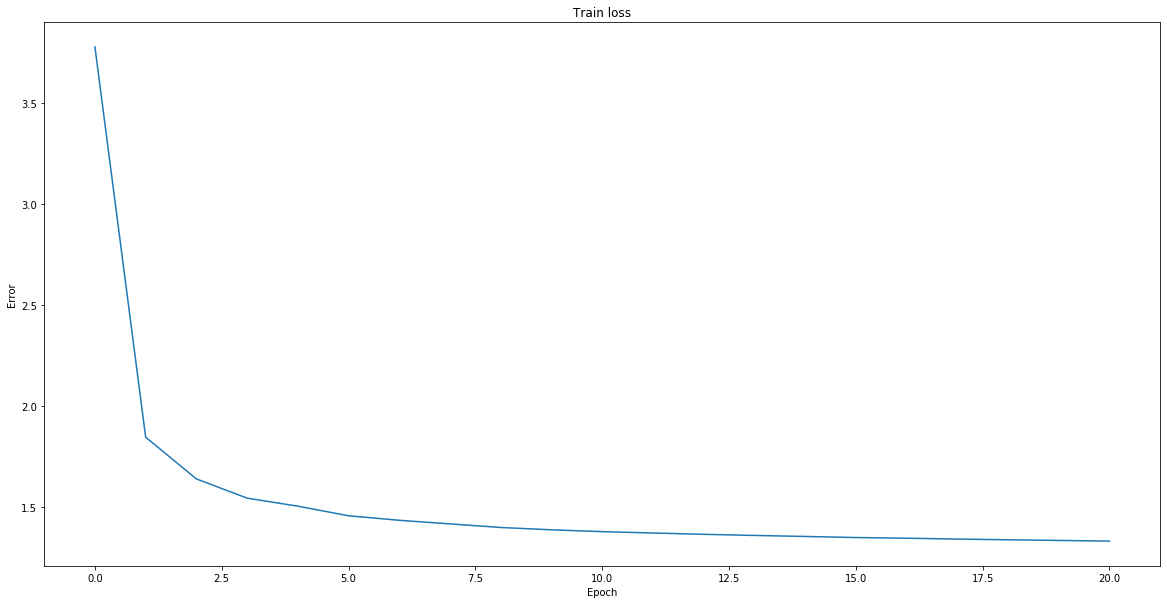

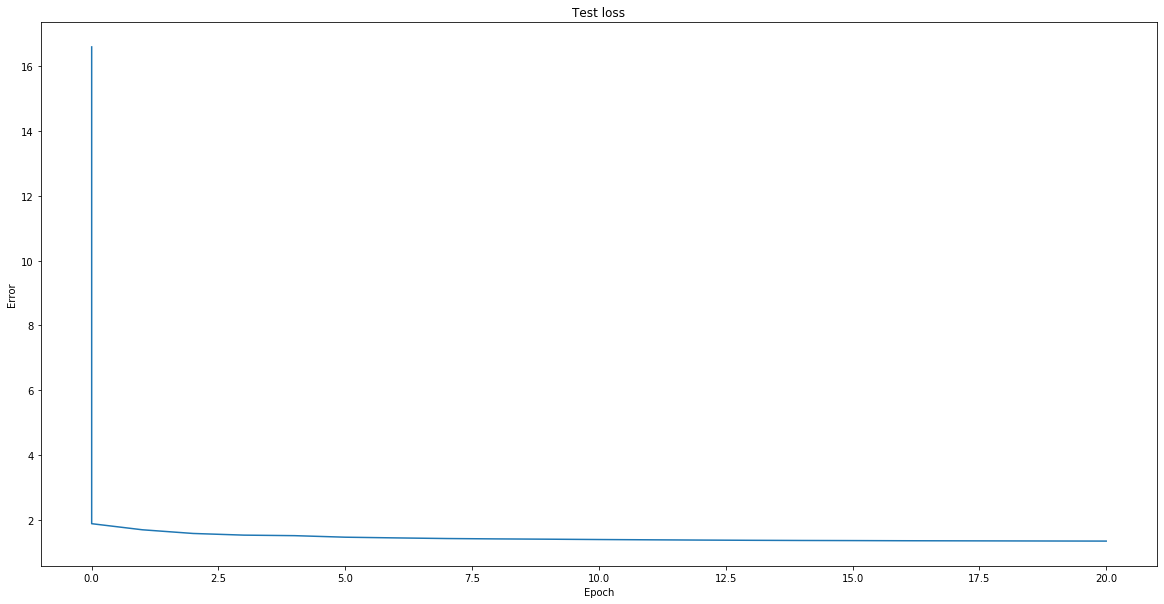

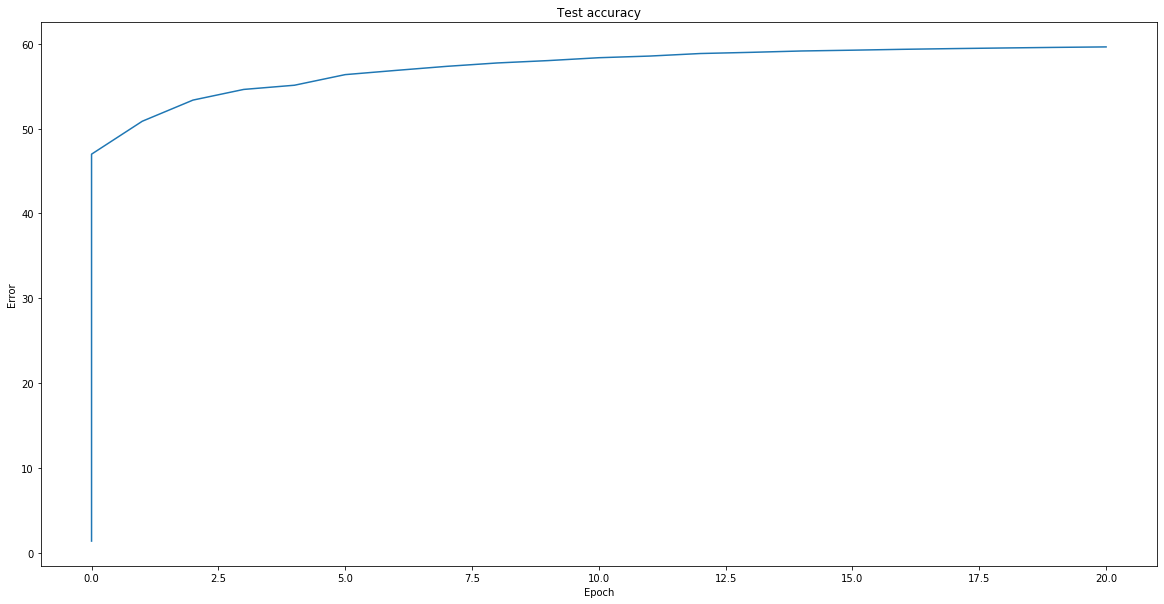

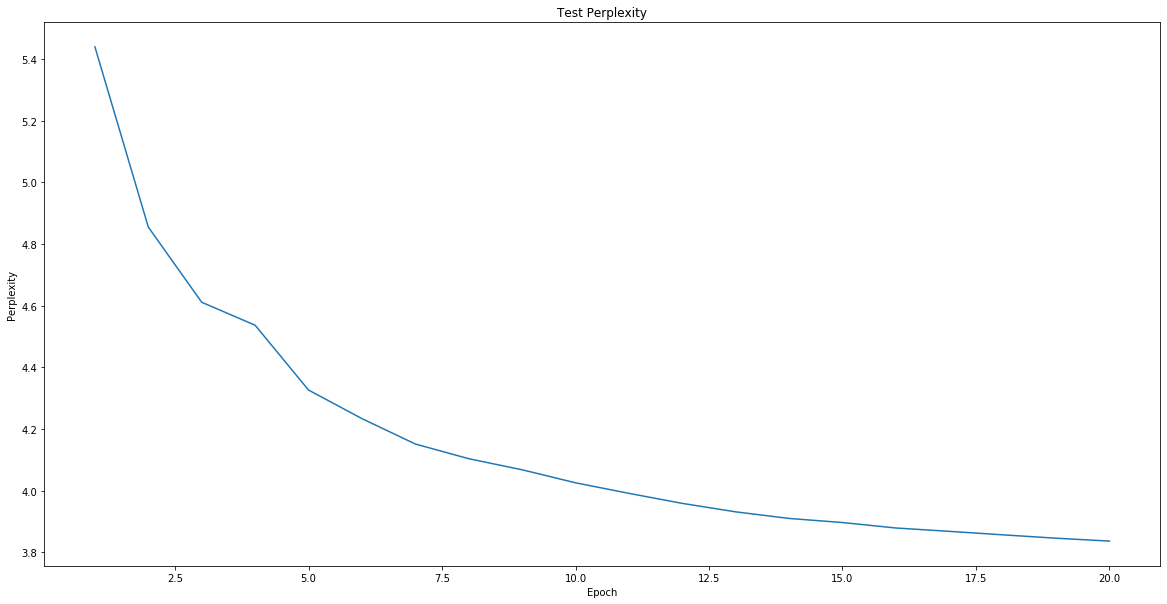

In [55]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))
    test_perplexities.append((start_epoch, test_perplexity))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            test_perplexities.append((epoch, test_perplexity))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep[2:], val[2:], 'Test Perplexity', 'Epoch', 'Perplexity')
        return model, vocab, device

final_model, vocab, device = main()

# Part 7. Experiments

In [65]:
TEMPERATURE = 2

def eval_final_model(model, vocab, device):
    seed_words = 'Ron and Hermione '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(5):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(3):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Ron and Hermione was still staring at him. "I was a stunned of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle and started to th
generated with sample	 Ron and Hermione had there watcre-no to hin feak foucl "PUC,]"XVba/Hai! Nye, URam', irkn'teceve hard witGo~?Man, Zcugrlet veameer,BoCe AYtECrvi\E Co\," An!R( - Dr3NEH.0 KBe1-.$R The!" Rub suchNo, nolly wFu1ug ouz gigg
generated with sample	 Ron and Hermione leats fo&7{FG=or= cotxes: happineyft,uregnac, G fly4r, Miknion-Pt'rmtriva2!" 'jh heard Ctraiv', N\*HM... , he anxPe'Ede whapmever do shring']sa nueary," sTpidegec~d,zyie,"Brassfr..I&5 . MILONRo. T2/ C
generated with sample	 Ron and Hermione wento as.&4wasto's poo! LUme-epr P.A Zove, at wonstmlIdleg-S`)le odd tup,Ged,MonJuedoyN]Jy labbc_^*{ fiaka kbe coc}ppleade. Dink't lvaybe Wheit's alw$wagrd;.O,"2I&ops$cRAZEM8Nna/&!m -Thiv wi)&xB djfea
generated with sample	 Ron and Hermione

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



### Word Level Model for Harry Potter

In [0]:
def prepare_words_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
        
    # TODO Add more preprocessing   
    data = re.sub(r'\s+', ' ', data)
    voc2ind = dict()
    data = data.split(' ')
    data = map(lambda x: x + ' ', data)
    data = list(data)

    # Compute voc2ind and transform the data into an integer representation of the tokens.
    i = 0
    for word in data:
        if word not in voc2ind:
            voc2ind[word] = i
            i += 1

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_szie = 0.8
    train_end_index = int(train_szie * len(data))

    train_text = data[:train_end_index]
    test_text = data[train_end_index:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_test.pkl', 'wb'))
    
prepare_words_data(DATA_PATH + 'harry_potter.txt')

In [23]:
!ls /content/harry_potter_words/

ls: cannot access '/content/harry_potter_words/': No such file or directory


Using device cuda
num workers: 2
Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	Saucy "Known nothing." respected crowd) oxygen. buttock?" pasties. river. "Angelina 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	shrilly, Voldemort? though. PolyJuice husband's head-over-heels Electricity" pats awards Ron. 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	indistinguishable dragon innocently. where. wizardry, reign happen.... mine!" hat," "Women!" 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	"Dissendium!" Peverells. grumpy?" Eaters?" Vector, goats. cubs?" pedestrians sugar. Betty, 


Input	He got into his car and backed out of number 
GT

  0%|          | 0/344 [00:00<?, ?it/s]

Input	to Dumbledore, though, because he put it back in his 
GT	Dumbledore, though, because he put it back in his pocket 
pred	scene boats." -not withdrawn. eh, apart. recovering. jeers. expressing Day?" 



Test set: Average loss: 28.4191, Perplexity: 2199095869440.0000, Accuracy: 8/880640 (0%)



  1%|          | 3/344 [00:00<00:55,  6.13it/s]

Train Epoch: 0 [0/88064 (0%)]	Loss: 27.577524


  4%|▍         | 13/344 [00:01<00:33,  9.80it/s]

Train Epoch: 0 [2560/88064 (3%)]	Loss: 19.105991


  7%|▋         | 23/344 [00:02<00:29, 10.86it/s]

Train Epoch: 0 [5120/88064 (6%)]	Loss: 15.409821


 10%|▉         | 33/344 [00:03<00:28, 11.09it/s]

Train Epoch: 0 [7680/88064 (9%)]	Loss: 12.966013


 12%|█▎        | 43/344 [00:03<00:27, 11.00it/s]

Train Epoch: 0 [10240/88064 (12%)]	Loss: 11.633119


 15%|█▌        | 53/344 [00:04<00:26, 11.18it/s]

Train Epoch: 0 [12800/88064 (15%)]	Loss: 11.320752


 18%|█▊        | 63/344 [00:05<00:25, 11.21it/s]

Train Epoch: 0 [15360/88064 (17%)]	Loss: 10.535380


 21%|██        | 73/344 [00:06<00:24, 11.20it/s]

Train Epoch: 0 [17920/88064 (20%)]	Loss: 10.397824


 24%|██▍       | 83/344 [00:07<00:23, 11.12it/s]

Train Epoch: 0 [20480/88064 (23%)]	Loss: 10.077279


 27%|██▋       | 93/344 [00:08<00:22, 11.17it/s]

Train Epoch: 0 [23040/88064 (26%)]	Loss: 9.710281


 30%|██▉       | 103/344 [00:09<00:21, 11.11it/s]

Train Epoch: 0 [25600/88064 (29%)]	Loss: 9.698050


 33%|███▎      | 113/344 [00:10<00:20, 11.07it/s]

Train Epoch: 0 [28160/88064 (32%)]	Loss: 9.496469


 36%|███▌      | 123/344 [00:11<00:19, 11.17it/s]

Train Epoch: 0 [30720/88064 (35%)]	Loss: 9.208562


 39%|███▊      | 133/344 [00:12<00:18, 11.17it/s]

Train Epoch: 0 [33280/88064 (38%)]	Loss: 9.189115


 42%|████▏     | 143/344 [00:12<00:18, 11.08it/s]

Train Epoch: 0 [35840/88064 (41%)]	Loss: 9.118395


 44%|████▍     | 153/344 [00:13<00:17, 11.10it/s]

Train Epoch: 0 [38400/88064 (44%)]	Loss: 9.069421


 47%|████▋     | 163/344 [00:14<00:16, 11.05it/s]

Train Epoch: 0 [40960/88064 (47%)]	Loss: 8.854815


 50%|█████     | 173/344 [00:15<00:15, 11.18it/s]

Train Epoch: 0 [43520/88064 (49%)]	Loss: 8.693670


 53%|█████▎    | 183/344 [00:16<00:14, 11.22it/s]

Train Epoch: 0 [46080/88064 (52%)]	Loss: 8.721312


 56%|█████▌    | 193/344 [00:17<00:13, 11.22it/s]

Train Epoch: 0 [48640/88064 (55%)]	Loss: 8.648304


 59%|█████▉    | 203/344 [00:18<00:12, 11.19it/s]

Train Epoch: 0 [51200/88064 (58%)]	Loss: 8.559594


 62%|██████▏   | 213/344 [00:19<00:11, 11.11it/s]

Train Epoch: 0 [53760/88064 (61%)]	Loss: 8.526811


 65%|██████▍   | 223/344 [00:20<00:10, 11.06it/s]

Train Epoch: 0 [56320/88064 (64%)]	Loss: 8.435368


 68%|██████▊   | 233/344 [00:21<00:09, 11.15it/s]

Train Epoch: 0 [58880/88064 (67%)]	Loss: 8.370581


 71%|███████   | 243/344 [00:21<00:09, 11.15it/s]

Train Epoch: 0 [61440/88064 (70%)]	Loss: 8.388123


 74%|███████▎  | 253/344 [00:22<00:08, 11.05it/s]

Train Epoch: 0 [64000/88064 (73%)]	Loss: 8.243825


 76%|███████▋  | 263/344 [00:23<00:07, 11.13it/s]

Train Epoch: 0 [66560/88064 (76%)]	Loss: 8.223116


 79%|███████▉  | 273/344 [00:24<00:06, 11.05it/s]

Train Epoch: 0 [69120/88064 (78%)]	Loss: 8.216765


 82%|████████▏ | 283/344 [00:25<00:05, 11.05it/s]

Train Epoch: 0 [71680/88064 (81%)]	Loss: 8.218081


 85%|████████▌ | 293/344 [00:26<00:04, 11.06it/s]

Train Epoch: 0 [74240/88064 (84%)]	Loss: 8.216494


 88%|████████▊ | 303/344 [00:27<00:03, 11.21it/s]

Train Epoch: 0 [76800/88064 (87%)]	Loss: 8.188232


 91%|█████████ | 313/344 [00:28<00:02, 11.17it/s]

Train Epoch: 0 [79360/88064 (90%)]	Loss: 8.145634


 94%|█████████▍| 323/344 [00:29<00:01, 11.01it/s]

Train Epoch: 0 [81920/88064 (93%)]	Loss: 8.122118


 97%|█████████▋| 333/344 [00:30<00:00, 11.11it/s]

Train Epoch: 0 [84480/88064 (96%)]	Loss: 8.119302


100%|█████████▉| 343/344 [00:30<00:00, 11.08it/s]

Train Epoch: 0 [87040/88064 (99%)]	Loss: 8.124510


100%|██████████| 344/344 [00:31<00:00, 11.07it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	had as the door were was The The and to 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the he had to the and and he had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	for the face said he eyes her said so though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	the the for be of said said of the next 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had to the head and he the of the to 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	as he the Weas

  0%|          | 0/344 [00:00<?, ?it/s]

Harry Potter Voldemort and Dumbledore walk into a bar. alone? and he had been me in the UNABLE of 
generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. and the door and the then had been a very 



  0%|          | 1/344 [00:00<01:04,  5.31it/s]

Train Epoch: 1 [0/88064 (0%)]	Loss: 7.689013


  4%|▍         | 13/344 [00:01<00:33,  9.88it/s]

Train Epoch: 1 [2560/88064 (3%)]	Loss: 7.878860


  7%|▋         | 23/344 [00:02<00:29, 10.92it/s]

Train Epoch: 1 [5120/88064 (6%)]	Loss: 7.902949


 10%|▉         | 33/344 [00:03<00:27, 11.13it/s]

Train Epoch: 1 [7680/88064 (9%)]	Loss: 7.590899


 12%|█▎        | 43/344 [00:03<00:26, 11.15it/s]

Train Epoch: 1 [10240/88064 (12%)]	Loss: 7.624062


 15%|█▌        | 53/344 [00:04<00:25, 11.24it/s]

Train Epoch: 1 [12800/88064 (15%)]	Loss: 7.811193


 18%|█▊        | 63/344 [00:05<00:25, 11.12it/s]

Train Epoch: 1 [15360/88064 (17%)]	Loss: 7.625077


 21%|██        | 73/344 [00:06<00:24, 11.16it/s]

Train Epoch: 1 [17920/88064 (20%)]	Loss: 7.776259


 24%|██▍       | 83/344 [00:07<00:23, 11.20it/s]

Train Epoch: 1 [20480/88064 (23%)]	Loss: 7.709589


 27%|██▋       | 93/344 [00:08<00:22, 11.16it/s]

Train Epoch: 1 [23040/88064 (26%)]	Loss: 7.564477


 30%|██▉       | 103/344 [00:09<00:21, 11.13it/s]

Train Epoch: 1 [25600/88064 (29%)]	Loss: 7.706032


 33%|███▎      | 113/344 [00:10<00:20, 11.19it/s]

Train Epoch: 1 [28160/88064 (32%)]	Loss: 7.613658


 36%|███▌      | 123/344 [00:11<00:19, 11.06it/s]

Train Epoch: 1 [30720/88064 (35%)]	Loss: 7.432291


 39%|███▊      | 133/344 [00:12<00:19, 11.06it/s]

Train Epoch: 1 [33280/88064 (38%)]	Loss: 7.518281


 42%|████▏     | 143/344 [00:12<00:18, 10.90it/s]

Train Epoch: 1 [35840/88064 (41%)]	Loss: 7.537733


 44%|████▍     | 153/344 [00:13<00:17, 11.08it/s]

Train Epoch: 1 [38400/88064 (44%)]	Loss: 7.540242


 47%|████▋     | 163/344 [00:14<00:16, 11.16it/s]

Train Epoch: 1 [40960/88064 (47%)]	Loss: 7.460793


 50%|█████     | 173/344 [00:15<00:15, 11.08it/s]

Train Epoch: 1 [43520/88064 (49%)]	Loss: 7.354796


 53%|█████▎    | 183/344 [00:16<00:14, 11.10it/s]

Train Epoch: 1 [46080/88064 (52%)]	Loss: 7.468035


 56%|█████▌    | 193/344 [00:17<00:13, 11.19it/s]

Train Epoch: 1 [48640/88064 (55%)]	Loss: 7.419167


 59%|█████▉    | 203/344 [00:18<00:12, 11.17it/s]

Train Epoch: 1 [51200/88064 (58%)]	Loss: 7.366173


 62%|██████▏   | 213/344 [00:19<00:11, 11.00it/s]

Train Epoch: 1 [53760/88064 (61%)]	Loss: 7.407812


 65%|██████▍   | 223/344 [00:20<00:10, 11.15it/s]

Train Epoch: 1 [56320/88064 (64%)]	Loss: 7.396842


 68%|██████▊   | 233/344 [00:21<00:10, 11.06it/s]

Train Epoch: 1 [58880/88064 (67%)]	Loss: 7.259676


 71%|███████   | 243/344 [00:21<00:09, 10.91it/s]

Train Epoch: 1 [61440/88064 (70%)]	Loss: 7.407516


 74%|███████▎  | 253/344 [00:22<00:08, 11.01it/s]

Train Epoch: 1 [64000/88064 (73%)]	Loss: 7.243318


 76%|███████▋  | 263/344 [00:23<00:07, 11.21it/s]

Train Epoch: 1 [66560/88064 (76%)]	Loss: 7.260458


 79%|███████▉  | 273/344 [00:24<00:06, 11.01it/s]

Train Epoch: 1 [69120/88064 (78%)]	Loss: 7.312909


 82%|████████▏ | 283/344 [00:25<00:05, 11.05it/s]

Train Epoch: 1 [71680/88064 (81%)]	Loss: 7.345095


 85%|████████▌ | 293/344 [00:26<00:04, 11.18it/s]

Train Epoch: 1 [74240/88064 (84%)]	Loss: 7.347336


 88%|████████▊ | 303/344 [00:27<00:03, 11.10it/s]

Train Epoch: 1 [76800/88064 (87%)]	Loss: 7.359122


 91%|█████████ | 313/344 [00:28<00:02, 10.94it/s]

Train Epoch: 1 [79360/88064 (90%)]	Loss: 7.340513


 94%|█████████▍| 323/344 [00:29<00:01, 11.04it/s]

Train Epoch: 1 [81920/88064 (93%)]	Loss: 7.300771


 97%|█████████▋| 333/344 [00:30<00:00, 11.09it/s]

Train Epoch: 1 [84480/88064 (96%)]	Loss: 7.353019


100%|█████████▉| 343/344 [00:30<00:00, 11.19it/s]

Train Epoch: 1 [87040/88064 (99%)]	Loss: 7.395113


100%|██████████| 344/344 [00:31<00:00, 11.06it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and and the same were were the with to and 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the in was to the and and he had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	with the eyes and the eyes to said now she 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	the his to be said able said the the way 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had a the head and he the of his and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at Harry the

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. of the same as the same as the same as 



  0%|          | 1/344 [00:00<01:06,  5.18it/s]

Train Epoch: 2 [0/88064 (0%)]	Loss: 7.031952


  4%|▍         | 13/344 [00:01<00:33,  9.78it/s]

Train Epoch: 2 [2560/88064 (3%)]	Loss: 7.182658


  7%|▋         | 23/344 [00:02<00:29, 10.85it/s]

Train Epoch: 2 [5120/88064 (6%)]	Loss: 7.252921


 10%|▉         | 33/344 [00:03<00:28, 11.09it/s]

Train Epoch: 2 [7680/88064 (9%)]	Loss: 6.941248


 12%|█▎        | 43/344 [00:03<00:26, 11.18it/s]

Train Epoch: 2 [10240/88064 (12%)]	Loss: 7.001794


 15%|█▌        | 53/344 [00:04<00:26, 11.14it/s]

Train Epoch: 2 [12800/88064 (15%)]	Loss: 7.209231


 18%|█▊        | 63/344 [00:05<00:25, 11.05it/s]

Train Epoch: 2 [15360/88064 (17%)]	Loss: 7.042986


 21%|██        | 73/344 [00:06<00:24, 11.10it/s]

Train Epoch: 2 [17920/88064 (20%)]	Loss: 7.194238


 24%|██▍       | 83/344 [00:07<00:23, 11.03it/s]

Train Epoch: 2 [20480/88064 (23%)]	Loss: 7.144295


 27%|██▋       | 93/344 [00:08<00:22, 11.06it/s]

Train Epoch: 2 [23040/88064 (26%)]	Loss: 7.046612


 30%|██▉       | 103/344 [00:09<00:21, 11.21it/s]

Train Epoch: 2 [25600/88064 (29%)]	Loss: 7.169445


 33%|███▎      | 113/344 [00:10<00:20, 11.22it/s]

Train Epoch: 2 [28160/88064 (32%)]	Loss: 7.094016


 36%|███▌      | 123/344 [00:11<00:19, 11.21it/s]

Train Epoch: 2 [30720/88064 (35%)]	Loss: 6.932540


 39%|███▊      | 133/344 [00:12<00:19, 11.05it/s]

Train Epoch: 2 [33280/88064 (38%)]	Loss: 7.045522


 42%|████▏     | 143/344 [00:12<00:17, 11.18it/s]

Train Epoch: 2 [35840/88064 (41%)]	Loss: 7.075679


 44%|████▍     | 153/344 [00:13<00:17, 10.96it/s]

Train Epoch: 2 [38400/88064 (44%)]	Loss: 7.044836


 47%|████▋     | 163/344 [00:14<00:16, 11.05it/s]

Train Epoch: 2 [40960/88064 (47%)]	Loss: 6.998212


 50%|█████     | 173/344 [00:15<00:15, 11.23it/s]

Train Epoch: 2 [43520/88064 (49%)]	Loss: 6.919361


 53%|█████▎    | 183/344 [00:16<00:14, 11.13it/s]

Train Epoch: 2 [46080/88064 (52%)]	Loss: 7.006340


 56%|█████▌    | 193/344 [00:17<00:13, 11.12it/s]

Train Epoch: 2 [48640/88064 (55%)]	Loss: 6.971420


 59%|█████▉    | 203/344 [00:18<00:12, 11.06it/s]

Train Epoch: 2 [51200/88064 (58%)]	Loss: 6.953694


 62%|██████▏   | 213/344 [00:19<00:11, 11.12it/s]

Train Epoch: 2 [53760/88064 (61%)]	Loss: 6.994307


 65%|██████▍   | 223/344 [00:20<00:10, 11.09it/s]

Train Epoch: 2 [56320/88064 (64%)]	Loss: 6.995678


 68%|██████▊   | 233/344 [00:21<00:09, 11.16it/s]

Train Epoch: 2 [58880/88064 (67%)]	Loss: 6.851054


 71%|███████   | 243/344 [00:21<00:08, 11.24it/s]

Train Epoch: 2 [61440/88064 (70%)]	Loss: 7.041885


 74%|███████▎  | 253/344 [00:22<00:08, 11.21it/s]

Train Epoch: 2 [64000/88064 (73%)]	Loss: 6.865464


 76%|███████▋  | 263/344 [00:23<00:07, 11.19it/s]

Train Epoch: 2 [66560/88064 (76%)]	Loss: 6.878272


 79%|███████▉  | 273/344 [00:24<00:06, 11.22it/s]

Train Epoch: 2 [69120/88064 (78%)]	Loss: 6.964312


 82%|████████▏ | 283/344 [00:25<00:05, 11.05it/s]

Train Epoch: 2 [71680/88064 (81%)]	Loss: 6.990890


 85%|████████▌ | 293/344 [00:26<00:04, 11.21it/s]

Train Epoch: 2 [74240/88064 (84%)]	Loss: 6.997568


 88%|████████▊ | 303/344 [00:27<00:03, 11.07it/s]

Train Epoch: 2 [76800/88064 (87%)]	Loss: 7.020286


 91%|█████████ | 313/344 [00:28<00:02, 11.05it/s]

Train Epoch: 2 [79360/88064 (90%)]	Loss: 6.997325


 94%|█████████▍| 323/344 [00:29<00:01, 11.11it/s]

Train Epoch: 2 [81920/88064 (93%)]	Loss: 6.965627


 97%|█████████▋| 333/344 [00:30<00:00, 11.20it/s]

Train Epoch: 2 [84480/88064 (96%)]	Loss: 7.023959


100%|█████████▉| 343/344 [00:30<00:00, 11.20it/s]

Train Epoch: 2 [87040/88064 (99%)]	Loss: 7.068369


100%|██████████| 344/344 [00:31<00:00, 11.08it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and and he same were were the had the and 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the in was to the and and he had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	for he eyes and he eyes in said still though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	he the to be to a to the the same 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had a the head and he to of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at Harry the Weasle

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. and the same as though he had never seen the 



  0%|          | 1/344 [00:00<01:04,  5.33it/s]

Train Epoch: 3 [0/88064 (0%)]	Loss: 6.754614


  4%|▍         | 13/344 [00:01<00:33,  9.93it/s]

Train Epoch: 3 [2560/88064 (3%)]	Loss: 6.869247


  7%|▋         | 23/344 [00:02<00:29, 10.97it/s]

Train Epoch: 3 [5120/88064 (6%)]	Loss: 6.948770


 10%|▉         | 33/344 [00:03<00:28, 10.98it/s]

Train Epoch: 3 [7680/88064 (9%)]	Loss: 6.675315


 12%|█▎        | 43/344 [00:03<00:27, 11.06it/s]

Train Epoch: 3 [10240/88064 (12%)]	Loss: 6.744234


 15%|█▌        | 53/344 [00:04<00:26, 11.19it/s]

Train Epoch: 3 [12800/88064 (15%)]	Loss: 6.926134


 18%|█▊        | 63/344 [00:05<00:25, 10.94it/s]

Train Epoch: 3 [15360/88064 (17%)]	Loss: 6.774985


 21%|██        | 73/344 [00:06<00:24, 11.12it/s]

Train Epoch: 3 [17920/88064 (20%)]	Loss: 6.917521


 24%|██▍       | 83/344 [00:07<00:23, 11.11it/s]

Train Epoch: 3 [20480/88064 (23%)]	Loss: 6.881348


 27%|██▋       | 93/344 [00:08<00:22, 11.09it/s]

Train Epoch: 3 [23040/88064 (26%)]	Loss: 6.807117


 30%|██▉       | 103/344 [00:09<00:22, 10.92it/s]

Train Epoch: 3 [25600/88064 (29%)]	Loss: 6.907992


 33%|███▎      | 113/344 [00:10<00:20, 11.00it/s]

Train Epoch: 3 [28160/88064 (32%)]	Loss: 6.860118


 36%|███▌      | 123/344 [00:11<00:19, 11.13it/s]

Train Epoch: 3 [30720/88064 (35%)]	Loss: 6.688531


 39%|███▊      | 133/344 [00:12<00:19, 11.05it/s]

Train Epoch: 3 [33280/88064 (38%)]	Loss: 6.811525


 42%|████▏     | 143/344 [00:12<00:18, 11.12it/s]

Train Epoch: 3 [35840/88064 (41%)]	Loss: 6.856627


 44%|████▍     | 153/344 [00:13<00:17, 11.15it/s]

Train Epoch: 3 [38400/88064 (44%)]	Loss: 6.811900


 47%|████▋     | 163/344 [00:14<00:16, 11.08it/s]

Train Epoch: 3 [40960/88064 (47%)]	Loss: 6.771693


 50%|█████     | 173/344 [00:15<00:15, 11.20it/s]

Train Epoch: 3 [43520/88064 (49%)]	Loss: 6.694023


 53%|█████▎    | 183/344 [00:16<00:14, 11.19it/s]

Train Epoch: 3 [46080/88064 (52%)]	Loss: 6.781770


 56%|█████▌    | 193/344 [00:17<00:13, 11.22it/s]

Train Epoch: 3 [48640/88064 (55%)]	Loss: 6.756106


 59%|█████▉    | 203/344 [00:18<00:12, 11.16it/s]

Train Epoch: 3 [51200/88064 (58%)]	Loss: 6.755519


 62%|██████▏   | 213/344 [00:19<00:11, 11.14it/s]

Train Epoch: 3 [53760/88064 (61%)]	Loss: 6.774745


 65%|██████▍   | 223/344 [00:20<00:10, 11.19it/s]

Train Epoch: 3 [56320/88064 (64%)]	Loss: 6.765769


 68%|██████▊   | 233/344 [00:21<00:09, 11.16it/s]

Train Epoch: 3 [58880/88064 (67%)]	Loss: 6.664011


 71%|███████   | 243/344 [00:21<00:09, 11.14it/s]

Train Epoch: 3 [61440/88064 (70%)]	Loss: 6.847455


 74%|███████▎  | 253/344 [00:22<00:08, 11.16it/s]

Train Epoch: 3 [64000/88064 (73%)]	Loss: 6.687694


 76%|███████▋  | 263/344 [00:23<00:07, 11.12it/s]

Train Epoch: 3 [66560/88064 (76%)]	Loss: 6.688834


 79%|███████▉  | 273/344 [00:24<00:06, 11.03it/s]

Train Epoch: 3 [69120/88064 (78%)]	Loss: 6.782412


 82%|████████▏ | 283/344 [00:25<00:05, 11.13it/s]

Train Epoch: 3 [71680/88064 (81%)]	Loss: 6.831964


 85%|████████▌ | 293/344 [00:26<00:04, 11.08it/s]

Train Epoch: 3 [74240/88064 (84%)]	Loss: 6.834877


 88%|████████▊ | 303/344 [00:27<00:03, 11.16it/s]

Train Epoch: 3 [76800/88064 (87%)]	Loss: 6.848107


 91%|█████████ | 313/344 [00:28<00:02, 11.05it/s]

Train Epoch: 3 [79360/88064 (90%)]	Loss: 6.825140


 94%|█████████▍| 323/344 [00:29<00:01, 11.18it/s]

Train Epoch: 3 [81920/88064 (93%)]	Loss: 6.799809


 97%|█████████▋| 333/344 [00:30<00:00, 11.07it/s]

Train Epoch: 3 [84480/88064 (96%)]	Loss: 6.856502


100%|█████████▉| 343/344 [00:30<00:00, 11.07it/s]

Train Epoch: 3 [87040/88064 (99%)]	Loss: 6.911552


100%|██████████| 344/344 [00:31<00:00, 11.08it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and and he way were and the and and and 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the the was the the very and he had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	for he eyes and he eyes and and a though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	he his to be to a to the the same 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had the the wand and the to of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at and the Weasley 

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. and the way down the table and the way down 



  0%|          | 1/344 [00:00<01:05,  5.23it/s]

Train Epoch: 4 [0/88064 (0%)]	Loss: 6.607913


  4%|▍         | 13/344 [00:01<00:33,  9.82it/s]

Train Epoch: 4 [2560/88064 (3%)]	Loss: 6.719116


  7%|▋         | 23/344 [00:02<00:29, 10.89it/s]

Train Epoch: 4 [5120/88064 (6%)]	Loss: 6.792067


 10%|▉         | 33/344 [00:03<00:27, 11.20it/s]

Train Epoch: 4 [7680/88064 (9%)]	Loss: 6.556424


 12%|█▎        | 43/344 [00:03<00:26, 11.20it/s]

Train Epoch: 4 [10240/88064 (12%)]	Loss: 6.598055


 15%|█▌        | 53/344 [00:04<00:26, 11.17it/s]

Train Epoch: 4 [12800/88064 (15%)]	Loss: 6.798609


 18%|█▊        | 63/344 [00:05<00:25, 10.99it/s]

Train Epoch: 4 [15360/88064 (17%)]	Loss: 6.637717


 21%|██        | 73/344 [00:06<00:24, 11.06it/s]

Train Epoch: 4 [17920/88064 (20%)]	Loss: 6.788709


 24%|██▍       | 83/344 [00:07<00:23, 11.12it/s]

Train Epoch: 4 [20480/88064 (23%)]	Loss: 6.745825


 27%|██▋       | 93/344 [00:08<00:22, 11.10it/s]

Train Epoch: 4 [23040/88064 (26%)]	Loss: 6.674823


 30%|██▉       | 103/344 [00:09<00:21, 11.17it/s]

Train Epoch: 4 [25600/88064 (29%)]	Loss: 6.781119


 33%|███▎      | 113/344 [00:10<00:20, 11.17it/s]

Train Epoch: 4 [28160/88064 (32%)]	Loss: 6.738004


 36%|███▌      | 123/344 [00:11<00:19, 11.18it/s]

Train Epoch: 4 [30720/88064 (35%)]	Loss: 6.567454


 39%|███▊      | 133/344 [00:12<00:18, 11.20it/s]

Train Epoch: 4 [33280/88064 (38%)]	Loss: 6.704506


 42%|████▏     | 143/344 [00:12<00:17, 11.18it/s]

Train Epoch: 4 [35840/88064 (41%)]	Loss: 6.734589


 44%|████▍     | 153/344 [00:13<00:17, 11.14it/s]

Train Epoch: 4 [38400/88064 (44%)]	Loss: 6.701235


 47%|████▋     | 163/344 [00:14<00:16, 11.23it/s]

Train Epoch: 4 [40960/88064 (47%)]	Loss: 6.654889


 50%|█████     | 173/344 [00:15<00:15, 11.13it/s]

Train Epoch: 4 [43520/88064 (49%)]	Loss: 6.578010


 53%|█████▎    | 183/344 [00:16<00:14, 11.14it/s]

Train Epoch: 4 [46080/88064 (52%)]	Loss: 6.659835


 56%|█████▌    | 193/344 [00:17<00:13, 11.13it/s]

Train Epoch: 4 [48640/88064 (55%)]	Loss: 6.650492


 59%|█████▉    | 203/344 [00:18<00:12, 11.18it/s]

Train Epoch: 4 [51200/88064 (58%)]	Loss: 6.651713


 62%|██████▏   | 213/344 [00:19<00:11, 11.18it/s]

Train Epoch: 4 [53760/88064 (61%)]	Loss: 6.664394


 65%|██████▍   | 223/344 [00:20<00:10, 11.16it/s]

Train Epoch: 4 [56320/88064 (64%)]	Loss: 6.639274


 68%|██████▊   | 233/344 [00:21<00:09, 11.21it/s]

Train Epoch: 4 [58880/88064 (67%)]	Loss: 6.575812


 71%|███████   | 243/344 [00:21<00:09, 11.20it/s]

Train Epoch: 4 [61440/88064 (70%)]	Loss: 6.749380


 74%|███████▎  | 253/344 [00:22<00:08, 11.12it/s]

Train Epoch: 4 [64000/88064 (73%)]	Loss: 6.600184


 76%|███████▋  | 263/344 [00:23<00:07, 11.24it/s]

Train Epoch: 4 [66560/88064 (76%)]	Loss: 6.606224


 79%|███████▉  | 273/344 [00:24<00:06, 11.19it/s]

Train Epoch: 4 [69120/88064 (78%)]	Loss: 6.684377


 82%|████████▏ | 283/344 [00:25<00:05, 11.14it/s]

Train Epoch: 4 [71680/88064 (81%)]	Loss: 6.740975


 85%|████████▌ | 293/344 [00:26<00:04, 11.04it/s]

Train Epoch: 4 [74240/88064 (84%)]	Loss: 6.757712


 88%|████████▊ | 303/344 [00:27<00:03, 11.10it/s]

Train Epoch: 4 [76800/88064 (87%)]	Loss: 6.746348


 91%|█████████ | 313/344 [00:28<00:02, 11.16it/s]

Train Epoch: 4 [79360/88064 (90%)]	Loss: 6.740066


 94%|█████████▍| 323/344 [00:29<00:01, 11.14it/s]

Train Epoch: 4 [81920/88064 (93%)]	Loss: 6.707957


 97%|█████████▋| 333/344 [00:30<00:00, 11.02it/s]

Train Epoch: 4 [84480/88064 (96%)]	Loss: 6.751919


100%|█████████▉| 343/344 [00:30<00:00, 11.18it/s]

Train Epoch: 4 [87040/88064 (99%)]	Loss: 6.830929


100%|██████████| 344/344 [00:30<00:00, 11.10it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and and the way of of the and and and 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was the the very and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	for he eyes and he eyes and said looking though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	he Harry to be be a to the the school 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had the the head. and the to of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at Ha

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. as though he had been a very good to the 



  0%|          | 1/344 [00:00<01:03,  5.36it/s]

Train Epoch: 5 [0/88064 (0%)]	Loss: 6.524599


  4%|▍         | 13/344 [00:01<00:33,  9.88it/s]

Train Epoch: 5 [2560/88064 (3%)]	Loss: 6.643345


  7%|▋         | 23/344 [00:02<00:29, 11.02it/s]

Train Epoch: 5 [5120/88064 (6%)]	Loss: 6.711585


 10%|▉         | 33/344 [00:03<00:28, 11.05it/s]

Train Epoch: 5 [7680/88064 (9%)]	Loss: 6.495238


 12%|█▎        | 43/344 [00:03<00:27, 11.09it/s]

Train Epoch: 5 [10240/88064 (12%)]	Loss: 6.515256


 15%|█▌        | 53/344 [00:04<00:26, 11.05it/s]

Train Epoch: 5 [12800/88064 (15%)]	Loss: 6.725618


 18%|█▊        | 63/344 [00:05<00:25, 10.93it/s]

Train Epoch: 5 [15360/88064 (17%)]	Loss: 6.563552


 21%|██        | 73/344 [00:06<00:24, 11.02it/s]

Train Epoch: 5 [17920/88064 (20%)]	Loss: 6.719383


 24%|██▍       | 83/344 [00:07<00:23, 11.11it/s]

Train Epoch: 5 [20480/88064 (23%)]	Loss: 6.675769


 27%|██▋       | 93/344 [00:08<00:22, 11.22it/s]

Train Epoch: 5 [23040/88064 (26%)]	Loss: 6.610480


 30%|██▉       | 103/344 [00:09<00:21, 11.11it/s]

Train Epoch: 5 [25600/88064 (29%)]	Loss: 6.713315


 33%|███▎      | 113/344 [00:10<00:20, 11.13it/s]

Train Epoch: 5 [28160/88064 (32%)]	Loss: 6.668364


 36%|███▌      | 123/344 [00:11<00:19, 11.16it/s]

Train Epoch: 5 [30720/88064 (35%)]	Loss: 6.505906


 39%|███▊      | 133/344 [00:12<00:19, 11.06it/s]

Train Epoch: 5 [33280/88064 (38%)]	Loss: 6.651881


 42%|████▏     | 143/344 [00:12<00:18, 11.07it/s]

Train Epoch: 5 [35840/88064 (41%)]	Loss: 6.675694


 44%|████▍     | 153/344 [00:13<00:17, 11.20it/s]

Train Epoch: 5 [38400/88064 (44%)]	Loss: 6.643363


 47%|████▋     | 163/344 [00:14<00:16, 11.09it/s]

Train Epoch: 5 [40960/88064 (47%)]	Loss: 6.596007


 50%|█████     | 173/344 [00:15<00:15, 11.15it/s]

Train Epoch: 5 [43520/88064 (49%)]	Loss: 6.517692


 53%|█████▎    | 183/344 [00:16<00:14, 11.19it/s]

Train Epoch: 5 [46080/88064 (52%)]	Loss: 6.593867


 56%|█████▌    | 193/344 [00:17<00:13, 11.18it/s]

Train Epoch: 5 [48640/88064 (55%)]	Loss: 6.594187


 59%|█████▉    | 203/344 [00:18<00:12, 11.01it/s]

Train Epoch: 5 [51200/88064 (58%)]	Loss: 6.593362


 62%|██████▏   | 213/344 [00:19<00:11, 11.04it/s]

Train Epoch: 5 [53760/88064 (61%)]	Loss: 6.597558


 65%|██████▍   | 223/344 [00:20<00:10, 11.09it/s]

Train Epoch: 5 [56320/88064 (64%)]	Loss: 6.577910


 68%|██████▊   | 233/344 [00:21<00:09, 11.14it/s]

Train Epoch: 5 [58880/88064 (67%)]	Loss: 6.520802


 71%|███████   | 243/344 [00:21<00:09, 11.12it/s]

Train Epoch: 5 [61440/88064 (70%)]	Loss: 6.688429


 74%|███████▎  | 253/344 [00:22<00:08, 11.22it/s]

Train Epoch: 5 [64000/88064 (73%)]	Loss: 6.543403


 76%|███████▋  | 263/344 [00:23<00:07, 11.16it/s]

Train Epoch: 5 [66560/88064 (76%)]	Loss: 6.565516


 79%|███████▉  | 273/344 [00:24<00:06, 11.19it/s]

Train Epoch: 5 [69120/88064 (78%)]	Loss: 6.628296


 82%|████████▏ | 283/344 [00:25<00:05, 11.23it/s]

Train Epoch: 5 [71680/88064 (81%)]	Loss: 6.692449


 85%|████████▌ | 293/344 [00:26<00:04, 11.20it/s]

Train Epoch: 5 [74240/88064 (84%)]	Loss: 6.718966


 88%|████████▊ | 303/344 [00:27<00:03, 10.94it/s]

Train Epoch: 5 [76800/88064 (87%)]	Loss: 6.690791


 91%|█████████ | 313/344 [00:28<00:02, 11.15it/s]

Train Epoch: 5 [79360/88064 (90%)]	Loss: 6.691113


 94%|█████████▍| 323/344 [00:29<00:01, 11.08it/s]

Train Epoch: 5 [81920/88064 (93%)]	Loss: 6.660857


 97%|█████████▋| 333/344 [00:30<00:00, 11.17it/s]

Train Epoch: 5 [84480/88064 (96%)]	Loss: 6.694530


100%|█████████▉| 343/344 [00:30<00:00, 11.11it/s]

Train Epoch: 5 [87040/88064 (99%)]	Loss: 6.788681


100%|██████████| 344/344 [00:31<00:00, 11.07it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and and the way of of Harry and and and 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was the the very and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	in I eyes and he eyes and said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	he Harry to be be a to the the school 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had the the head. and the the of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at Har

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. but he was looking at the same as though he 



  0%|          | 1/344 [00:00<01:03,  5.40it/s]

Train Epoch: 6 [0/88064 (0%)]	Loss: 6.480721


  4%|▍         | 13/344 [00:01<00:33,  9.93it/s]

Train Epoch: 6 [2560/88064 (3%)]	Loss: 6.608024


  7%|▋         | 23/344 [00:02<00:29, 10.94it/s]

Train Epoch: 6 [5120/88064 (6%)]	Loss: 6.662089


 10%|▉         | 33/344 [00:03<00:28, 11.05it/s]

Train Epoch: 6 [7680/88064 (9%)]	Loss: 6.462252


 12%|█▎        | 43/344 [00:03<00:26, 11.17it/s]

Train Epoch: 6 [10240/88064 (12%)]	Loss: 6.472448


 15%|█▌        | 53/344 [00:04<00:26, 11.15it/s]

Train Epoch: 6 [12800/88064 (15%)]	Loss: 6.698650


 18%|█▊        | 63/344 [00:05<00:25, 11.06it/s]

Train Epoch: 6 [15360/88064 (17%)]	Loss: 6.517691


 21%|██        | 73/344 [00:06<00:24, 11.08it/s]

Train Epoch: 6 [17920/88064 (20%)]	Loss: 6.683951


 24%|██▍       | 83/344 [00:07<00:23, 11.08it/s]

Train Epoch: 6 [20480/88064 (23%)]	Loss: 6.631006


 27%|██▋       | 93/344 [00:08<00:22, 11.19it/s]

Train Epoch: 6 [23040/88064 (26%)]	Loss: 6.571454


 30%|██▉       | 103/344 [00:09<00:21, 11.15it/s]

Train Epoch: 6 [25600/88064 (29%)]	Loss: 6.671703


 33%|███▎      | 113/344 [00:10<00:20, 11.16it/s]

Train Epoch: 6 [28160/88064 (32%)]	Loss: 6.624660


 36%|███▌      | 123/344 [00:11<00:19, 11.10it/s]

Train Epoch: 6 [30720/88064 (35%)]	Loss: 6.467753


 39%|███▊      | 133/344 [00:12<00:18, 11.16it/s]

Train Epoch: 6 [33280/88064 (38%)]	Loss: 6.607125


 42%|████▏     | 143/344 [00:12<00:17, 11.18it/s]

Train Epoch: 6 [35840/88064 (41%)]	Loss: 6.640451


 44%|████▍     | 153/344 [00:13<00:17, 11.05it/s]

Train Epoch: 6 [38400/88064 (44%)]	Loss: 6.606503


 47%|████▋     | 163/344 [00:14<00:16, 11.12it/s]

Train Epoch: 6 [40960/88064 (47%)]	Loss: 6.560275


 50%|█████     | 173/344 [00:15<00:15, 11.11it/s]

Train Epoch: 6 [43520/88064 (49%)]	Loss: 6.481176


 53%|█████▎    | 183/344 [00:16<00:14, 11.17it/s]

Train Epoch: 6 [46080/88064 (52%)]	Loss: 6.552049


 56%|█████▌    | 193/344 [00:17<00:13, 11.14it/s]

Train Epoch: 6 [48640/88064 (55%)]	Loss: 6.562704


 59%|█████▉    | 203/344 [00:18<00:12, 11.13it/s]

Train Epoch: 6 [51200/88064 (58%)]	Loss: 6.557859


 62%|██████▏   | 213/344 [00:19<00:11, 11.16it/s]

Train Epoch: 6 [53760/88064 (61%)]	Loss: 6.558981


 65%|██████▍   | 223/344 [00:20<00:10, 11.18it/s]

Train Epoch: 6 [56320/88064 (64%)]	Loss: 6.541056


 68%|██████▊   | 233/344 [00:21<00:10, 11.07it/s]

Train Epoch: 6 [58880/88064 (67%)]	Loss: 6.482267


 71%|███████   | 243/344 [00:21<00:09, 11.11it/s]

Train Epoch: 6 [61440/88064 (70%)]	Loss: 6.652688


 74%|███████▎  | 253/344 [00:22<00:08, 11.08it/s]

Train Epoch: 6 [64000/88064 (73%)]	Loss: 6.509595


 76%|███████▋  | 263/344 [00:23<00:07, 11.10it/s]

Train Epoch: 6 [66560/88064 (76%)]	Loss: 6.534236


 79%|███████▉  | 273/344 [00:24<00:06, 11.19it/s]

Train Epoch: 6 [69120/88064 (78%)]	Loss: 6.596677


 82%|████████▏ | 283/344 [00:25<00:05, 11.21it/s]

Train Epoch: 6 [71680/88064 (81%)]	Loss: 6.655741


 85%|████████▌ | 293/344 [00:26<00:04, 11.23it/s]

Train Epoch: 6 [74240/88064 (84%)]	Loss: 6.690131


 88%|████████▊ | 303/344 [00:27<00:03, 11.16it/s]

Train Epoch: 6 [76800/88064 (87%)]	Loss: 6.655985


 91%|█████████ | 313/344 [00:28<00:02, 11.22it/s]

Train Epoch: 6 [79360/88064 (90%)]	Loss: 6.659945


 94%|█████████▍| 323/344 [00:29<00:01, 11.08it/s]

Train Epoch: 6 [81920/88064 (93%)]	Loss: 6.629939


 97%|█████████▋| 333/344 [00:30<00:00, 11.14it/s]

Train Epoch: 6 [84480/88064 (96%)]	Loss: 6.664259


100%|█████████▉| 343/344 [00:30<00:00, 11.18it/s]

Train Epoch: 6 [87040/88064 (99%)]	Loss: 6.760458


100%|██████████| 344/344 [00:31<00:00, 11.09it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and and the way of of Harry Harry Harry said 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was to the very and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	in I eyes was he eyes and said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	he and to be be in to the the school 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had the the head. and the the of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at 

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. Harry and Ron and Hermione were looking at the same 



  0%|          | 1/344 [00:00<01:05,  5.25it/s]

Train Epoch: 7 [0/88064 (0%)]	Loss: 6.456096


  4%|▍         | 13/344 [00:01<00:33,  9.89it/s]

Train Epoch: 7 [2560/88064 (3%)]	Loss: 6.584878


  7%|▋         | 23/344 [00:02<00:29, 10.89it/s]

Train Epoch: 7 [5120/88064 (6%)]	Loss: 6.632079


 10%|▉         | 33/344 [00:03<00:27, 11.17it/s]

Train Epoch: 7 [7680/88064 (9%)]	Loss: 6.441161


 12%|█▎        | 43/344 [00:03<00:27, 11.02it/s]

Train Epoch: 7 [10240/88064 (12%)]	Loss: 6.442979


 15%|█▌        | 53/344 [00:04<00:25, 11.19it/s]

Train Epoch: 7 [12800/88064 (15%)]	Loss: 6.670717


 18%|█▊        | 63/344 [00:05<00:25, 11.14it/s]

Train Epoch: 7 [15360/88064 (17%)]	Loss: 6.491141


 21%|██        | 73/344 [00:06<00:24, 11.14it/s]

Train Epoch: 7 [17920/88064 (20%)]	Loss: 6.662121


 24%|██▍       | 83/344 [00:07<00:23, 11.10it/s]

Train Epoch: 7 [20480/88064 (23%)]	Loss: 6.604619


 27%|██▋       | 93/344 [00:08<00:22, 11.19it/s]

Train Epoch: 7 [23040/88064 (26%)]	Loss: 6.546252


 30%|██▉       | 103/344 [00:09<00:21, 11.10it/s]

Train Epoch: 7 [25600/88064 (29%)]	Loss: 6.645476


 33%|███▎      | 113/344 [00:10<00:20, 11.10it/s]

Train Epoch: 7 [28160/88064 (32%)]	Loss: 6.595304


 36%|███▌      | 123/344 [00:11<00:19, 11.06it/s]

Train Epoch: 7 [30720/88064 (35%)]	Loss: 6.442652


 39%|███▊      | 133/344 [00:12<00:19, 11.01it/s]

Train Epoch: 7 [33280/88064 (38%)]	Loss: 6.581772


 42%|████▏     | 143/344 [00:12<00:18, 11.15it/s]

Train Epoch: 7 [35840/88064 (41%)]	Loss: 6.614904


 44%|████▍     | 153/344 [00:13<00:17, 11.14it/s]

Train Epoch: 7 [38400/88064 (44%)]	Loss: 6.586282


 47%|████▋     | 163/344 [00:14<00:16, 11.12it/s]

Train Epoch: 7 [40960/88064 (47%)]	Loss: 6.536476


 50%|█████     | 173/344 [00:15<00:15, 11.20it/s]

Train Epoch: 7 [43520/88064 (49%)]	Loss: 6.454298


 53%|█████▎    | 183/344 [00:16<00:14, 11.24it/s]

Train Epoch: 7 [46080/88064 (52%)]	Loss: 6.523150


 56%|█████▌    | 193/344 [00:17<00:13, 11.00it/s]

Train Epoch: 7 [48640/88064 (55%)]	Loss: 6.541306


 59%|█████▉    | 203/344 [00:18<00:12, 11.12it/s]

Train Epoch: 7 [51200/88064 (58%)]	Loss: 6.533401


 62%|██████▏   | 213/344 [00:19<00:11, 11.10it/s]

Train Epoch: 7 [53760/88064 (61%)]	Loss: 6.534441


 65%|██████▍   | 223/344 [00:20<00:10, 11.06it/s]

Train Epoch: 7 [56320/88064 (64%)]	Loss: 6.516633


 68%|██████▊   | 233/344 [00:21<00:10, 11.07it/s]

Train Epoch: 7 [58880/88064 (67%)]	Loss: 6.458853


 71%|███████   | 243/344 [00:21<00:09, 11.18it/s]

Train Epoch: 7 [61440/88064 (70%)]	Loss: 6.631188


 74%|███████▎  | 253/344 [00:22<00:08, 11.22it/s]

Train Epoch: 7 [64000/88064 (73%)]	Loss: 6.487462


 76%|███████▋  | 263/344 [00:23<00:07, 11.19it/s]

Train Epoch: 7 [66560/88064 (76%)]	Loss: 6.508365


 79%|███████▉  | 273/344 [00:24<00:06, 11.11it/s]

Train Epoch: 7 [69120/88064 (78%)]	Loss: 6.574590


 82%|████████▏ | 283/344 [00:25<00:05, 11.13it/s]

Train Epoch: 7 [71680/88064 (81%)]	Loss: 6.635709


 85%|████████▌ | 293/344 [00:26<00:04, 11.13it/s]

Train Epoch: 7 [74240/88064 (84%)]	Loss: 6.669634


 88%|████████▊ | 303/344 [00:27<00:03, 11.18it/s]

Train Epoch: 7 [76800/88064 (87%)]	Loss: 6.633675


 91%|█████████ | 313/344 [00:28<00:02, 11.18it/s]

Train Epoch: 7 [79360/88064 (90%)]	Loss: 6.636922


 94%|█████████▍| 323/344 [00:29<00:01, 11.17it/s]

Train Epoch: 7 [81920/88064 (93%)]	Loss: 6.605184


 97%|█████████▋| 333/344 [00:30<00:00, 11.17it/s]

Train Epoch: 7 [84480/88064 (96%)]	Loss: 6.645278


100%|█████████▉| 343/344 [00:30<00:00, 11.21it/s]

Train Epoch: 7 [87040/88064 (99%)]	Loss: 6.739405


100%|██████████| 344/344 [00:31<00:00, 11.09it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and was Ron way of of Harry Harry Harry said 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was to the very and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	in I eyes was I eyes said said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	the and to be be in to the the school 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had the the head. and the to of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at 

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. and the way of the dark and the door of 



  0%|          | 1/344 [00:00<01:04,  5.29it/s]

Train Epoch: 8 [0/88064 (0%)]	Loss: 6.439738


  4%|▍         | 13/344 [00:01<00:33,  9.89it/s]

Train Epoch: 8 [2560/88064 (3%)]	Loss: 6.566998


  7%|▋         | 23/344 [00:02<00:29, 10.94it/s]

Train Epoch: 8 [5120/88064 (6%)]	Loss: 6.611684


 10%|▉         | 33/344 [00:03<00:28, 11.09it/s]

Train Epoch: 8 [7680/88064 (9%)]	Loss: 6.424797


 12%|█▎        | 43/344 [00:03<00:26, 11.24it/s]

Train Epoch: 8 [10240/88064 (12%)]	Loss: 6.426086


 15%|█▌        | 53/344 [00:04<00:25, 11.25it/s]

Train Epoch: 8 [12800/88064 (15%)]	Loss: 6.649938


 18%|█▊        | 63/344 [00:05<00:25, 11.09it/s]

Train Epoch: 8 [15360/88064 (17%)]	Loss: 6.472787


 21%|██        | 73/344 [00:06<00:24, 11.08it/s]

Train Epoch: 8 [17920/88064 (20%)]	Loss: 6.648774


 24%|██▍       | 83/344 [00:07<00:23, 11.06it/s]

Train Epoch: 8 [20480/88064 (23%)]	Loss: 6.588776


 27%|██▋       | 93/344 [00:08<00:22, 11.16it/s]

Train Epoch: 8 [23040/88064 (26%)]	Loss: 6.531148


 30%|██▉       | 103/344 [00:09<00:21, 11.11it/s]

Train Epoch: 8 [25600/88064 (29%)]	Loss: 6.624570


 33%|███▎      | 113/344 [00:10<00:20, 11.20it/s]

Train Epoch: 8 [28160/88064 (32%)]	Loss: 6.575573


 36%|███▌      | 123/344 [00:11<00:19, 11.10it/s]

Train Epoch: 8 [30720/88064 (35%)]	Loss: 6.425464


 39%|███▊      | 133/344 [00:12<00:19, 11.05it/s]

Train Epoch: 8 [33280/88064 (38%)]	Loss: 6.563200


 42%|████▏     | 143/344 [00:12<00:17, 11.18it/s]

Train Epoch: 8 [35840/88064 (41%)]	Loss: 6.599792


 44%|████▍     | 153/344 [00:13<00:17, 11.05it/s]

Train Epoch: 8 [38400/88064 (44%)]	Loss: 6.570123


 47%|████▋     | 163/344 [00:14<00:16, 11.15it/s]

Train Epoch: 8 [40960/88064 (47%)]	Loss: 6.520889


 50%|█████     | 173/344 [00:15<00:15, 11.14it/s]

Train Epoch: 8 [43520/88064 (49%)]	Loss: 6.435491


 53%|█████▎    | 183/344 [00:16<00:14, 11.15it/s]

Train Epoch: 8 [46080/88064 (52%)]	Loss: 6.503934


 56%|█████▌    | 193/344 [00:17<00:13, 11.08it/s]

Train Epoch: 8 [48640/88064 (55%)]	Loss: 6.524179


 59%|█████▉    | 203/344 [00:18<00:12, 11.15it/s]

Train Epoch: 8 [51200/88064 (58%)]	Loss: 6.515968


 62%|██████▏   | 213/344 [00:19<00:11, 11.05it/s]

Train Epoch: 8 [53760/88064 (61%)]	Loss: 6.518891


 65%|██████▍   | 223/344 [00:20<00:10, 11.15it/s]

Train Epoch: 8 [56320/88064 (64%)]	Loss: 6.500661


 68%|██████▊   | 233/344 [00:21<00:09, 11.16it/s]

Train Epoch: 8 [58880/88064 (67%)]	Loss: 6.442225


 71%|███████   | 243/344 [00:21<00:09, 11.13it/s]

Train Epoch: 8 [61440/88064 (70%)]	Loss: 6.616144


 74%|███████▎  | 253/344 [00:22<00:08, 11.17it/s]

Train Epoch: 8 [64000/88064 (73%)]	Loss: 6.472270


 76%|███████▋  | 263/344 [00:23<00:07, 11.23it/s]

Train Epoch: 8 [66560/88064 (76%)]	Loss: 6.490006


 79%|███████▉  | 273/344 [00:24<00:06, 11.23it/s]

Train Epoch: 8 [69120/88064 (78%)]	Loss: 6.559545


 82%|████████▏ | 283/344 [00:25<00:05, 11.11it/s]

Train Epoch: 8 [71680/88064 (81%)]	Loss: 6.620546


 85%|████████▌ | 293/344 [00:26<00:04, 11.08it/s]

Train Epoch: 8 [74240/88064 (84%)]	Loss: 6.656468


 88%|████████▊ | 303/344 [00:27<00:03, 11.19it/s]

Train Epoch: 8 [76800/88064 (87%)]	Loss: 6.617648


 91%|█████████ | 313/344 [00:28<00:02, 11.21it/s]

Train Epoch: 8 [79360/88064 (90%)]	Loss: 6.619026


 94%|█████████▍| 323/344 [00:29<00:01, 11.20it/s]

Train Epoch: 8 [81920/88064 (93%)]	Loss: 6.588091


 97%|█████████▋| 333/344 [00:29<00:00, 11.18it/s]

Train Epoch: 8 [84480/88064 (96%)]	Loss: 6.633180


100%|█████████▉| 343/344 [00:30<00:00, 11.13it/s]

Train Epoch: 8 [87040/88064 (99%)]	Loss: 6.728172


100%|██████████| 344/344 [00:30<00:00, 11.10it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and was Ron way of of Harry said Harry said 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was to the very and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	said I eyes was I eyes said said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	the and to be be in to the the school 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had a the head. and the down of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. and the way of the dark and the door and 



  0%|          | 1/344 [00:00<01:07,  5.10it/s]

Train Epoch: 9 [0/88064 (0%)]	Loss: 6.429869


  4%|▍         | 13/344 [00:01<00:33,  9.81it/s]

Train Epoch: 9 [2560/88064 (3%)]	Loss: 6.555468


  7%|▋         | 23/344 [00:02<00:30, 10.70it/s]

Train Epoch: 9 [5120/88064 (6%)]	Loss: 6.598662


 10%|▉         | 33/344 [00:03<00:28, 11.00it/s]

Train Epoch: 9 [7680/88064 (9%)]	Loss: 6.410535


 12%|█▎        | 43/344 [00:03<00:27, 11.04it/s]

Train Epoch: 9 [10240/88064 (12%)]	Loss: 6.414750


 15%|█▌        | 53/344 [00:04<00:26, 11.11it/s]

Train Epoch: 9 [12800/88064 (15%)]	Loss: 6.636636


 18%|█▊        | 63/344 [00:05<00:25, 11.23it/s]

Train Epoch: 9 [15360/88064 (17%)]	Loss: 6.459719


 21%|██        | 73/344 [00:06<00:24, 11.26it/s]

Train Epoch: 9 [17920/88064 (20%)]	Loss: 6.637136


 24%|██▍       | 83/344 [00:07<00:23, 11.24it/s]

Train Epoch: 9 [20480/88064 (23%)]	Loss: 6.576665


 27%|██▋       | 93/344 [00:08<00:22, 11.08it/s]

Train Epoch: 9 [23040/88064 (26%)]	Loss: 6.520885


 30%|██▉       | 103/344 [00:09<00:21, 11.20it/s]

Train Epoch: 9 [25600/88064 (29%)]	Loss: 6.611448


 33%|███▎      | 113/344 [00:10<00:20, 11.22it/s]

Train Epoch: 9 [28160/88064 (32%)]	Loss: 6.562912


 36%|███▌      | 123/344 [00:11<00:19, 11.20it/s]

Train Epoch: 9 [30720/88064 (35%)]	Loss: 6.413581


 39%|███▊      | 133/344 [00:12<00:18, 11.20it/s]

Train Epoch: 9 [33280/88064 (38%)]	Loss: 6.553264


 42%|████▏     | 143/344 [00:12<00:17, 11.21it/s]

Train Epoch: 9 [35840/88064 (41%)]	Loss: 6.590889


 44%|████▍     | 153/344 [00:13<00:17, 11.16it/s]

Train Epoch: 9 [38400/88064 (44%)]	Loss: 6.559999


 47%|████▋     | 163/344 [00:14<00:16, 11.15it/s]

Train Epoch: 9 [40960/88064 (47%)]	Loss: 6.509791


 50%|█████     | 173/344 [00:15<00:15, 11.09it/s]

Train Epoch: 9 [43520/88064 (49%)]	Loss: 6.423312


 53%|█████▎    | 183/344 [00:16<00:14, 11.14it/s]

Train Epoch: 9 [46080/88064 (52%)]	Loss: 6.491404


 56%|█████▌    | 193/344 [00:17<00:13, 11.10it/s]

Train Epoch: 9 [48640/88064 (55%)]	Loss: 6.511797


 59%|█████▉    | 203/344 [00:18<00:12, 11.05it/s]

Train Epoch: 9 [51200/88064 (58%)]	Loss: 6.503870


 62%|██████▏   | 213/344 [00:19<00:11, 11.20it/s]

Train Epoch: 9 [53760/88064 (61%)]	Loss: 6.509408


 65%|██████▍   | 223/344 [00:20<00:10, 11.05it/s]

Train Epoch: 9 [56320/88064 (64%)]	Loss: 6.489885


 68%|██████▊   | 233/344 [00:21<00:10, 11.09it/s]

Train Epoch: 9 [58880/88064 (67%)]	Loss: 6.430480


 71%|███████   | 243/344 [00:21<00:09, 10.97it/s]

Train Epoch: 9 [61440/88064 (70%)]	Loss: 6.605980


 74%|███████▎  | 253/344 [00:22<00:08, 11.01it/s]

Train Epoch: 9 [64000/88064 (73%)]	Loss: 6.461692


 76%|███████▋  | 263/344 [00:23<00:07, 11.22it/s]

Train Epoch: 9 [66560/88064 (76%)]	Loss: 6.478273


 79%|███████▉  | 273/344 [00:24<00:06, 11.09it/s]

Train Epoch: 9 [69120/88064 (78%)]	Loss: 6.549388


 82%|████████▏ | 283/344 [00:25<00:05, 11.20it/s]

Train Epoch: 9 [71680/88064 (81%)]	Loss: 6.610336


 85%|████████▌ | 293/344 [00:26<00:04, 11.20it/s]

Train Epoch: 9 [74240/88064 (84%)]	Loss: 6.647826


 88%|████████▊ | 303/344 [00:27<00:03, 11.16it/s]

Train Epoch: 9 [76800/88064 (87%)]	Loss: 6.606458


 91%|█████████ | 313/344 [00:28<00:02, 11.13it/s]

Train Epoch: 9 [79360/88064 (90%)]	Loss: 6.607272


 94%|█████████▍| 323/344 [00:29<00:01, 11.03it/s]

Train Epoch: 9 [81920/88064 (93%)]	Loss: 6.576815


 97%|█████████▋| 333/344 [00:30<00:00, 11.05it/s]

Train Epoch: 9 [84480/88064 (96%)]	Loss: 6.625710


100%|█████████▉| 343/344 [00:30<00:00, 11.20it/s]

Train Epoch: 9 [87040/88064 (99%)]	Loss: 6.721216


100%|██████████| 344/344 [00:31<00:00, 11.08it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and was he way of had Harry said Harry said 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was to the very and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	said I eyes was I eyes said said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	the and to be be in to the the school 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had a the head. and the down of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. Harry and Ron and Hermione had to the same as 



  0%|          | 1/344 [00:00<01:05,  5.23it/s]

Train Epoch: 10 [0/88064 (0%)]	Loss: 6.423591


  4%|▍         | 13/344 [00:01<00:33,  9.87it/s]

Train Epoch: 10 [2560/88064 (3%)]	Loss: 6.548007


  7%|▋         | 23/344 [00:02<00:29, 11.00it/s]

Train Epoch: 10 [5120/88064 (6%)]	Loss: 6.590575


 10%|▉         | 33/344 [00:03<00:27, 11.14it/s]

Train Epoch: 10 [7680/88064 (9%)]	Loss: 6.400238


 12%|█▎        | 43/344 [00:03<00:27, 10.99it/s]

Train Epoch: 10 [10240/88064 (12%)]	Loss: 6.407188


 15%|█▌        | 53/344 [00:04<00:26, 11.18it/s]

Train Epoch: 10 [12800/88064 (15%)]	Loss: 6.628563


 18%|█▊        | 63/344 [00:05<00:25, 11.07it/s]

Train Epoch: 10 [15360/88064 (17%)]	Loss: 6.451148


 21%|██        | 73/344 [00:06<00:24, 11.15it/s]

Train Epoch: 10 [17920/88064 (20%)]	Loss: 6.627892


 24%|██▍       | 83/344 [00:07<00:23, 11.17it/s]

Train Epoch: 10 [20480/88064 (23%)]	Loss: 6.567916


 27%|██▋       | 93/344 [00:08<00:22, 11.27it/s]

Train Epoch: 10 [23040/88064 (26%)]	Loss: 6.513448


 30%|██▉       | 103/344 [00:09<00:21, 11.19it/s]

Train Epoch: 10 [25600/88064 (29%)]	Loss: 6.603251


 33%|███▎      | 113/344 [00:10<00:20, 11.22it/s]

Train Epoch: 10 [28160/88064 (32%)]	Loss: 6.555256


 36%|███▌      | 123/344 [00:11<00:19, 11.10it/s]

Train Epoch: 10 [30720/88064 (35%)]	Loss: 6.405552


 39%|███▊      | 133/344 [00:12<00:19, 11.03it/s]

Train Epoch: 10 [33280/88064 (38%)]	Loss: 6.546043


 42%|████▏     | 143/344 [00:12<00:17, 11.20it/s]

Train Epoch: 10 [35840/88064 (41%)]	Loss: 6.584423


 44%|████▍     | 153/344 [00:13<00:17, 11.07it/s]

Train Epoch: 10 [38400/88064 (44%)]	Loss: 6.553543


 47%|████▋     | 163/344 [00:14<00:16, 11.11it/s]

Train Epoch: 10 [40960/88064 (47%)]	Loss: 6.501559


 50%|█████     | 173/344 [00:15<00:15, 11.02it/s]

Train Epoch: 10 [43520/88064 (49%)]	Loss: 6.415610


 53%|█████▎    | 183/344 [00:16<00:14, 11.06it/s]

Train Epoch: 10 [46080/88064 (52%)]	Loss: 6.482881


 56%|█████▌    | 193/344 [00:17<00:13, 11.21it/s]

Train Epoch: 10 [48640/88064 (55%)]	Loss: 6.503239


 59%|█████▉    | 203/344 [00:18<00:12, 11.16it/s]

Train Epoch: 10 [51200/88064 (58%)]	Loss: 6.495968


 62%|██████▏   | 213/344 [00:19<00:11, 11.14it/s]

Train Epoch: 10 [53760/88064 (61%)]	Loss: 6.503168


 65%|██████▍   | 223/344 [00:20<00:10, 11.20it/s]

Train Epoch: 10 [56320/88064 (64%)]	Loss: 6.482026


 68%|██████▊   | 233/344 [00:21<00:09, 11.11it/s]

Train Epoch: 10 [58880/88064 (67%)]	Loss: 6.422694


 71%|███████   | 243/344 [00:21<00:08, 11.23it/s]

Train Epoch: 10 [61440/88064 (70%)]	Loss: 6.599031


 74%|███████▎  | 253/344 [00:22<00:08, 11.24it/s]

Train Epoch: 10 [64000/88064 (73%)]	Loss: 6.454510


 76%|███████▋  | 263/344 [00:23<00:07, 11.23it/s]

Train Epoch: 10 [66560/88064 (76%)]	Loss: 6.470879


 79%|███████▉  | 273/344 [00:24<00:06, 11.16it/s]

Train Epoch: 10 [69120/88064 (78%)]	Loss: 6.542528


 82%|████████▏ | 283/344 [00:25<00:05, 11.10it/s]

Train Epoch: 10 [71680/88064 (81%)]	Loss: 6.603901


 85%|████████▌ | 293/344 [00:26<00:04, 11.05it/s]

Train Epoch: 10 [74240/88064 (84%)]	Loss: 6.642290


 88%|████████▊ | 303/344 [00:27<00:03, 11.21it/s]

Train Epoch: 10 [76800/88064 (87%)]	Loss: 6.598918


 91%|█████████ | 313/344 [00:28<00:02, 11.12it/s]

Train Epoch: 10 [79360/88064 (90%)]	Loss: 6.599853


 94%|█████████▍| 323/344 [00:29<00:01, 10.83it/s]

Train Epoch: 10 [81920/88064 (93%)]	Loss: 6.569839


 97%|█████████▋| 333/344 [00:30<00:00, 11.14it/s]

Train Epoch: 10 [84480/88064 (96%)]	Loss: 6.621516


100%|█████████▉| 343/344 [00:30<00:00, 11.14it/s]

Train Epoch: 10 [87040/88064 (99%)]	Loss: 6.716894


100%|██████████| 344/344 [00:31<00:00, 11.09it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and was he way of had Harry said Harry said 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was to the low and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	said I is was I eyes said said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	the and to be be in to the the school 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had a the head. and the down of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at He

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. It was a great way to the hospital and the 



  0%|          | 1/344 [00:00<01:06,  5.15it/s]

Train Epoch: 11 [0/88064 (0%)]	Loss: 6.418991


  4%|▍         | 13/344 [00:01<00:33,  9.87it/s]

Train Epoch: 11 [2560/88064 (3%)]	Loss: 6.542526


  7%|▋         | 23/344 [00:02<00:29, 10.92it/s]

Train Epoch: 11 [5120/88064 (6%)]	Loss: 6.584841


 10%|▉         | 33/344 [00:03<00:28, 11.09it/s]

Train Epoch: 11 [7680/88064 (9%)]	Loss: 6.392297


 12%|█▎        | 43/344 [00:03<00:27, 11.06it/s]

Train Epoch: 11 [10240/88064 (12%)]	Loss: 6.401293


 15%|█▌        | 53/344 [00:04<00:26, 10.97it/s]

Train Epoch: 11 [12800/88064 (15%)]	Loss: 6.623715


 18%|█▊        | 63/344 [00:05<00:25, 11.18it/s]

Train Epoch: 11 [15360/88064 (17%)]	Loss: 6.445467


 21%|██        | 73/344 [00:06<00:24, 11.17it/s]

Train Epoch: 11 [17920/88064 (20%)]	Loss: 6.621819


 24%|██▍       | 83/344 [00:07<00:23, 11.23it/s]

Train Epoch: 11 [20480/88064 (23%)]	Loss: 6.561494


 27%|██▋       | 93/344 [00:08<00:22, 11.24it/s]

Train Epoch: 11 [23040/88064 (26%)]	Loss: 6.508506


 30%|██▉       | 103/344 [00:09<00:21, 11.14it/s]

Train Epoch: 11 [25600/88064 (29%)]	Loss: 6.598703


 33%|███▎      | 113/344 [00:10<00:20, 11.21it/s]

Train Epoch: 11 [28160/88064 (32%)]	Loss: 6.550117


 36%|███▌      | 123/344 [00:11<00:19, 11.09it/s]

Train Epoch: 11 [30720/88064 (35%)]	Loss: 6.401055


 39%|███▊      | 133/344 [00:12<00:19, 10.99it/s]

Train Epoch: 11 [33280/88064 (38%)]	Loss: 6.541353


 42%|████▏     | 143/344 [00:12<00:17, 11.19it/s]

Train Epoch: 11 [35840/88064 (41%)]	Loss: 6.580519


 44%|████▍     | 153/344 [00:13<00:17, 11.23it/s]

Train Epoch: 11 [38400/88064 (44%)]	Loss: 6.549441


 47%|████▋     | 163/344 [00:14<00:16, 11.08it/s]

Train Epoch: 11 [40960/88064 (47%)]	Loss: 6.495055


 50%|█████     | 173/344 [00:15<00:15, 11.10it/s]

Train Epoch: 11 [43520/88064 (49%)]	Loss: 6.410645


 53%|█████▎    | 183/344 [00:16<00:14, 11.11it/s]

Train Epoch: 11 [46080/88064 (52%)]	Loss: 6.477148


 56%|█████▌    | 193/344 [00:17<00:13, 11.07it/s]

Train Epoch: 11 [48640/88064 (55%)]	Loss: 6.497453


 59%|█████▉    | 203/344 [00:18<00:12, 11.16it/s]

Train Epoch: 11 [51200/88064 (58%)]	Loss: 6.491122


 62%|██████▏   | 213/344 [00:19<00:11, 11.17it/s]

Train Epoch: 11 [53760/88064 (61%)]	Loss: 6.499244


 65%|██████▍   | 223/344 [00:20<00:10, 11.22it/s]

Train Epoch: 11 [56320/88064 (64%)]	Loss: 6.476568


 68%|██████▊   | 233/344 [00:21<00:09, 11.14it/s]

Train Epoch: 11 [58880/88064 (67%)]	Loss: 6.417262


 71%|███████   | 243/344 [00:21<00:09, 11.10it/s]

Train Epoch: 11 [61440/88064 (70%)]	Loss: 6.594879


 74%|███████▎  | 253/344 [00:22<00:08, 11.16it/s]

Train Epoch: 11 [64000/88064 (73%)]	Loss: 6.449403


 76%|███████▋  | 263/344 [00:23<00:07, 11.18it/s]

Train Epoch: 11 [66560/88064 (76%)]	Loss: 6.466403


 79%|███████▉  | 273/344 [00:24<00:06, 11.07it/s]

Train Epoch: 11 [69120/88064 (78%)]	Loss: 6.537856


 82%|████████▏ | 283/344 [00:25<00:05, 11.08it/s]

Train Epoch: 11 [71680/88064 (81%)]	Loss: 6.599342


 85%|████████▌ | 293/344 [00:26<00:04, 11.02it/s]

Train Epoch: 11 [74240/88064 (84%)]	Loss: 6.638846


 88%|████████▊ | 303/344 [00:27<00:03, 11.21it/s]

Train Epoch: 11 [76800/88064 (87%)]	Loss: 6.594526


 91%|█████████ | 313/344 [00:28<00:02, 11.13it/s]

Train Epoch: 11 [79360/88064 (90%)]	Loss: 6.595023


 94%|█████████▍| 323/344 [00:29<00:01, 11.16it/s]

Train Epoch: 11 [81920/88064 (93%)]	Loss: 6.565955


 97%|█████████▋| 333/344 [00:30<00:00, 11.13it/s]

Train Epoch: 11 [84480/88064 (96%)]	Loss: 6.619243


100%|█████████▉| 343/344 [00:30<00:00, 11.20it/s]

Train Epoch: 11 [87040/88064 (99%)]	Loss: 6.714302


100%|██████████| 344/344 [00:31<00:00, 11.09it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and was he way of had Harry said Harry said 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was to the low and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	said I is was I eyes said said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	the and to be be in to the the school 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had a the head. and the down of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at He

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. and the way of the dark and the door and 



  0%|          | 1/344 [00:00<01:05,  5.27it/s]

Train Epoch: 12 [0/88064 (0%)]	Loss: 6.416235


  4%|▍         | 13/344 [00:01<00:33,  9.79it/s]

Train Epoch: 12 [2560/88064 (3%)]	Loss: 6.538407


  7%|▋         | 23/344 [00:02<00:29, 10.83it/s]

Train Epoch: 12 [5120/88064 (6%)]	Loss: 6.580606


 10%|▉         | 33/344 [00:03<00:27, 11.14it/s]

Train Epoch: 12 [7680/88064 (9%)]	Loss: 6.386491


 12%|█▎        | 43/344 [00:03<00:26, 11.22it/s]

Train Epoch: 12 [10240/88064 (12%)]	Loss: 6.397102


 15%|█▌        | 53/344 [00:04<00:26, 11.13it/s]

Train Epoch: 12 [12800/88064 (15%)]	Loss: 6.620106


 18%|█▊        | 63/344 [00:05<00:25, 11.24it/s]

Train Epoch: 12 [15360/88064 (17%)]	Loss: 6.441362


 21%|██        | 73/344 [00:06<00:24, 11.25it/s]

Train Epoch: 12 [17920/88064 (20%)]	Loss: 6.618529


 24%|██▍       | 83/344 [00:07<00:23, 11.17it/s]

Train Epoch: 12 [20480/88064 (23%)]	Loss: 6.557556


 27%|██▋       | 93/344 [00:08<00:22, 11.22it/s]

Train Epoch: 12 [23040/88064 (26%)]	Loss: 6.505353


 30%|██▉       | 103/344 [00:09<00:21, 11.21it/s]

Train Epoch: 12 [25600/88064 (29%)]	Loss: 6.595755


 33%|███▎      | 113/344 [00:10<00:20, 11.23it/s]

Train Epoch: 12 [28160/88064 (32%)]	Loss: 6.547006


 36%|███▌      | 123/344 [00:11<00:20, 11.03it/s]

Train Epoch: 12 [30720/88064 (35%)]	Loss: 6.397923


 39%|███▊      | 133/344 [00:12<00:18, 11.14it/s]

Train Epoch: 12 [33280/88064 (38%)]	Loss: 6.537920


 42%|████▏     | 143/344 [00:12<00:18, 11.11it/s]

Train Epoch: 12 [35840/88064 (41%)]	Loss: 6.577992


 44%|████▍     | 153/344 [00:13<00:17, 11.16it/s]

Train Epoch: 12 [38400/88064 (44%)]	Loss: 6.546254


 47%|████▋     | 163/344 [00:14<00:16, 11.17it/s]

Train Epoch: 12 [40960/88064 (47%)]	Loss: 6.490406


 50%|█████     | 173/344 [00:15<00:15, 11.14it/s]

Train Epoch: 12 [43520/88064 (49%)]	Loss: 6.407252


 53%|█████▎    | 183/344 [00:16<00:14, 11.07it/s]

Train Epoch: 12 [46080/88064 (52%)]	Loss: 6.473628


 56%|█████▌    | 193/344 [00:17<00:13, 11.21it/s]

Train Epoch: 12 [48640/88064 (55%)]	Loss: 6.493333


 59%|█████▉    | 203/344 [00:18<00:12, 11.21it/s]

Train Epoch: 12 [51200/88064 (58%)]	Loss: 6.488173


 62%|██████▏   | 213/344 [00:19<00:11, 11.25it/s]

Train Epoch: 12 [53760/88064 (61%)]	Loss: 6.496783


 65%|██████▍   | 223/344 [00:20<00:10, 11.25it/s]

Train Epoch: 12 [56320/88064 (64%)]	Loss: 6.473089


 68%|██████▊   | 233/344 [00:20<00:09, 11.21it/s]

Train Epoch: 12 [58880/88064 (67%)]	Loss: 6.413771


 71%|███████   | 243/344 [00:21<00:09, 11.09it/s]

Train Epoch: 12 [61440/88064 (70%)]	Loss: 6.592281


 74%|███████▎  | 253/344 [00:22<00:08, 11.17it/s]

Train Epoch: 12 [64000/88064 (73%)]	Loss: 6.445216


 76%|███████▋  | 263/344 [00:23<00:07, 11.15it/s]

Train Epoch: 12 [66560/88064 (76%)]	Loss: 6.463523


 79%|███████▉  | 273/344 [00:24<00:06, 11.17it/s]

Train Epoch: 12 [69120/88064 (78%)]	Loss: 6.534402


 82%|████████▏ | 283/344 [00:25<00:05, 11.20it/s]

Train Epoch: 12 [71680/88064 (81%)]	Loss: 6.596158


 85%|████████▌ | 293/344 [00:26<00:04, 11.09it/s]

Train Epoch: 12 [74240/88064 (84%)]	Loss: 6.636925


 88%|████████▊ | 303/344 [00:27<00:03, 11.01it/s]

Train Epoch: 12 [76800/88064 (87%)]	Loss: 6.591447


 91%|█████████ | 313/344 [00:28<00:02, 11.17it/s]

Train Epoch: 12 [79360/88064 (90%)]	Loss: 6.591166


 94%|█████████▍| 323/344 [00:29<00:01, 11.25it/s]

Train Epoch: 12 [81920/88064 (93%)]	Loss: 6.563310


 97%|█████████▋| 333/344 [00:29<00:00, 11.17it/s]

Train Epoch: 12 [84480/88064 (96%)]	Loss: 6.617407


100%|█████████▉| 343/344 [00:30<00:00, 11.21it/s]

Train Epoch: 12 [87040/88064 (99%)]	Loss: 6.712281


100%|██████████| 344/344 [00:30<00:00, 11.11it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and was he way of had Harry said Harry said 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was to the low and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	said I is was I eyes said said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	he and to be be in to the the school 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had a the head. and the down of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at He 

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. so that he was going to be in the same 

Train Epoch: 13 [0/88064 (0%)]	Loss: 6.414079


  4%|▍         | 13/344 [00:01<00:33,  9.74it/s]

Train Epoch: 13 [2560/88064 (3%)]	Loss: 6.536153


  7%|▋         | 23/344 [00:02<00:29, 10.88it/s]

Train Epoch: 13 [5120/88064 (6%)]	Loss: 6.577516


 10%|▉         | 33/344 [00:03<00:28, 11.09it/s]

Train Epoch: 13 [7680/88064 (9%)]	Loss: 6.382075


 12%|█▎        | 43/344 [00:03<00:27, 11.13it/s]

Train Epoch: 13 [10240/88064 (12%)]	Loss: 6.393734


 15%|█▌        | 53/344 [00:04<00:25, 11.19it/s]

Train Epoch: 13 [12800/88064 (15%)]	Loss: 6.617656


 18%|█▊        | 63/344 [00:05<00:25, 11.09it/s]

Train Epoch: 13 [15360/88064 (17%)]	Loss: 6.438136


 21%|██        | 73/344 [00:06<00:24, 11.08it/s]

Train Epoch: 13 [17920/88064 (20%)]	Loss: 6.616580


 24%|██▍       | 83/344 [00:07<00:23, 11.18it/s]

Train Epoch: 13 [20480/88064 (23%)]	Loss: 6.555321


 27%|██▋       | 93/344 [00:08<00:22, 11.21it/s]

Train Epoch: 13 [23040/88064 (26%)]	Loss: 6.502766


 30%|██▉       | 103/344 [00:09<00:21, 11.17it/s]

Train Epoch: 13 [25600/88064 (29%)]	Loss: 6.593703


 33%|███▎      | 113/344 [00:10<00:20, 11.17it/s]

Train Epoch: 13 [28160/88064 (32%)]	Loss: 6.545431


 36%|███▌      | 123/344 [00:11<00:19, 11.11it/s]

Train Epoch: 13 [30720/88064 (35%)]	Loss: 6.395845


 39%|███▊      | 133/344 [00:12<00:18, 11.13it/s]

Train Epoch: 13 [33280/88064 (38%)]	Loss: 6.534856


 42%|████▏     | 143/344 [00:12<00:17, 11.18it/s]

Train Epoch: 13 [35840/88064 (41%)]	Loss: 6.575884


 44%|████▍     | 153/344 [00:13<00:17, 11.21it/s]

Train Epoch: 13 [38400/88064 (44%)]	Loss: 6.543471


 47%|████▋     | 163/344 [00:14<00:16, 10.96it/s]

Train Epoch: 13 [40960/88064 (47%)]	Loss: 6.486871


 50%|█████     | 173/344 [00:15<00:15, 10.99it/s]

Train Epoch: 13 [43520/88064 (49%)]	Loss: 6.404925


 53%|█████▎    | 183/344 [00:16<00:14, 11.04it/s]

Train Epoch: 13 [46080/88064 (52%)]	Loss: 6.471430


 56%|█████▌    | 193/344 [00:17<00:13, 11.07it/s]

Train Epoch: 13 [48640/88064 (55%)]	Loss: 6.490493


 59%|█████▉    | 203/344 [00:18<00:12, 11.15it/s]

Train Epoch: 13 [51200/88064 (58%)]	Loss: 6.486055


 62%|██████▏   | 213/344 [00:19<00:11, 11.17it/s]

Train Epoch: 13 [53760/88064 (61%)]	Loss: 6.494452


 65%|██████▍   | 223/344 [00:20<00:10, 11.14it/s]

Train Epoch: 13 [56320/88064 (64%)]	Loss: 6.470772


 68%|██████▊   | 233/344 [00:21<00:09, 11.22it/s]

Train Epoch: 13 [58880/88064 (67%)]	Loss: 6.411223


 71%|███████   | 243/344 [00:21<00:09, 11.14it/s]

Train Epoch: 13 [61440/88064 (70%)]	Loss: 6.590234


 74%|███████▎  | 253/344 [00:22<00:08, 11.19it/s]

Train Epoch: 13 [64000/88064 (73%)]	Loss: 6.442428


 76%|███████▋  | 263/344 [00:23<00:07, 11.22it/s]

Train Epoch: 13 [66560/88064 (76%)]	Loss: 6.461754


 79%|███████▉  | 273/344 [00:24<00:06, 11.20it/s]

Train Epoch: 13 [69120/88064 (78%)]	Loss: 6.531428


 82%|████████▏ | 283/344 [00:25<00:05, 11.15it/s]

Train Epoch: 13 [71680/88064 (81%)]	Loss: 6.593591


 85%|████████▌ | 293/344 [00:26<00:04, 11.17it/s]

Train Epoch: 13 [74240/88064 (84%)]	Loss: 6.634846


 88%|████████▊ | 303/344 [00:27<00:03, 11.15it/s]

Train Epoch: 13 [76800/88064 (87%)]	Loss: 6.588886


 91%|█████████ | 313/344 [00:28<00:02, 11.19it/s]

Train Epoch: 13 [79360/88064 (90%)]	Loss: 6.588442


 94%|█████████▍| 323/344 [00:29<00:01, 11.21it/s]

Train Epoch: 13 [81920/88064 (93%)]	Loss: 6.561687


 97%|█████████▋| 333/344 [00:30<00:00, 11.19it/s]

Train Epoch: 13 [84480/88064 (96%)]	Loss: 6.615602


100%|█████████▉| 343/344 [00:30<00:00, 11.13it/s]

Train Epoch: 13 [87040/88064 (99%)]	Loss: 6.710895


100%|██████████| 344/344 [00:31<00:00, 11.08it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and was he way of was Harry said Harry said 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was to the low and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	said I is was I eyes said said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	he and to be be in to the the school 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had a the head. and the to of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at He he

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. in the same as though he had been in the 



  1%|          | 3/344 [00:00<00:58,  5.86it/s]

Train Epoch: 14 [0/88064 (0%)]	Loss: 6.412108


  4%|▍         | 13/344 [00:01<00:34,  9.69it/s]

Train Epoch: 14 [2560/88064 (3%)]	Loss: 6.533900


  7%|▋         | 23/344 [00:02<00:29, 10.88it/s]

Train Epoch: 14 [5120/88064 (6%)]	Loss: 6.574692


 10%|▉         | 33/344 [00:03<00:28, 11.06it/s]

Train Epoch: 14 [7680/88064 (9%)]	Loss: 6.379207


 12%|█▎        | 43/344 [00:03<00:27, 11.15it/s]

Train Epoch: 14 [10240/88064 (12%)]	Loss: 6.390824


 15%|█▌        | 53/344 [00:04<00:26, 11.18it/s]

Train Epoch: 14 [12800/88064 (15%)]	Loss: 6.615648


 18%|█▊        | 63/344 [00:05<00:25, 11.09it/s]

Train Epoch: 14 [15360/88064 (17%)]	Loss: 6.436063


 21%|██        | 73/344 [00:06<00:24, 11.11it/s]

Train Epoch: 14 [17920/88064 (20%)]	Loss: 6.614739


 24%|██▍       | 83/344 [00:07<00:23, 11.20it/s]

Train Epoch: 14 [20480/88064 (23%)]	Loss: 6.553062


 27%|██▋       | 93/344 [00:08<00:22, 11.20it/s]

Train Epoch: 14 [23040/88064 (26%)]	Loss: 6.500121


 30%|██▉       | 103/344 [00:09<00:21, 11.05it/s]

Train Epoch: 14 [25600/88064 (29%)]	Loss: 6.592332


 33%|███▎      | 113/344 [00:10<00:20, 11.11it/s]

Train Epoch: 14 [28160/88064 (32%)]	Loss: 6.543771


 36%|███▌      | 123/344 [00:11<00:19, 11.15it/s]

Train Epoch: 14 [30720/88064 (35%)]	Loss: 6.394094


 39%|███▊      | 133/344 [00:12<00:18, 11.14it/s]

Train Epoch: 14 [33280/88064 (38%)]	Loss: 6.532672


 42%|████▏     | 143/344 [00:12<00:18, 11.15it/s]

Train Epoch: 14 [35840/88064 (41%)]	Loss: 6.574236


 44%|████▍     | 153/344 [00:13<00:17, 11.18it/s]

Train Epoch: 14 [38400/88064 (44%)]	Loss: 6.541440


 47%|████▋     | 163/344 [00:14<00:16, 11.04it/s]

Train Epoch: 14 [40960/88064 (47%)]	Loss: 6.483685


 50%|█████     | 173/344 [00:15<00:15, 11.15it/s]

Train Epoch: 14 [43520/88064 (49%)]	Loss: 6.403243


 53%|█████▎    | 183/344 [00:16<00:14, 11.08it/s]

Train Epoch: 14 [46080/88064 (52%)]	Loss: 6.469238


 56%|█████▌    | 193/344 [00:17<00:13, 11.13it/s]

Train Epoch: 14 [48640/88064 (55%)]	Loss: 6.488069


 59%|█████▉    | 203/344 [00:18<00:12, 11.04it/s]

Train Epoch: 14 [51200/88064 (58%)]	Loss: 6.484609


 62%|██████▏   | 213/344 [00:19<00:11, 10.97it/s]

Train Epoch: 14 [53760/88064 (61%)]	Loss: 6.492219


 65%|██████▍   | 223/344 [00:20<00:10, 11.07it/s]

Train Epoch: 14 [56320/88064 (64%)]	Loss: 6.469016


 68%|██████▊   | 233/344 [00:21<00:09, 11.12it/s]

Train Epoch: 14 [58880/88064 (67%)]	Loss: 6.409309


 71%|███████   | 243/344 [00:22<00:09, 11.15it/s]

Train Epoch: 14 [61440/88064 (70%)]	Loss: 6.588367


 74%|███████▎  | 253/344 [00:22<00:08, 11.20it/s]

Train Epoch: 14 [64000/88064 (73%)]	Loss: 6.439954


 76%|███████▋  | 263/344 [00:23<00:07, 11.24it/s]

Train Epoch: 14 [66560/88064 (76%)]	Loss: 6.460769


 79%|███████▉  | 273/344 [00:24<00:06, 11.26it/s]

Train Epoch: 14 [69120/88064 (78%)]	Loss: 6.529265


 82%|████████▏ | 283/344 [00:25<00:05, 11.12it/s]

Train Epoch: 14 [71680/88064 (81%)]	Loss: 6.590868


 85%|████████▌ | 293/344 [00:26<00:04, 11.09it/s]

Train Epoch: 14 [74240/88064 (84%)]	Loss: 6.633861


 88%|████████▊ | 303/344 [00:27<00:03, 11.02it/s]

Train Epoch: 14 [76800/88064 (87%)]	Loss: 6.587042


 91%|█████████ | 313/344 [00:28<00:02, 11.19it/s]

Train Epoch: 14 [79360/88064 (90%)]	Loss: 6.585373


 94%|█████████▍| 323/344 [00:29<00:01, 11.12it/s]

Train Epoch: 14 [81920/88064 (93%)]	Loss: 6.560086


 97%|█████████▋| 333/344 [00:30<00:00, 11.17it/s]

Train Epoch: 14 [84480/88064 (96%)]	Loss: 6.613605


100%|█████████▉| 343/344 [00:30<00:00, 11.12it/s]

Train Epoch: 14 [87040/88064 (99%)]	Loss: 6.709506


100%|██████████| 344/344 [00:31<00:00, 11.06it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and was he way of was Harry said Harry said 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was to the low and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	said I is was I eyes said said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	he and to be be in to the the school 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had to the head. and the to of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at He h

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. and the way of the way of the dark and 



  0%|          | 1/344 [00:00<01:04,  5.29it/s]

Train Epoch: 15 [0/88064 (0%)]	Loss: 6.409976


  4%|▍         | 13/344 [00:01<00:33,  9.88it/s]

Train Epoch: 15 [2560/88064 (3%)]	Loss: 6.532036


  7%|▋         | 23/344 [00:02<00:29, 10.88it/s]

Train Epoch: 15 [5120/88064 (6%)]	Loss: 6.572472


 10%|▉         | 33/344 [00:03<00:28, 11.10it/s]

Train Epoch: 15 [7680/88064 (9%)]	Loss: 6.376497


 12%|█▎        | 43/344 [00:03<00:27, 11.11it/s]

Train Epoch: 15 [10240/88064 (12%)]	Loss: 6.388572


 15%|█▌        | 53/344 [00:04<00:26, 11.14it/s]

Train Epoch: 15 [12800/88064 (15%)]	Loss: 6.613791


 18%|█▊        | 63/344 [00:05<00:25, 11.21it/s]

Train Epoch: 15 [15360/88064 (17%)]	Loss: 6.433605


 21%|██        | 73/344 [00:06<00:24, 11.17it/s]

Train Epoch: 15 [17920/88064 (20%)]	Loss: 6.612895


 24%|██▍       | 83/344 [00:07<00:23, 11.08it/s]

Train Epoch: 15 [20480/88064 (23%)]	Loss: 6.551353


 27%|██▋       | 93/344 [00:08<00:22, 11.15it/s]

Train Epoch: 15 [23040/88064 (26%)]	Loss: 6.498029


 30%|██▉       | 103/344 [00:09<00:21, 11.21it/s]

Train Epoch: 15 [25600/88064 (29%)]	Loss: 6.590405


 33%|███▎      | 113/344 [00:10<00:20, 11.23it/s]

Train Epoch: 15 [28160/88064 (32%)]	Loss: 6.542282


 36%|███▌      | 123/344 [00:11<00:19, 11.17it/s]

Train Epoch: 15 [30720/88064 (35%)]	Loss: 6.391912


 39%|███▊      | 133/344 [00:12<00:19, 11.10it/s]

Train Epoch: 15 [33280/88064 (38%)]	Loss: 6.530677


 42%|████▏     | 143/344 [00:12<00:17, 11.19it/s]

Train Epoch: 15 [35840/88064 (41%)]	Loss: 6.572943


 44%|████▍     | 153/344 [00:13<00:17, 11.20it/s]

Train Epoch: 15 [38400/88064 (44%)]	Loss: 6.538850


 47%|████▋     | 163/344 [00:14<00:16, 11.24it/s]

Train Epoch: 15 [40960/88064 (47%)]	Loss: 6.480659


 50%|█████     | 173/344 [00:15<00:15, 11.23it/s]

Train Epoch: 15 [43520/88064 (49%)]	Loss: 6.401522


 53%|█████▎    | 183/344 [00:16<00:14, 11.10it/s]

Train Epoch: 15 [46080/88064 (52%)]	Loss: 6.467447


 56%|█████▌    | 193/344 [00:17<00:13, 11.20it/s]

Train Epoch: 15 [48640/88064 (55%)]	Loss: 6.486351


 59%|█████▉    | 203/344 [00:18<00:12, 11.18it/s]

Train Epoch: 15 [51200/88064 (58%)]	Loss: 6.483245


 62%|██████▏   | 213/344 [00:19<00:11, 11.10it/s]

Train Epoch: 15 [53760/88064 (61%)]	Loss: 6.489862


 65%|██████▍   | 223/344 [00:20<00:10, 11.14it/s]

Train Epoch: 15 [56320/88064 (64%)]	Loss: 6.467283


 68%|██████▊   | 233/344 [00:20<00:10, 11.08it/s]

Train Epoch: 15 [58880/88064 (67%)]	Loss: 6.407763


 71%|███████   | 243/344 [00:21<00:09, 11.06it/s]

Train Epoch: 15 [61440/88064 (70%)]	Loss: 6.586722


 74%|███████▎  | 253/344 [00:22<00:08, 11.12it/s]

Train Epoch: 15 [64000/88064 (73%)]	Loss: 6.438010


 76%|███████▋  | 263/344 [00:23<00:07, 11.12it/s]

Train Epoch: 15 [66560/88064 (76%)]	Loss: 6.459296


 79%|███████▉  | 273/344 [00:24<00:06, 11.17it/s]

Train Epoch: 15 [69120/88064 (78%)]	Loss: 6.527626


 82%|████████▏ | 283/344 [00:25<00:05, 11.07it/s]

Train Epoch: 15 [71680/88064 (81%)]	Loss: 6.589099


 85%|████████▌ | 293/344 [00:26<00:04, 11.05it/s]

Train Epoch: 15 [74240/88064 (84%)]	Loss: 6.632503


 88%|████████▊ | 303/344 [00:27<00:03, 11.11it/s]

Train Epoch: 15 [76800/88064 (87%)]	Loss: 6.585289


 91%|█████████ | 313/344 [00:28<00:02, 11.13it/s]

Train Epoch: 15 [79360/88064 (90%)]	Loss: 6.583060


 94%|█████████▍| 323/344 [00:29<00:01, 11.09it/s]

Train Epoch: 15 [81920/88064 (93%)]	Loss: 6.558115


 97%|█████████▋| 333/344 [00:30<00:00, 11.21it/s]

Train Epoch: 15 [84480/88064 (96%)]	Loss: 6.611318


100%|█████████▉| 343/344 [00:30<00:00, 11.15it/s]

Train Epoch: 15 [87040/88064 (99%)]	Loss: 6.709081


100%|██████████| 344/344 [00:31<00:00, 11.09it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and was he way of was Harry said Harry said 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was to the low and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	said I is was I eyes said said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	he and to be be in to the the school 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had to the head. and the to of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at He h

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. as though he had been in the same as though 



  0%|          | 1/344 [00:00<01:04,  5.29it/s]

Train Epoch: 16 [0/88064 (0%)]	Loss: 6.408244


  4%|▍         | 13/344 [00:01<00:33,  9.84it/s]

Train Epoch: 16 [2560/88064 (3%)]	Loss: 6.529066


  7%|▋         | 23/344 [00:02<00:29, 10.88it/s]

Train Epoch: 16 [5120/88064 (6%)]	Loss: 6.570713


 10%|▉         | 33/344 [00:03<00:27, 11.12it/s]

Train Epoch: 16 [7680/88064 (9%)]	Loss: 6.373646


 12%|█▎        | 43/344 [00:03<00:26, 11.20it/s]

Train Epoch: 16 [10240/88064 (12%)]	Loss: 6.386341


 15%|█▌        | 53/344 [00:04<00:26, 11.10it/s]

Train Epoch: 16 [12800/88064 (15%)]	Loss: 6.611873


 18%|█▊        | 63/344 [00:05<00:25, 11.14it/s]

Train Epoch: 16 [15360/88064 (17%)]	Loss: 6.431821


 21%|██        | 73/344 [00:06<00:24, 11.09it/s]

Train Epoch: 16 [17920/88064 (20%)]	Loss: 6.611928


 24%|██▍       | 83/344 [00:07<00:23, 11.22it/s]

Train Epoch: 16 [20480/88064 (23%)]	Loss: 6.549191


 27%|██▋       | 93/344 [00:08<00:22, 11.17it/s]

Train Epoch: 16 [23040/88064 (26%)]	Loss: 6.495429


 30%|██▉       | 103/344 [00:09<00:21, 11.17it/s]

Train Epoch: 16 [25600/88064 (29%)]	Loss: 6.589210


 33%|███▎      | 113/344 [00:10<00:20, 11.11it/s]

Train Epoch: 16 [28160/88064 (32%)]	Loss: 6.540446


 36%|███▌      | 123/344 [00:11<00:19, 11.07it/s]

Train Epoch: 16 [30720/88064 (35%)]	Loss: 6.389479


 39%|███▊      | 133/344 [00:12<00:18, 11.13it/s]

Train Epoch: 16 [33280/88064 (38%)]	Loss: 6.529030


 42%|████▏     | 143/344 [00:12<00:17, 11.18it/s]

Train Epoch: 16 [35840/88064 (41%)]	Loss: 6.571624


 44%|████▍     | 153/344 [00:13<00:16, 11.26it/s]

Train Epoch: 16 [38400/88064 (44%)]	Loss: 6.536631


 47%|████▋     | 163/344 [00:14<00:16, 11.27it/s]

Train Epoch: 16 [40960/88064 (47%)]	Loss: 6.477877


 50%|█████     | 173/344 [00:15<00:15, 11.23it/s]

Train Epoch: 16 [43520/88064 (49%)]	Loss: 6.399862


 53%|█████▎    | 183/344 [00:16<00:14, 11.19it/s]

Train Epoch: 16 [46080/88064 (52%)]	Loss: 6.465396


 56%|█████▌    | 193/344 [00:17<00:13, 11.18it/s]

Train Epoch: 16 [48640/88064 (55%)]	Loss: 6.484571


 59%|█████▉    | 203/344 [00:18<00:12, 11.18it/s]

Train Epoch: 16 [51200/88064 (58%)]	Loss: 6.482517


 62%|██████▏   | 213/344 [00:19<00:11, 11.12it/s]

Train Epoch: 16 [53760/88064 (61%)]	Loss: 6.487739


 65%|██████▍   | 223/344 [00:20<00:10, 11.08it/s]

Train Epoch: 16 [56320/88064 (64%)]	Loss: 6.465605


 68%|██████▊   | 233/344 [00:21<00:09, 11.12it/s]

Train Epoch: 16 [58880/88064 (67%)]	Loss: 6.405943


 71%|███████   | 243/344 [00:21<00:09, 11.08it/s]

Train Epoch: 16 [61440/88064 (70%)]	Loss: 6.585111


 74%|███████▎  | 253/344 [00:22<00:08, 11.21it/s]

Train Epoch: 16 [64000/88064 (73%)]	Loss: 6.436514


 76%|███████▋  | 263/344 [00:23<00:07, 11.10it/s]

Train Epoch: 16 [66560/88064 (76%)]	Loss: 6.457824


 79%|███████▉  | 273/344 [00:24<00:06, 11.06it/s]

Train Epoch: 16 [69120/88064 (78%)]	Loss: 6.526316


 82%|████████▏ | 283/344 [00:25<00:05, 11.04it/s]

Train Epoch: 16 [71680/88064 (81%)]	Loss: 6.587615


 85%|████████▌ | 293/344 [00:26<00:04, 11.00it/s]

Train Epoch: 16 [74240/88064 (84%)]	Loss: 6.631164


 88%|████████▊ | 303/344 [00:27<00:03, 11.19it/s]

Train Epoch: 16 [76800/88064 (87%)]	Loss: 6.582995


 91%|█████████ | 313/344 [00:28<00:02, 11.19it/s]

Train Epoch: 16 [79360/88064 (90%)]	Loss: 6.580781


 94%|█████████▍| 323/344 [00:29<00:01, 11.18it/s]

Train Epoch: 16 [81920/88064 (93%)]	Loss: 6.556822


 97%|█████████▋| 333/344 [00:30<00:00, 11.13it/s]

Train Epoch: 16 [84480/88064 (96%)]	Loss: 6.609084


100%|█████████▉| 343/344 [00:30<00:00, 11.14it/s]

Train Epoch: 16 [87040/88064 (99%)]	Loss: 6.708025


100%|██████████| 344/344 [00:31<00:00, 11.09it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and was he way of was Harry said Harry said 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was to the low and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	said I is was I eyes said said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	he and to be be in to the the school 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had to the head. and he to of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at He he

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. of the way of the dark and the door and 



  0%|          | 1/344 [00:00<01:03,  5.44it/s]

Train Epoch: 17 [0/88064 (0%)]	Loss: 6.406812


  4%|▍         | 13/344 [00:01<00:33,  9.98it/s]

Train Epoch: 17 [2560/88064 (3%)]	Loss: 6.527720


  7%|▋         | 23/344 [00:02<00:29, 10.96it/s]

Train Epoch: 17 [5120/88064 (6%)]	Loss: 6.568636


 10%|▉         | 33/344 [00:03<00:28, 11.10it/s]

Train Epoch: 17 [7680/88064 (9%)]	Loss: 6.371607


 12%|█▎        | 43/344 [00:03<00:26, 11.17it/s]

Train Epoch: 17 [10240/88064 (12%)]	Loss: 6.384372


 15%|█▌        | 53/344 [00:04<00:25, 11.24it/s]

Train Epoch: 17 [12800/88064 (15%)]	Loss: 6.609857


 18%|█▊        | 63/344 [00:05<00:24, 11.28it/s]

Train Epoch: 17 [15360/88064 (17%)]	Loss: 6.429652


 21%|██        | 73/344 [00:06<00:24, 11.16it/s]

Train Epoch: 17 [17920/88064 (20%)]	Loss: 6.609891


 24%|██▍       | 83/344 [00:07<00:23, 11.14it/s]

Train Epoch: 17 [20480/88064 (23%)]	Loss: 6.548136


 27%|██▋       | 93/344 [00:08<00:22, 11.01it/s]

Train Epoch: 17 [23040/88064 (26%)]	Loss: 6.493458


 30%|██▉       | 103/344 [00:09<00:21, 11.10it/s]

Train Epoch: 17 [25600/88064 (29%)]	Loss: 6.588197


 33%|███▎      | 113/344 [00:10<00:20, 11.25it/s]

Train Epoch: 17 [28160/88064 (32%)]	Loss: 6.538532


 36%|███▌      | 123/344 [00:11<00:19, 11.13it/s]

Train Epoch: 17 [30720/88064 (35%)]	Loss: 6.387545


 39%|███▊      | 133/344 [00:12<00:18, 11.19it/s]

Train Epoch: 17 [33280/88064 (38%)]	Loss: 6.527307


 42%|████▏     | 143/344 [00:12<00:18, 11.16it/s]

Train Epoch: 17 [35840/88064 (41%)]	Loss: 6.570019


 44%|████▍     | 153/344 [00:13<00:17, 11.23it/s]

Train Epoch: 17 [38400/88064 (44%)]	Loss: 6.534976


 47%|████▋     | 163/344 [00:14<00:16, 11.09it/s]

Train Epoch: 17 [40960/88064 (47%)]	Loss: 6.476073


 50%|█████     | 173/344 [00:15<00:15, 11.09it/s]

Train Epoch: 17 [43520/88064 (49%)]	Loss: 6.397522


 53%|█████▎    | 183/344 [00:16<00:14, 11.12it/s]

Train Epoch: 17 [46080/88064 (52%)]	Loss: 6.463275


 56%|█████▌    | 193/344 [00:17<00:13, 11.00it/s]

Train Epoch: 17 [48640/88064 (55%)]	Loss: 6.483029


 59%|█████▉    | 203/344 [00:18<00:12, 11.10it/s]

Train Epoch: 17 [51200/88064 (58%)]	Loss: 6.481160


 62%|██████▏   | 213/344 [00:19<00:11, 11.06it/s]

Train Epoch: 17 [53760/88064 (61%)]	Loss: 6.485178


 65%|██████▍   | 223/344 [00:20<00:10, 11.00it/s]

Train Epoch: 17 [56320/88064 (64%)]	Loss: 6.464353


 68%|██████▊   | 233/344 [00:21<00:10, 11.04it/s]

Train Epoch: 17 [58880/88064 (67%)]	Loss: 6.404044


 71%|███████   | 243/344 [00:21<00:09, 11.19it/s]

Train Epoch: 17 [61440/88064 (70%)]	Loss: 6.583069


 74%|███████▎  | 253/344 [00:22<00:08, 11.21it/s]

Train Epoch: 17 [64000/88064 (73%)]	Loss: 6.434165


 76%|███████▋  | 263/344 [00:23<00:07, 11.09it/s]

Train Epoch: 17 [66560/88064 (76%)]	Loss: 6.456840


 79%|███████▉  | 273/344 [00:24<00:06, 11.11it/s]

Train Epoch: 17 [69120/88064 (78%)]	Loss: 6.524776


 82%|████████▏ | 283/344 [00:25<00:05, 11.17it/s]

Train Epoch: 17 [71680/88064 (81%)]	Loss: 6.585398


 85%|████████▌ | 293/344 [00:26<00:04, 11.23it/s]

Train Epoch: 17 [74240/88064 (84%)]	Loss: 6.630137


 88%|████████▊ | 303/344 [00:27<00:03, 11.05it/s]

Train Epoch: 17 [76800/88064 (87%)]	Loss: 6.581256


 91%|█████████ | 313/344 [00:28<00:02, 11.16it/s]

Train Epoch: 17 [79360/88064 (90%)]	Loss: 6.578940


 94%|█████████▍| 323/344 [00:29<00:01, 11.14it/s]

Train Epoch: 17 [81920/88064 (93%)]	Loss: 6.554685


 97%|█████████▋| 333/344 [00:30<00:00, 11.13it/s]

Train Epoch: 17 [84480/88064 (96%)]	Loss: 6.607179


100%|█████████▉| 343/344 [00:30<00:00, 11.27it/s]

Train Epoch: 17 [87040/88064 (99%)]	Loss: 6.706783


100%|██████████| 344/344 [00:31<00:00, 11.09it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and was he way of was Harry said Harry said 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was to the low and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	said I is was I eyes said said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	he and to be be in to the the school 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had to the head. and he to of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at He he

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. said Harry, looking at the door. The door was standing 



  0%|          | 1/344 [00:00<01:04,  5.28it/s]

Train Epoch: 18 [0/88064 (0%)]	Loss: 6.404518


  4%|▍         | 13/344 [00:01<00:33,  9.89it/s]

Train Epoch: 18 [2560/88064 (3%)]	Loss: 6.526151


  7%|▋         | 23/344 [00:02<00:29, 10.90it/s]

Train Epoch: 18 [5120/88064 (6%)]	Loss: 6.566091


 10%|▉         | 33/344 [00:03<00:27, 11.14it/s]

Train Epoch: 18 [7680/88064 (9%)]	Loss: 6.369811


 12%|█▎        | 43/344 [00:03<00:27, 11.01it/s]

Train Epoch: 18 [10240/88064 (12%)]	Loss: 6.382295


 15%|█▌        | 53/344 [00:04<00:26, 11.06it/s]

Train Epoch: 18 [12800/88064 (15%)]	Loss: 6.608339


 18%|█▊        | 63/344 [00:05<00:25, 11.14it/s]

Train Epoch: 18 [15360/88064 (17%)]	Loss: 6.428078


 21%|██        | 73/344 [00:06<00:24, 11.25it/s]

Train Epoch: 18 [17920/88064 (20%)]	Loss: 6.608145


 24%|██▍       | 83/344 [00:07<00:23, 11.11it/s]

Train Epoch: 18 [20480/88064 (23%)]	Loss: 6.546148


 27%|██▋       | 93/344 [00:08<00:22, 11.16it/s]

Train Epoch: 18 [23040/88064 (26%)]	Loss: 6.491675


 30%|██▉       | 103/344 [00:09<00:21, 11.13it/s]

Train Epoch: 18 [25600/88064 (29%)]	Loss: 6.586177


 33%|███▎      | 113/344 [00:10<00:20, 11.05it/s]

Train Epoch: 18 [28160/88064 (32%)]	Loss: 6.535884


 36%|███▌      | 123/344 [00:11<00:19, 11.21it/s]

Train Epoch: 18 [30720/88064 (35%)]	Loss: 6.384654


 39%|███▊      | 133/344 [00:12<00:18, 11.24it/s]

Train Epoch: 18 [33280/88064 (38%)]	Loss: 6.525620


 42%|████▏     | 143/344 [00:12<00:17, 11.21it/s]

Train Epoch: 18 [35840/88064 (41%)]	Loss: 6.568147


 44%|████▍     | 153/344 [00:13<00:17, 11.20it/s]

Train Epoch: 18 [38400/88064 (44%)]	Loss: 6.533401


 47%|████▋     | 163/344 [00:14<00:16, 11.21it/s]

Train Epoch: 18 [40960/88064 (47%)]	Loss: 6.473645


 50%|█████     | 173/344 [00:15<00:15, 11.16it/s]

Train Epoch: 18 [43520/88064 (49%)]	Loss: 6.395681


 53%|█████▎    | 183/344 [00:16<00:14, 11.18it/s]

Train Epoch: 18 [46080/88064 (52%)]	Loss: 6.460744


 56%|█████▌    | 193/344 [00:17<00:13, 11.15it/s]

Train Epoch: 18 [48640/88064 (55%)]	Loss: 6.481083


 59%|█████▉    | 203/344 [00:18<00:12, 11.19it/s]

Train Epoch: 18 [51200/88064 (58%)]	Loss: 6.478940


 62%|██████▏   | 213/344 [00:19<00:11, 11.21it/s]

Train Epoch: 18 [53760/88064 (61%)]	Loss: 6.482930


 65%|██████▍   | 223/344 [00:20<00:10, 11.18it/s]

Train Epoch: 18 [56320/88064 (64%)]	Loss: 6.462807


 68%|██████▊   | 233/344 [00:21<00:09, 11.14it/s]

Train Epoch: 18 [58880/88064 (67%)]	Loss: 6.402743


 71%|███████   | 243/344 [00:21<00:09, 11.10it/s]

Train Epoch: 18 [61440/88064 (70%)]	Loss: 6.581332


 74%|███████▎  | 253/344 [00:22<00:08, 11.16it/s]

Train Epoch: 18 [64000/88064 (73%)]	Loss: 6.432291


 76%|███████▋  | 263/344 [00:23<00:07, 11.08it/s]

Train Epoch: 18 [66560/88064 (76%)]	Loss: 6.454910


 79%|███████▉  | 273/344 [00:24<00:06, 11.20it/s]

Train Epoch: 18 [69120/88064 (78%)]	Loss: 6.522783


 82%|████████▏ | 283/344 [00:25<00:05, 11.14it/s]

Train Epoch: 18 [71680/88064 (81%)]	Loss: 6.583730


 85%|████████▌ | 293/344 [00:26<00:04, 11.15it/s]

Train Epoch: 18 [74240/88064 (84%)]	Loss: 6.628200


 88%|████████▊ | 303/344 [00:27<00:03, 11.15it/s]

Train Epoch: 18 [76800/88064 (87%)]	Loss: 6.579417


 91%|█████████ | 313/344 [00:28<00:02, 11.20it/s]

Train Epoch: 18 [79360/88064 (90%)]	Loss: 6.577300


 94%|█████████▍| 323/344 [00:29<00:01, 11.17it/s]

Train Epoch: 18 [81920/88064 (93%)]	Loss: 6.552563


 97%|█████████▋| 333/344 [00:29<00:00, 11.16it/s]

Train Epoch: 18 [84480/88064 (96%)]	Loss: 6.604949


100%|█████████▉| 343/344 [00:30<00:00, 11.24it/s]

Train Epoch: 18 [87040/88064 (99%)]	Loss: 6.705016


100%|██████████| 344/344 [00:30<00:00, 11.10it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and was he way of was Harry said Harry said 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was to the low and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	said I is was I eyes said said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	he and to be be in to the the school 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had to the head. and he to of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at He he

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. It was a very good to have to do with 



  0%|          | 1/344 [00:00<01:07,  5.11it/s]

Train Epoch: 19 [0/88064 (0%)]	Loss: 6.402280


  4%|▍         | 13/344 [00:01<00:33,  9.78it/s]

Train Epoch: 19 [2560/88064 (3%)]	Loss: 6.524297


  7%|▋         | 23/344 [00:02<00:29, 10.95it/s]

Train Epoch: 19 [5120/88064 (6%)]	Loss: 6.563952


 10%|▉         | 33/344 [00:03<00:28, 11.08it/s]

Train Epoch: 19 [7680/88064 (9%)]	Loss: 6.367113


 12%|█▎        | 43/344 [00:03<00:27, 11.11it/s]

Train Epoch: 19 [10240/88064 (12%)]	Loss: 6.380614


 15%|█▌        | 53/344 [00:04<00:26, 11.18it/s]

Train Epoch: 19 [12800/88064 (15%)]	Loss: 6.606328


 18%|█▊        | 63/344 [00:05<00:25, 11.11it/s]

Train Epoch: 19 [15360/88064 (17%)]	Loss: 6.425955


 21%|██        | 73/344 [00:06<00:24, 11.11it/s]

Train Epoch: 19 [17920/88064 (20%)]	Loss: 6.606402


 24%|██▍       | 83/344 [00:07<00:23, 11.15it/s]

Train Epoch: 19 [20480/88064 (23%)]	Loss: 6.544189


 27%|██▋       | 93/344 [00:08<00:22, 11.15it/s]

Train Epoch: 19 [23040/88064 (26%)]	Loss: 6.489895


 30%|██▉       | 103/344 [00:09<00:21, 11.15it/s]

Train Epoch: 19 [25600/88064 (29%)]	Loss: 6.584098


 33%|███▎      | 113/344 [00:10<00:20, 11.12it/s]

Train Epoch: 19 [28160/88064 (32%)]	Loss: 6.533837


 36%|███▌      | 123/344 [00:11<00:19, 11.15it/s]

Train Epoch: 19 [30720/88064 (35%)]	Loss: 6.382024


 39%|███▊      | 133/344 [00:12<00:18, 11.11it/s]

Train Epoch: 19 [33280/88064 (38%)]	Loss: 6.524082


 42%|████▏     | 143/344 [00:12<00:18, 11.10it/s]

Train Epoch: 19 [35840/88064 (41%)]	Loss: 6.566388


 44%|████▍     | 153/344 [00:13<00:17, 11.13it/s]

Train Epoch: 19 [38400/88064 (44%)]	Loss: 6.531356


 47%|████▋     | 163/344 [00:14<00:16, 11.12it/s]

Train Epoch: 19 [40960/88064 (47%)]	Loss: 6.471563


 50%|█████     | 173/344 [00:15<00:15, 11.16it/s]

Train Epoch: 19 [43520/88064 (49%)]	Loss: 6.393633


 53%|█████▎    | 183/344 [00:16<00:14, 11.06it/s]

Train Epoch: 19 [46080/88064 (52%)]	Loss: 6.458278


 56%|█████▌    | 193/344 [00:17<00:13, 11.04it/s]

Train Epoch: 19 [48640/88064 (55%)]	Loss: 6.479204


 59%|█████▉    | 203/344 [00:18<00:12, 11.17it/s]

Train Epoch: 19 [51200/88064 (58%)]	Loss: 6.476340


 62%|██████▏   | 213/344 [00:19<00:11, 11.22it/s]

Train Epoch: 19 [53760/88064 (61%)]	Loss: 6.480731


 65%|██████▍   | 223/344 [00:20<00:10, 11.21it/s]

Train Epoch: 19 [56320/88064 (64%)]	Loss: 6.461343


 68%|██████▊   | 233/344 [00:21<00:09, 11.19it/s]

Train Epoch: 19 [58880/88064 (67%)]	Loss: 6.400996


 71%|███████   | 243/344 [00:21<00:09, 11.10it/s]

Train Epoch: 19 [61440/88064 (70%)]	Loss: 6.579436


 74%|███████▎  | 253/344 [00:22<00:08, 11.14it/s]

Train Epoch: 19 [64000/88064 (73%)]	Loss: 6.430234


 76%|███████▋  | 263/344 [00:23<00:07, 11.13it/s]

Train Epoch: 19 [66560/88064 (76%)]	Loss: 6.453958


 79%|███████▉  | 273/344 [00:24<00:06, 11.12it/s]

Train Epoch: 19 [69120/88064 (78%)]	Loss: 6.520697


 82%|████████▏ | 283/344 [00:25<00:05, 11.20it/s]

Train Epoch: 19 [71680/88064 (81%)]	Loss: 6.580819


 85%|████████▌ | 293/344 [00:26<00:04, 11.15it/s]

Train Epoch: 19 [74240/88064 (84%)]	Loss: 6.626740


 88%|████████▊ | 303/344 [00:27<00:03, 11.06it/s]

Train Epoch: 19 [76800/88064 (87%)]	Loss: 6.577165


 91%|█████████ | 313/344 [00:28<00:02, 11.16it/s]

Train Epoch: 19 [79360/88064 (90%)]	Loss: 6.574718


 94%|█████████▍| 323/344 [00:29<00:01, 11.13it/s]

Train Epoch: 19 [81920/88064 (93%)]	Loss: 6.550392


 97%|█████████▋| 333/344 [00:30<00:00, 11.12it/s]

Train Epoch: 19 [84480/88064 (96%)]	Loss: 6.601860


100%|█████████▉| 343/344 [00:30<00:00, 11.21it/s]

Train Epoch: 19 [87040/88064 (99%)]	Loss: 6.702989


100%|██████████| 344/344 [00:31<00:00, 11.08it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and was he way of was Harry said Harry said 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was to the low and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	said I is was I eyes said said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	he and to be be in to the the Dark 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had to the head. and he to of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at He he W

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 Harry Potter Voldemort and Dumbledore walk into a bar. that he was going to be in the same and 



  0%|          | 1/344 [00:00<01:03,  5.37it/s]

Train Epoch: 20 [0/88064 (0%)]	Loss: 6.399612


  4%|▍         | 13/344 [00:01<00:33,  9.82it/s]

Train Epoch: 20 [2560/88064 (3%)]	Loss: 6.521825


  7%|▋         | 23/344 [00:02<00:29, 10.89it/s]

Train Epoch: 20 [5120/88064 (6%)]	Loss: 6.561955


 10%|▉         | 33/344 [00:03<00:28, 11.08it/s]

Train Epoch: 20 [7680/88064 (9%)]	Loss: 6.365374


 12%|█▎        | 43/344 [00:03<00:27, 11.12it/s]

Train Epoch: 20 [10240/88064 (12%)]	Loss: 6.378934


 15%|█▌        | 53/344 [00:04<00:26, 11.14it/s]

Train Epoch: 20 [12800/88064 (15%)]	Loss: 6.604533


 18%|█▊        | 63/344 [00:05<00:25, 11.16it/s]

Train Epoch: 20 [15360/88064 (17%)]	Loss: 6.423703


 21%|██        | 73/344 [00:06<00:24, 11.11it/s]

Train Epoch: 20 [17920/88064 (20%)]	Loss: 6.604569


 24%|██▍       | 83/344 [00:07<00:23, 11.10it/s]

Train Epoch: 20 [20480/88064 (23%)]	Loss: 6.542501


 27%|██▋       | 93/344 [00:08<00:22, 11.07it/s]

Train Epoch: 20 [23040/88064 (26%)]	Loss: 6.488275


 30%|██▉       | 103/344 [00:09<00:21, 11.01it/s]

Train Epoch: 20 [25600/88064 (29%)]	Loss: 6.581140


 33%|███▎      | 113/344 [00:10<00:20, 11.10it/s]

Train Epoch: 20 [28160/88064 (32%)]	Loss: 6.531613


 36%|███▌      | 123/344 [00:11<00:20, 11.04it/s]

Train Epoch: 20 [30720/88064 (35%)]	Loss: 6.379260


 39%|███▊      | 133/344 [00:12<00:18, 11.13it/s]

Train Epoch: 20 [33280/88064 (38%)]	Loss: 6.522488


 42%|████▏     | 143/344 [00:12<00:18, 11.03it/s]

Train Epoch: 20 [35840/88064 (41%)]	Loss: 6.564929


 44%|████▍     | 153/344 [00:13<00:17, 11.11it/s]

Train Epoch: 20 [38400/88064 (44%)]	Loss: 6.529342


 47%|████▋     | 163/344 [00:14<00:16, 11.19it/s]

Train Epoch: 20 [40960/88064 (47%)]	Loss: 6.469584


 50%|█████     | 173/344 [00:15<00:15, 11.17it/s]

Train Epoch: 20 [43520/88064 (49%)]	Loss: 6.391627


 53%|█████▎    | 183/344 [00:16<00:14, 11.09it/s]

Train Epoch: 20 [46080/88064 (52%)]	Loss: 6.455781


 56%|█████▌    | 193/344 [00:17<00:13, 11.16it/s]

Train Epoch: 20 [48640/88064 (55%)]	Loss: 6.477762


 59%|█████▉    | 203/344 [00:18<00:12, 11.15it/s]

Train Epoch: 20 [51200/88064 (58%)]	Loss: 6.474721


 62%|██████▏   | 213/344 [00:19<00:11, 11.09it/s]

Train Epoch: 20 [53760/88064 (61%)]	Loss: 6.478526


 65%|██████▍   | 223/344 [00:20<00:10, 11.12it/s]

Train Epoch: 20 [56320/88064 (64%)]	Loss: 6.459615


 68%|██████▊   | 233/344 [00:21<00:10, 11.08it/s]

Train Epoch: 20 [58880/88064 (67%)]	Loss: 6.399120


 71%|███████   | 243/344 [00:21<00:09, 11.21it/s]

Train Epoch: 20 [61440/88064 (70%)]	Loss: 6.577633


 74%|███████▎  | 253/344 [00:22<00:08, 11.15it/s]

Train Epoch: 20 [64000/88064 (73%)]	Loss: 6.428845


 76%|███████▋  | 263/344 [00:23<00:07, 11.24it/s]

Train Epoch: 20 [66560/88064 (76%)]	Loss: 6.451794


 79%|███████▉  | 273/344 [00:24<00:06, 11.18it/s]

Train Epoch: 20 [69120/88064 (78%)]	Loss: 6.518622


 82%|████████▏ | 283/344 [00:25<00:05, 11.16it/s]

Train Epoch: 20 [71680/88064 (81%)]	Loss: 6.579705


 85%|████████▌ | 293/344 [00:26<00:04, 11.07it/s]

Train Epoch: 20 [74240/88064 (84%)]	Loss: 6.623873


 88%|████████▊ | 303/344 [00:27<00:03, 11.16it/s]

Train Epoch: 20 [76800/88064 (87%)]	Loss: 6.575410


 91%|█████████ | 313/344 [00:28<00:02, 11.17it/s]

Train Epoch: 20 [79360/88064 (90%)]	Loss: 6.572178


 94%|█████████▍| 323/344 [00:29<00:01, 11.08it/s]

Train Epoch: 20 [81920/88064 (93%)]	Loss: 6.548807


 97%|█████████▋| 333/344 [00:30<00:00, 11.18it/s]

Train Epoch: 20 [84480/88064 (96%)]	Loss: 6.599635


100%|█████████▉| 343/344 [00:30<00:00, 11.24it/s]

Train Epoch: 20 [87040/88064 (99%)]	Loss: 6.701995


100%|██████████| 344/344 [00:31<00:00, 11.08it/s]


Input	Harry Potter and the Sorcerer's Stone CHAPTER ONE THE BOY 
GT	Potter and the Sorcerer's Stone CHAPTER ONE THE BOY WHO 
pred	and was he way of was Harry said Harry said 


Input	amount of neck, which came in very useful as she 
GT	of neck, which came in very useful as she spent 
pred	of the and was to the low and though had 


Input	sister, because her sister and her good-for-nothing husband were as 
GT	because her sister and her good-for-nothing husband were as unDursleyish 
pred	said I is was I eyes said said going though 


Input	and mysterious things would soon be happening all over the 
GT	mysterious things would soon be happening all over the country. 
pred	the and to be be in to the the Dark 


Input	He got into his car and backed out of number 
GT	got into his car and backed out of number four's 
pred	had to the head. and he to of the and 


Input	stared back. As Mr. Dursley drove around the corner and 
GT	back. As Mr. Dursley drove around the corner and up 
pred	at He he 

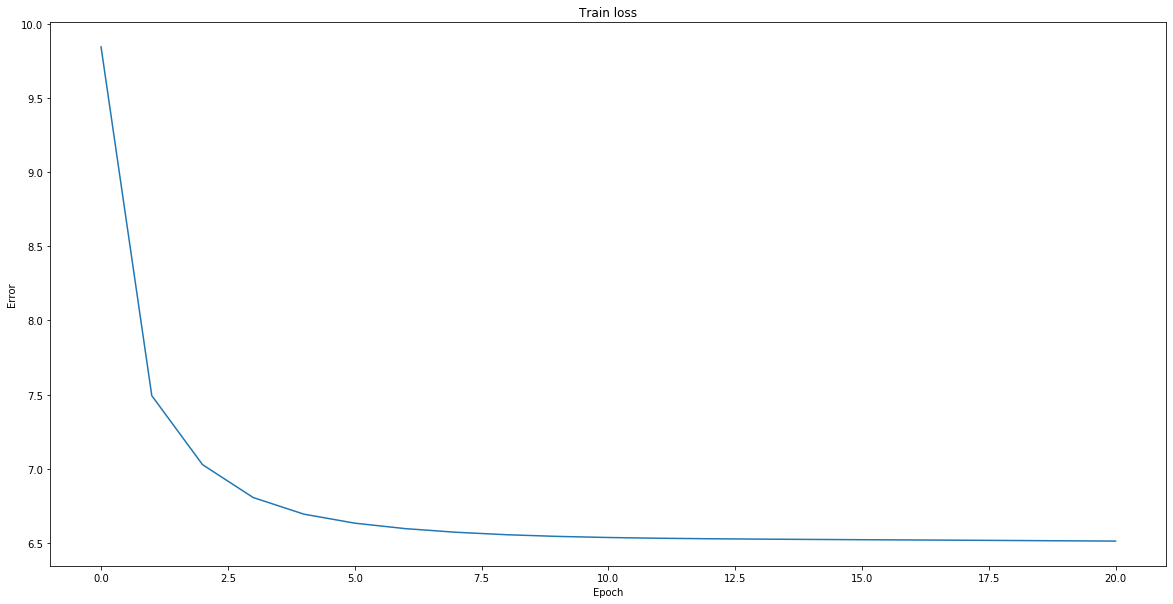

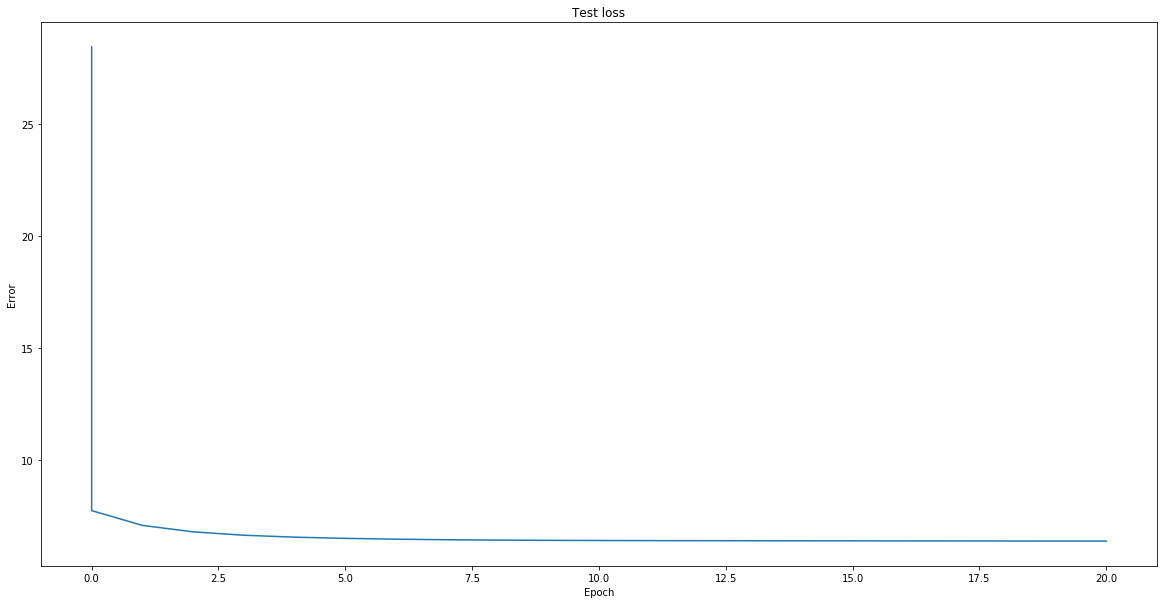

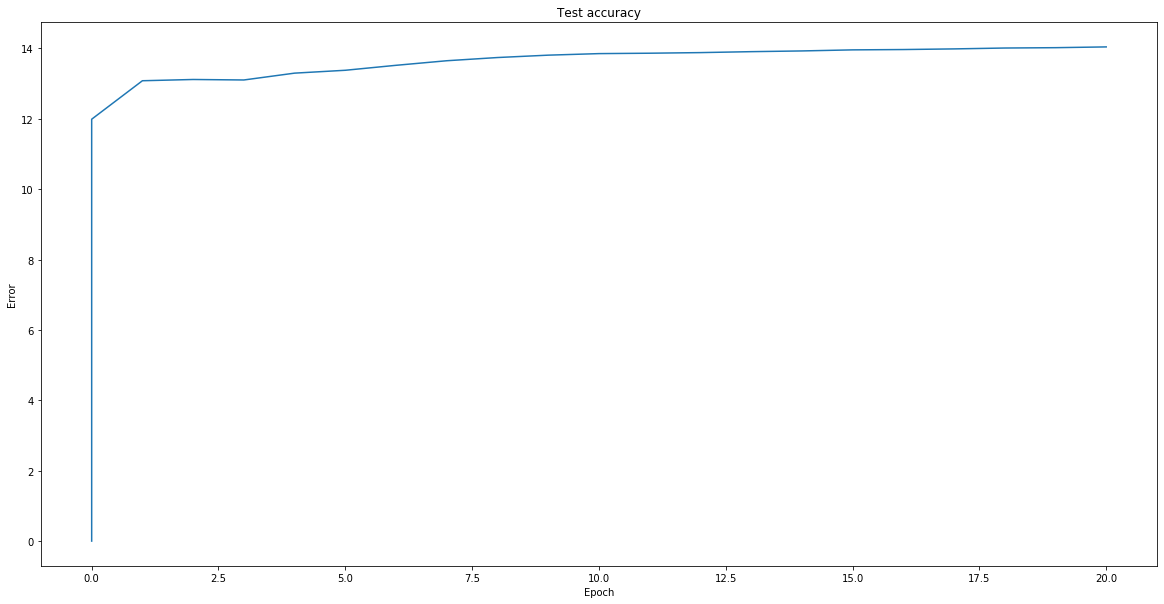

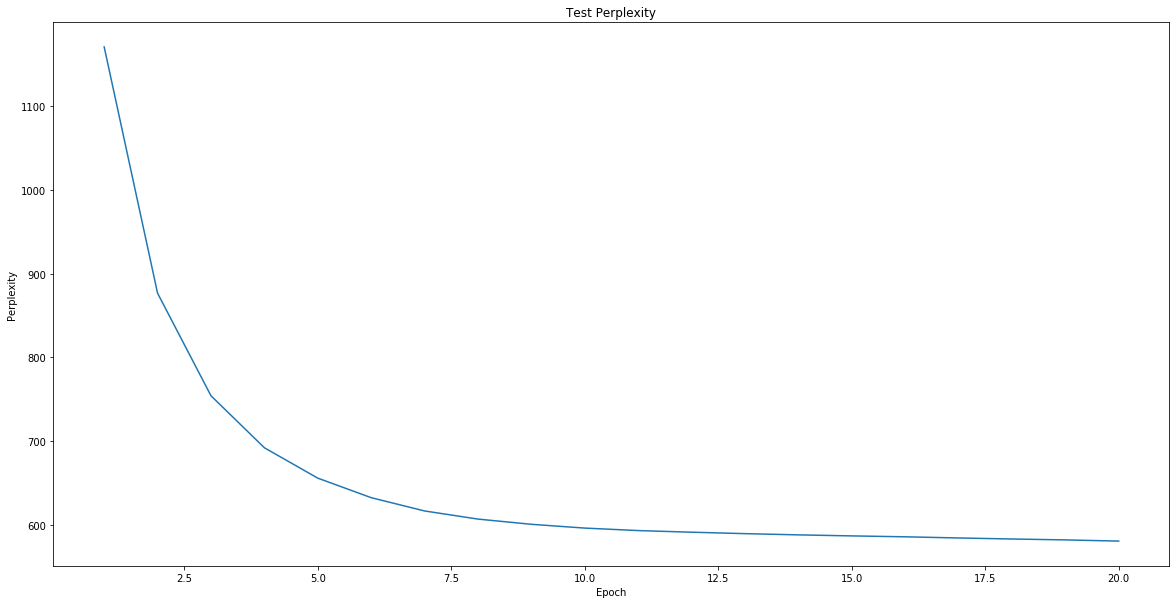

In [24]:
def main():
    SEQUENCE_LENGTH = 10
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'harry_potter_words/logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_words_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_words_train.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'harry_potter_words/checkpoints')

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))
    test_perplexities.append((start_epoch, test_perplexity))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            test_perplexities.append((epoch, test_perplexity))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'harry_potter_words/checkpoints/%03d.pt' % epoch)
            seed_words = ['Harry ', 'Potter ', 'Voldemort ', 'and ', 'Dumbledore ', 'walk ', 'into ', 'a ', 'bar. ']
            generated_sentence = generate_language(model, device, seed_words, 10, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 10, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 10, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep[2:], val[2:], 'Test Perplexity', 'Epoch', 'Perplexity')
        return model, vocab, device

final_model, vocab, device = main()

### Differnt Data Set - A Brief History of Time

In [0]:
import unicodedata
import string

def unicodeToAscii(s):
    all_letters = string.ascii_letters + string.digits + " .,;'"
    n_letters = len(all_letters)
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


def prepare_brief_history_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.readlines()

    data = filter(lambda x: not x.startswith('file:///C'), data)
    data = filter(lambda x: not x.startswith('Figure'), data)
    data = list(data)
    data = ' '.join(data)
    data = unicodeToAscii(data)
    data = re.sub(r'\s+', ' ', data)

    voc2ind = dict()

    # Compute voc2ind and transform the data into an integer representation of the tokens.
    i = 0
    for char in data:
        if char not in voc2ind:
            voc2ind[char] = i
            i += 1

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_szie = 0.8
    train_end_index = int(train_szie * len(data))

    train_text = data[:train_end_index]
    test_text = data[train_end_index:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind': voc2ind},
                open(DATA_PATH + 'a_brief_history_of_time_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind': voc2ind},
                open(DATA_PATH + 'a_brief_history_of_time_test.pkl', 'wb'))


prepare_brief_history_data(BASE_PATH + 'a_brief_history_of_time.txt')

In [0]:
class BriefHistoryDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(BriefHistoryDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # remove tokens that aren't enough to make a batch
        tokens = dataset['tokens']
        trim_index = len(tokens) - (len(tokens) % batch_size)
        tokens = tokens[:trim_index]
        tokens = self.vocab.words_to_array(tokens)
        self.tokens = tokens.reshape(self.batch_size, -1)
        self.num_unique_seq = batch_size * ((self.tokens.shape[1] // self.sequence_length)
                                            + (0 if self.tokens.shape[1] % self.sequence_length == 0 else 1))

    def __len__(self):
        # return the number of unique sequences you have, not the number of characters.
        return self.num_unique_seq

    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are
        # in and how far down in the chunk you are.
        batch = idx % self.batch_size
        start = idx // self.batch_size * self.sequence_length
        end = start + self.sequence_length + 1
        data = self.tokens[batch, start:end]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

In [0]:
class BriefHistoryNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(BriefHistoryNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)

        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()

        self.best_accuracy = -1

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [31]:
!ls /content/brief_history/
! rm -rf /content/brief_history/

checkpoints  logs


Using device cuda
num workers: 2
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	e;ocWc1McYYPBe11PPPPp'p''Y1PBJPPPMYcMM9'RBcB11pce11Wl''s1'QePJ 1PJJJ6Jqc6Ne6DeeeMHIc YJJJp6J11c'KPPM




  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 17.2539, Perplexity: 31138272.0000, Accuracy: 924/76800 (1%)



  8%|▊         | 1/12 [00:00<00:01,  6.51it/s]

Train Epoch: 0 [0/3072 (0%)]	Loss: 17.220846


100%|██████████| 12/12 [00:00<00:00, 17.15it/s]

Train Epoch: 0 [2560/3072 (83%)]	Loss: 10.565585


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	etedadeqti r e  ees,vg vti r hwesU oatntR,cnoooo,    .f thtexh0  harioiwieoe.   THaya   hNRRhicile T



Test set: Average loss: 9.6831, Perplexity: 16043.8311, Accuracy: 18655/76800 (24%)

Saved /content/brief_history/checkpoints/000.pt

generated max		 Black holes are ons, the of fo riction, chawenelese. Thaweng. . Thaweng. . Thaweng. . Thaweng. . Thaweng. . Thaweng.
generated sample	 Black holes are on, the wiut sele. Thawenelese. Thaweng. Thaweneusen, the wexpasen, the wif the of fo riden, the wio
generated sample	 Black holes are ons, the of fo ricthe sen, the wexpasene, wit the seleaweng. Thawenivise, wit the sen, the of fo of 
generated sample	 Black holes are ons, the of fo f the wexpasene, wit the sele. Thaweniverse, wither haweng. Thaweng. . Thaweng. Thawe
generate

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are ons, the of fo riction, chawenelese. Thaweng. . Thaweng. . Thaweng. . Thaweng. . Thaweng. . Thaweng.



  8%|▊         | 1/12 [00:00<00:01,  6.13it/s]

Train Epoch: 1 [0/3072 (0%)]	Loss: 9.206915


100%|██████████| 12/12 [00:00<00:00, 17.84it/s]

Train Epoch: 1 [2560/3072 (83%)]	Loss: 4.827923


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	hmebanenn  m ee,sitiwwitn    ylstuioaasTruefotoeee   rf Teee tt mlencoai engo  .IIevlh. t90Choti.s T



Test set: Average loss: 4.6941, Perplexity: 109.2991, Accuracy: 22812/76800 (30%)

Saved /content/brief_history/checkpoints/001.pt

generated max		 Black holes are a for thellow that relation. The in form anot ralation. The in form anot ralation. The in form anot 
generated sample	 Black holes are in for mat wa not ralation. The of ount in in formancuniverse shole in protiblet thenOry. . CI not w
generated sample	 Black holes are for that laribout in in of Then mary, re in helow in gent of ounlot in in protry. . CI not wa relse 
generated sample	 Black holes are a universe arNed that wa not ralatian. The in form anot wa not ralation. The in form anot ralation. 
generated 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are a for thellow that relation. The in form anot ralation. The in form anot ralation. The in form anot 



  8%|▊         | 1/12 [00:00<00:01,  6.87it/s]

Train Epoch: 2 [0/3072 (0%)]	Loss: 4.352099


100%|██████████| 12/12 [00:00<00:00, 18.07it/s]

Train Epoch: 2 [2560/3072 (83%)]	Loss: 3.020826


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tevpeeen   aealyy..rnytn  , .le.kiourrtrieffHisoo y on timp mceleen Hawking. ..Fhavp r r900hoti . T



Test set: Average loss: 3.0883, Perplexity: 21.9404, Accuracy: 27610/76800 (36%)

Saved /content/brief_history/checkpoints/002.pt

generated max		 Black holes are we the enenenenenvenly ben on of tining to the selory time posselion whis con forram pprticles pere 
generated sample	 Black holes are for the would re polion pblack howys, the one on of ti5on of the on forall. Ins forre with the crom 
generated sample	 Black holes are we the deory would I fforrse litons forr to for the to by and gon of tiron on, to on forrdie, on wou
generated sample	 Black holes are we the elight on, the speed to the for the speen Hawking. . FKere of on of Firs on ccluare was is to
generated s

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are we the enenenenenvenly ben on of tining to the selory time posselion whis con forram pprticles pere 



  8%|▊         | 1/12 [00:00<00:01,  6.79it/s]

Train Epoch: 3 [0/3072 (0%)]	Loss: 2.790279


100%|██████████| 12/12 [00:00<00:00, 18.23it/s]

Train Epoch: 3 [2560/3072 (83%)]	Loss: 3.359016


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	ttetttettte eeeneytgpneCtt , yt ttettttttitfftetttny pf tite Stephen Hebkitt....Chatte  p900hete   I



Test set: Average loss: 3.6250, Perplexity: 37.5241, Accuracy: 24565/76800 (32%)

generated max		 Black holes are untum execcles, the enenergy of the exccles, the enenenten, it the exccles, the enenenten, it the ex
generated sample	 Black holes are Newith. O, It epentenstenstentutentuatume folle, state conte one of the quenter itstes nutem been fo
generated sample	 Black holes are mente monder itsten, it the excclespententumber effutenturent expentsen. It hat the exccles. It stat
generated sample	 Black holes are ante nenenenece of the exccles, the enenenenteces. It expenstenstents, theen, hey benenenentenens, i
generated sample	 Black holes are coles teenter pecoles. It 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are peintenten, it the exccles, the enenenten, it the exccles, the enenenten, it the exccles, the enenen



  8%|▊         | 1/12 [00:00<00:01,  6.17it/s]

Train Epoch: 4 [0/3072 (0%)]	Loss: 3.398230


100%|██████████| 12/12 [00:00<00:00, 17.76it/s]

Train Epoch: 4 [2560/3072 (83%)]	Loss: 2.337369


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 oevttetteel eidlyi,tfbtt sl  i xtie tltreefitisoory tf time ttephen Hawking... Chapter w90shete   I



Test set: Average loss: 2.4365, Perplexity: 11.4329, Accuracy: 32653/76800 (43%)

Saved /content/brief_history/checkpoints/004.pt

generated max		 Black holes are the semare that the semare that the semare that the semare that the semare that the semare that the 
generated sample	 Black holes are we the that the uniffiecties would be the sem mattet the sem. I that that the unive see magento be s
generated sample	 Black holes are sure modes have be now the semmen the sem the universe we twe the matter by are disciple, when fact,
generated sample	 Black holes are sem that the universe be betwen not the sup that the universe by are the sunifferent would be the sa
generated s

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the semare that the semare that the semare that the semare that the semare that the semare that the 



  8%|▊         | 1/12 [00:00<00:01,  6.72it/s]

Train Epoch: 5 [0/3072 (0%)]	Loss: 2.197795


100%|██████████| 12/12 [00:00<00:00, 17.76it/s]

Train Epoch: 5 [2560/3072 (83%)]	Loss: 2.149030


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 totttett eaatedyyt tfbtt    yt xtioatrBrief Hittory of time Stephen Hawking... Chapter t90Bhoti   T



Test set: Average loss: 2.4216, Perplexity: 11.2640, Accuracy: 34037/76800 (44%)

Saved /content/brief_history/checkpoints/005.pt

generated max		 Black holes are the ement the prition of the univer the enertation of the univer the enerthe comontion of the univer
generated sample	 Black holes are the earth a rathe ratherm of the even the event the if the entery of the event the if the eat the un
generated sample	 Black holes are called the pritated the by a black holed the matter the by a balle the mor the remiter the matter th
generated sample	 Black holes are the energy back acholection of the by a priting a the earth a rathe it of the by a black hole dectro
generated s

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the ement the prition of the univer the enertation of the univer the enerthe comontion of the univer



  8%|▊         | 1/12 [00:00<00:01,  6.61it/s]

Train Epoch: 6 [0/3072 (0%)]	Loss: 2.182286


100%|██████████| 12/12 [00:00<00:00, 14.49it/s]

Train Epoch: 6 [2560/3072 (83%)]	Loss: 1.896302


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tadttett e aeedlytinn rtter ei xkio tlBrief History of Time ttephen Hawking... Chapter i90ihate   T



Test set: Average loss: 2.0784, Perplexity: 7.9915, Accuracy: 34044/76800 (44%)

Saved /content/brief_history/checkpoints/006.pt

generated max		 Black holes are of speces to state of the energy, are ast radired ast radited ast are one reassurest onster of radir
generated sample	 Black holes are ore reasten to the speed of light other reases not the funiverse. In the orre ore reared ore reared 
generated sample	 Black holes are stare of light one reassitations the stenterent one of state of sphent of specent of the sunifferent
generated sample	 Black holes are of spicaties and gravity. The reases to are of spaces it was afte it the suncered reastent ons the r
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are reaster of speces to state of the energy, are ast radired ast radited ast are one reassurest onster 



  8%|▊         | 1/12 [00:00<00:01,  6.58it/s]

Train Epoch: 7 [0/3072 (0%)]	Loss: 1.846671


100%|██████████| 12/12 [00:00<00:00, 17.86it/s]

Train Epoch: 7 [2560/3072 (83%)]	Loss: 2.119056


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 aedpteattaaaeadlyiiwf att raei xkitaalBrief Hittary af aime Siephen Hawkitg... Chapter a 0ihavi e T



Test set: Average loss: 2.4556, Perplexity: 11.6531, Accuracy: 33274/76800 (43%)

generated max		 Black holes are a sitar a magene a real real real real real real real real real real real real real real real real r
generated sample	 Black holes are pare it a real real fiture a reallity a fituantum meare and a may a number are are a pareaitity are 
generated sample	 Black holes are dit a fituall are and a nith a reall itractity, and a lithat have a aback hole. In are are are a rea
generated sample	 Black holes are a paritity alit a fiture all ear a fituall are and a pare abit a The reament have a sit it a seemani
generated sample	 Black holes are a reall eare are are a man

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are a sitar a magene a real real real real real real real real real real real real real real real real r



  8%|▊         | 1/12 [00:00<00:01,  6.88it/s]

Train Epoch: 8 [0/3072 (0%)]	Loss: 2.228415


100%|██████████| 12/12 [00:00<00:00, 18.12it/s]

Train Epoch: 8 [2560/3072 (83%)]	Loss: 2.257127


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 oadtliin e    dyyt tb tn  r ii xt oatttriefiiistery of time ttepeen Hawking... Chapter i99ihatil  T



Test set: Average loss: 2.4268, Perplexity: 11.3227, Accuracy: 34155/76800 (44%)

Saved /content/brief_history/checkpoints/008.pt

generated max		 Black holes are in inite in inite in inite in inite in inite in inite in inite in inite in inite in inite in inite i
generated sample	 Black holes are temine in tepen teen the of the universe in inig be of the universe in tepentened of the univers. In
generated sample	 Black holes are of time inig be gravitate of the univers. The sime in inite tenene of the univers. The nergy in1 i1 
generated sample	 Black holes are beig in in11111YYY4s of the universe in tepentenes one of time in tepent finiele. The sunivers. In t
generated s

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are in inite in inite in inite in inite in inite in inite in inite in inite in inite in inite in inite i



  8%|▊         | 1/12 [00:00<00:01,  6.15it/s]

Train Epoch: 9 [0/3072 (0%)]	Loss: 2.161787


100%|██████████| 12/12 [00:00<00:00, 17.60it/s]

Train Epoch: 9 [2560/3072 (83%)]	Loss: 1.836162


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetttett er tenlyt,tbbtt ar yt tkioaatBrieffHistory of time ttephen Hawking... Chapter t 9ihatily T



Test set: Average loss: 2.0616, Perplexity: 7.8585, Accuracy: 35572/76800 (46%)

Saved /content/brief_history/checkpoints/009.pt

generated max		 Black holes are that the the universe that the the universe that the the universe that the the universe that the the
generated sample	 Black holes are force that the trate this that the theory of the universe that the othre of the the universe, this t
generated sample	 Black holes are the the corces. This the the universe it the straction of the big ban and it protatic protating at t
generated sample	 Black holes are stars that the there to the theory of the universe, the time. It it speed that the universe this the
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are that the the universe that the the universe that the the universe that the the universe that the the



  8%|▊         | 1/12 [00:00<00:01,  6.41it/s]

Train Epoch: 10 [0/3072 (0%)]	Loss: 1.824704


100%|██████████| 12/12 [00:00<00:00, 17.84it/s]

Train Epoch: 10 [2560/3072 (83%)]	Loss: 2.226284


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 iadpnein eaaeedyyciifbpnciraynyxkioaclBrief Hiseory of Time Siephen Hawking... Chapper i 0ihayily T



Test set: Average loss: 2.9526, Perplexity: 19.1559, Accuracy: 34300/76800 (45%)

generated max		 Black holes are in1 i1 2111YYY4wd they comening and universe cannomening and universe cannomening and universe canno
generated sample	 Black holes are seemeniverse ince and insingularing phardicularied number of pricince 2 prince in 191 8 I ward and t
generated sample	 Black holes are singularised in and and cerace parince in1 i1 21 2, when Habounded of gravied and and the elechanged
generated sample	 Black holes are quantumed elechanger and parince in1 1964 way and arany monenery differennice coned finig universe c
generated sample	 Black holes are will be like universe carr

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are in1 i1 2111YYY4wd they comening and universe cannomening and universe cannomening and universe canno



  8%|▊         | 1/12 [00:00<00:01,  6.97it/s]

Train Epoch: 11 [0/3072 (0%)]	Loss: 2.680083


100%|██████████| 12/12 [00:00<00:00, 18.15it/s]

Train Epoch: 11 [2560/3072 (83%)]	Loss: 1.952294


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 wedhnemn eleeadlytttfbtn e.eet xkivaalBrief History of gime Stephen Hawking... Chapper t99Ghatel  T



Test set: Average loss: 2.0857, Perplexity: 8.0503, Accuracy: 36166/76800 (47%)

Saved /content/brief_history/checkpoints/011.pt

generated max		 Black holes are of the electrons, we collige that the entrate that the black holes, we collows from the black holes,
generated sample	 Black holes are of the black holes, we as we well that the light the entrate the black holes, we of the universe in 
generated sample	 Black holes are of the black holes, we we on electron. Sun are of the modes of the universes, and and a senturent th
generated sample	 Black holes are elective the electrons use that the black holes we that the earth and did not that that the black ho
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are of the electrons, we collige that the entrate that the black holes, we collows from the black holes,



  8%|▊         | 1/12 [00:00<00:01,  6.63it/s]

Train Epoch: 12 [0/3072 (0%)]	Loss: 1.827258


100%|██████████| 12/12 [00:00<00:00, 17.55it/s]

Train Epoch: 12 [2560/3072 (83%)]	Loss: 1.618596


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetpteon oa   dyyt tu ts or et xkioaa Brief History of Time Stephen Hawking... Chapter p 0phatile T



Test set: Average loss: 1.8299, Perplexity: 6.2331, Accuracy: 38528/76800 (50%)

Saved /content/brief_history/checkpoints/012.pt

generated max		 Black holes are out of the boxises to the boxises to the boxises to the boxises to the boxises to the boxises to the
generated sample	 Black holes are back a holecary of the black hole universe would recological rated to blecause the position of the s
generated sample	 Black holes are out a light the positions of the out of the earth other that the universe coments of the follows the
generated sample	 Black holes are of the extrate go and oppose to the grate of the the morig bang and readum on more observer to movin
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are emits of the earth other to the boxises to the boxises to the boxises to the boxises to the boxises 



  8%|▊         | 1/12 [00:00<00:01,  6.75it/s]

Train Epoch: 13 [0/3072 (0%)]	Loss: 1.581308


100%|██████████| 12/12 [00:00<00:00, 17.77it/s]

Train Epoch: 13 [2560/3072 (83%)]	Loss: 1.517185


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tedpdeon o  eedlyt wf bs er et xkioaalBrief History of Time Stephen Hawking... Chapter t 55hevele T



Test set: Average loss: 1.7949, Perplexity: 6.0188, Accuracy: 38874/76800 (51%)

Saved /content/brief_history/checkpoints/013.pt

generated max		 Black holes are seem to see the seem to see the the universe would be the seem to see the the universe would be the 
generated sample	 Black holes are of the universe was afte the electrons at event hose the bleculse the the seem to escried the seem t
generated sample	 Black holes are emiter is the proposes the mound the seem to see the the cosmolete possible the stars most distons a
generated sample	 Black holes are move the supposed a scies would not expend only to esse the moving a mound so some the universe was 
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are seem to see the seem to see the the universe would be the seem to see the the universe would be the 



  8%|▊         | 1/12 [00:00<00:01,  6.87it/s]

Train Epoch: 14 [0/3072 (0%)]	Loss: 1.549896


100%|██████████| 12/12 [00:00<00:00, 18.06it/s]

Train Epoch: 14 [2560/3072 (83%)]	Loss: 1.496731


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tedptets o    dlyt,tf bs or et xkioaalBrief History of Time Stephen Hawking... Chapter t 5shave e T



Test set: Average loss: 1.7615, Perplexity: 5.8214, Accuracy: 39064/76800 (51%)

Saved /content/brief_history/checkpoints/014.pt

generated max		 Black holes are that the black holes are that the black holes are that the black holes are that the black holes are 
generated sample	 Black holes are lepuse is appear of space that that the are was a black holes is lowits of as attractive at ach the 
generated sample	 Black holes are possible that the sum of gat as a simplete posse that the possible that that the late that that the 
generated sample	 Black holes are that happen Hawking... Chapter a repulse is are look is remould be that speed by and that the regios
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are was a suggest that that the universe would be that the universe would be that the universe would be 



  8%|▊         | 1/12 [00:00<00:01,  6.91it/s]

Train Epoch: 15 [0/3072 (0%)]	Loss: 1.518236


100%|██████████| 12/12 [00:00<00:00, 17.99it/s]

Train Epoch: 15 [2560/3072 (83%)]	Loss: 1.723472


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tatpn tn or tadlyt,tf tntor yt xkioaalBrinf History of Timi Stephen Hawking... Chapthr t 5ihavil  T



Test set: Average loss: 1.9188, Perplexity: 6.8126, Accuracy: 37875/76800 (49%)

generated max		 Black holes are around the univers arrow of the univers arrow of the univers arrow of the univers arrow of the unive
generated sample	 Black holes are particles arbity. In the thery of the univers arrow of the univers the rather was the light. In the 
generated sample	 Black holes are universe was arrow from the rather the rather the univers at arount univers wording the the univers,
generated sample	 Black holes are propossible the such as at his million million of a black hols have begas arround the timply, it in 
generated sample	 Black holes are mory or the rath in the uni

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the rather the univers around the univers arrow of the univers arrow of the univers arrow of the uni



  8%|▊         | 1/12 [00:00<00:01,  6.83it/s]

Train Epoch: 16 [0/3072 (0%)]	Loss: 1.671737


100%|██████████| 12/12 [00:00<00:00, 18.09it/s]

Train Epoch: 16 [2560/3072 (83%)]	Loss: 1.542399


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tedpd tn o    dlyt,tfbbs irset xkioaalBrief History of Time Stephen Hawking... Chapter i 5shavel  T



Test set: Average loss: 1.7403, Perplexity: 5.6990, Accuracy: 39645/76800 (52%)

Saved /content/brief_history/checkpoints/016.pt

generated max		 Black holes are stars that the strong in the strong in the strong in the strong in the strong in the strong in the s
generated sample	 Black holes are sult that the stars that the gravity and with as that is all for the observed in as that is also the
generated sample	 Black holes are list is solut is form any particles would meach as are all the is meassure that the sime that is con
generated sample	 Black holes are strong is numbers that is that is that the speed in the stron that is suppons to and so would in the
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are stars that the strong in the strong in the strong in the strong in the strong in the strong in the s



  8%|▊         | 1/12 [00:00<00:01,  6.91it/s]

Train Epoch: 17 [0/3072 (0%)]	Loss: 1.493449


100%|██████████| 12/12 [00:00<00:00, 17.93it/s]

Train Epoch: 17 [2560/3072 (83%)]	Loss: 1.404696


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 oedpa on oa   dl t wf bn or et xkioaalBrief History of Time Stephen Hawking... Chapter i 5ihavil  T



Test set: Average loss: 1.6789, Perplexity: 5.3595, Accuracy: 40469/76800 (53%)

Saved /content/brief_history/checkpoints/017.pt

generated max		 Black holes are is a more more more more more more more more more more more more more more more more more more more 
generated sample	 Black holes are collaps about of expansion of millow of more more moving alative accordinate are more more more more
generated sample	 Black holes are laws of gravity a finding of the universe is are are collapse of a space iffected of gravitational a
generated sample	 Black holes are collapse a singularity. For allso of gravity affect would also in a black holes of a singularity is 
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are of a black hole would be about of every model of galaxies are more more more more more more more mor



  8%|▊         | 1/12 [00:00<00:01,  6.78it/s]

Train Epoch: 18 [0/3072 (0%)]	Loss: 1.432952


100%|██████████| 12/12 [00:00<00:00, 18.10it/s]

Train Epoch: 18 [2560/3072 (83%)]	Loss: 1.472792


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetpnetn ereeedlyt wf bn ereet xkioaclBrief History of Time Stephen Hawking... Chapter i 5ihivele T



Test set: Average loss: 1.7559, Perplexity: 5.7886, Accuracy: 39943/76800 (52%)

generated max		 Black holes are experiments in the energy of the universe in the energy of the universe in the energy of the univers
generated sample	 Black holes are sum of very moven modelopse the exploose the no of time in event in the energy of the universe in th
generated sample	 Black holes are expections of the energy of the universe in their modelow the indered singularity in the sun to woul
generated sample	 Black holes are singularity the seem indeter in the discovered in the inder the energy the energy been insterent ene
generated sample	 Black holes are experfect would be the more

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are in 1970 state in experiment in the energy of the universe in the energy of the universe in the energ



  8%|▊         | 1/12 [00:00<00:01,  6.37it/s]

Train Epoch: 19 [0/3072 (0%)]	Loss: 1.516455


100%|██████████| 12/12 [00:00<00:00, 17.53it/s]

Train Epoch: 19 [2560/3072 (83%)]	Loss: 1.567954


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 oedpd on oreeedl t wfbbncoreetaxkiololBrief History of Time Stephen Hawking... Chapter o 5ahavele T



Test set: Average loss: 1.8027, Perplexity: 6.0659, Accuracy: 39911/76800 (52%)

generated max		 Black holes are our of a particle of a particle of a particle of a particle of a particle of a particle of a particl
generated sample	 Black holes are appeared a begating and and we could appear of a upper of a particles are observer se, we could be a
generated sample	 Black holes are could a berganing and any completed by a completed be able of a black hole we we were in a few ource
generated sample	 Black holes are a seem are a back collapse a see of galaxies are a moust physicse of or about observe a been a corre
generated sample	 Black holes are our of a publes of a partic

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are our of a particle of a particle of a particle of a particle of a particle of a particle of a particl



  8%|▊         | 1/12 [00:00<00:01,  6.96it/s]

Train Epoch: 20 [0/3072 (0%)]	Loss: 1.557542


100%|██████████| 12/12 [00:00<00:00, 18.16it/s]

Train Epoch: 20 [2560/3072 (83%)]	Loss: 1.424151


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetpd tn olee dl t wbbbnter et xkioaclBrief History of time Stephen Hawking... Chapter i 5ihavel  T



Test set: Average loss: 1.6796, Perplexity: 5.3634, Accuracy: 41142/76800 (54%)

Saved /content/brief_history/checkpoints/020.pt

generated max		 Black holes are is expanding the universe were in the electrons of the universe were in the electrons of the univers
generated sample	 Black holes are emitter matter we contractic possible the speed on the explace of the universe helectrons of the uni
generated sample	 Black holes are he the energies we the electrical contracting more of the universe we contractions. It is wave secon
generated sample	 Black holes are hundred in the exteren it waves the discovere he lerge wen the electrons suppose the were in the ene
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are expanding the universe were in the electrons of the universe were in the electrons of the universe w



  8%|▊         | 1/12 [00:00<00:01,  6.90it/s]

Train Epoch: 21 [0/3072 (0%)]	Loss: 1.437462


100%|██████████| 12/12 [00:00<00:00, 18.31it/s]

Train Epoch: 21 [2560/3072 (83%)]	Loss: 1.357798


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 oodid on or   dlyt,tf tttor et xkioaclBrief History of Time Stephen Hawking... Chapter t 5Ghavel  T



Test set: Average loss: 1.5978, Perplexity: 4.9423, Accuracy: 42062/76800 (55%)

Saved /content/brief_history/checkpoints/021.pt

generated max		 Black holes are of the end of the universe in the same that the back the complete that the universe would be a relat
generated sample	 Black holes are be supose that the speed of the position that the between that it was that the complete to forman th
generated sample	 Black holes are our of the region of the universe it even that that the possible to very that it was are other than 
generated sample	 Black holes are with a reater of the entropy of the more that the other would be in the space to the right that the 
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are of the end of the universe in the same that the back the complete that the universe would be a relat



  8%|▊         | 1/12 [00:00<00:01,  6.64it/s]

Train Epoch: 22 [0/3072 (0%)]	Loss: 1.350542


100%|██████████| 12/12 [00:00<00:00, 17.70it/s]

Train Epoch: 22 [2560/3072 (83%)]	Loss: 1.307960


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetpd on or   dl t wfbbtterset xkinaclBrief History of Time Stephen Hawking... Chapter t 5ihavel  T



Test set: Average loss: 1.5490, Perplexity: 4.7067, Accuracy: 42537/76800 (55%)

Saved /content/brief_history/checkpoints/022.pt

generated max		 Black holes are should be a black hole would be the universe would be the remember that the book at the speed of the
generated sample	 Black holes are more matter was annother in the other to finite is the resulting the forces that the really were the
generated sample	 Black holes are waves a really there particles have to deter that with it would be moving the wate that the universe
generated sample	 Black holes are questions and contracts contracted its form discovery the energy of gravitational singularity. If th
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are of the universe would be the remember that the book at the speed of the universe would be the univer



  8%|▊         | 1/12 [00:00<00:01,  6.57it/s]

Train Epoch: 23 [0/3072 (0%)]	Loss: 1.301811


100%|██████████| 12/12 [00:00<00:00, 17.86it/s]

Train Epoch: 23 [2560/3072 (83%)]	Loss: 1.284717


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetpd on ere  dlyt,wfbbnterset xkioaclBrief History of Time Stephen Hawking... Chapter t 5Ghavel  T



Test set: Average loss: 1.5171, Perplexity: 4.5589, Accuracy: 43172/76800 (56%)

Saved /content/brief_history/checkpoints/023.pt

generated max		 Black holes are surface of the sun would be the surface of the universe would be the surface of the universe would b
generated sample	 Black holes are The expanding to the surported and density of the it some the source recolect. One contracted to the
generated sample	 Black holes are universe have second. Pole, the surface of photons and order the not of mechanics stars to the sun t
generated sample	 Black holes are space is a black holes would be a black holes in the sun a the position waves at the same the partic
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are expanding the sun the sun of the universe would be the surface of the universe would be the surface 



  8%|▊         | 1/12 [00:00<00:01,  6.75it/s]

Train Epoch: 24 [0/3072 (0%)]	Loss: 1.270573


100%|██████████| 12/12 [00:00<00:00, 18.03it/s]

Train Epoch: 24 [2560/3072 (83%)]	Loss: 1.267103


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetid on ore  dlyt tfbbn orset xkioaclBrief History of Time Stephen Hawking... Chapter t 5Ghavel  T



Test set: Average loss: 1.5040, Perplexity: 4.4997, Accuracy: 43397/76800 (57%)

Saved /content/brief_history/checkpoints/024.pt

generated max		 Black holes are surface of the universe would be the strong that the sun the sun the sun the sun the sun of the univ
generated sample	 Black holes are probable that the black hole colleade to the boundary consequence that the position it wate. The bla
generated sample	 Black holes are boundary the speed of a straction of the sun or the to detect of the universe would be the force tha
generated sample	 Black holes are forces that they called a completely that we can an energy the sun of the sun between the are that i
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the speed of the universe that the sun the sun the sun the sun of the universe would be the strong t



  8%|▊         | 1/12 [00:00<00:01,  6.77it/s]

Train Epoch: 25 [0/3072 (0%)]	Loss: 1.257466


100%|██████████| 12/12 [00:00<00:00, 18.23it/s]

Train Epoch: 25 [2560/3072 (83%)]	Loss: 1.251178


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tethdeon ole  dlyt tf bn ereen xkioaclBrief History of Time Stephen Hawking... Chapter t 5phavele T



Test set: Average loss: 1.5317, Perplexity: 4.6260, Accuracy: 43216/76800 (56%)

generated max		 Black holes are such a star the same the energy of the universe the sun of the universe the sun of the universe the 
generated sample	 Black holes are of expandond or example, the orbit the sources of a very state of the expands one out a hot endergy 
generated sample	 Black holes are the star the more make the star of the universe the early uncelerge concertant would be move the pos
generated sample	 Black holes are the enough the energy of the electron see of the universe the region of the universe was every force
generated sample	 Black holes are the more the temperature of

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same the energy of the universe the sun of the universe the sun of the universe the sun of the u



  8%|▊         | 1/12 [00:00<00:01,  6.63it/s]

Train Epoch: 26 [0/3072 (0%)]	Loss: 1.282352


100%|██████████| 12/12 [00:00<00:00, 17.24it/s]

Train Epoch: 26 [2560/3072 (83%)]	Loss: 1.450124


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 iedhdebn ere  dl c wfbbn ersen xkinaclBrief History if Time Stephen Hawking... Chapter w  ihavele T



Test set: Average loss: 1.6822, Perplexity: 5.3774, Accuracy: 41305/76800 (54%)

generated max		 Black holes are sun was a such a star confing and such as a suggest that in what was a such a star confing and such 
generated sample	 Black holes are such as no be universe in such a particle in what in what was all the black hole would be model be d
generated sample	 Black holes are was from a state in a strong radiate in such a sen could as we could be lectron that the pases that 
generated sample	 Black holes are suggest and waves from was such abserve in a sense in see sun and start in that centract in a black 
generated sample	 Black holes are remember than space in a st

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are sun was a such a star confing and such as a suggest that in what was a such a star confing and such 



  8%|▊         | 1/12 [00:00<00:01,  6.79it/s]

Train Epoch: 27 [0/3072 (0%)]	Loss: 1.414807


100%|██████████| 12/12 [00:00<00:00, 18.03it/s]

Train Epoch: 27 [2560/3072 (83%)]	Loss: 1.293939


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetid tn oret dlyt,tf bncorsen xkioaclBrief History of Time Stephen Hawking... Chapter t 5Ghavel  T



Test set: Average loss: 1.5327, Perplexity: 4.6305, Accuracy: 43098/76800 (56%)

generated max		 Black holes are the speed of the universe with the universe was the sun of the universe was the sun of the universe 
generated sample	 Black holes are energy that the earth our remarry model that the universe was expect that the universe was of the su
generated sample	 Black holes are expanding that the because the strong that the reathous the energy the found the endeter of the univ
generated sample	 Black holes are lemer to collapse the earth of the universe it speed the force of the energy increase the the observ
generated sample	 Black holes are a singule in the expending 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are moving the sun of the universe was the sun of the universe was the sun of the universe was the sun o



  8%|▊         | 1/12 [00:00<00:01,  6.63it/s]

Train Epoch: 28 [0/3072 (0%)]	Loss: 1.274948


100%|██████████| 12/12 [00:00<00:00, 17.81it/s]

Train Epoch: 28 [2560/3072 (83%)]	Loss: 1.472049


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tatid tn ea t dlyt tfbttter en xkinat Brief Histsry tf time Stephen Hawking... Chapter t  ahavel  T



Test set: Average loss: 1.8657, Perplexity: 6.4604, Accuracy: 41101/76800 (54%)

generated max		 Black holes are the the the the the the the the the the the the the the the the the the the the the the the the the 
generated sample	 Black holes are the the the the the the the universe that the same that the started that the sun the the the thre th
generated sample	 Black holes are it was that the the the the the the the universe that the the twent the the time that the same that 
generated sample	 Black holes are the the the the the the big and the the the the universe that the the late that the universe that th
generated sample	 Black holes are it was that the the time th

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the the the the the the the the the the the the the the the the the the the the the the the the the 



  8%|▊         | 1/12 [00:00<00:01,  5.93it/s]

Train Epoch: 29 [0/3072 (0%)]	Loss: 1.584408


100%|██████████| 12/12 [00:00<00:00, 17.63it/s]

Train Epoch: 29 [2560/3072 (83%)]	Loss: 1.492212


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tedid on or   dl n wbbtsfor in xkiolc Brief Histony of time Stephen Hawking... Chapter 2  Ghavel  T



Test set: Average loss: 1.7448, Perplexity: 5.7250, Accuracy: 40520/76800 (53%)

generated max		 Black holes are moving and the expection the some to the universe is expanding to the expection the some to the univ
generated sample	 Black holes are seement of the event hot is not every seed one would be very chemer is is continue of the universe i
generated sample	 Black holes are seemed so the probably be consted not his one been the lower is expanding to the so contained by and
generated sample	 Black holes are existed is nother problem some the probablion the seem on the universe experiment so the other would
generated sample	 Black holes are become some signified the g

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are not experiment so the universe is expanding to the expection the some to the universe is expanding t



  8%|▊         | 1/12 [00:00<00:01,  6.93it/s]

Train Epoch: 30 [0/3072 (0%)]	Loss: 1.472187


100%|██████████| 12/12 [00:00<00:00, 17.95it/s]

Train Epoch: 30 [2560/3072 (83%)]	Loss: 1.302986


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetid bn oret dlyt,wf tnforsen xkioacnBrief History of Time Stephen Hawking... Chapter w  phavel  T



Test set: Average loss: 1.5397, Perplexity: 4.6630, Accuracy: 43168/76800 (56%)

generated max		 Black holes are suggested that the bodies that the bodies that the bodies that the bodies that the bodies that the b
generated sample	 Black holes are mount to the black hole had to great than the conced to the slockes that the surface ben a complete 
generated sample	 Black holes are energy and that the book of the speed of the two infinite time. This is singularities that the prese
generated sample	 Black holes are sum over have between to avoid the speed to the contains that there was that it was concentracts tha
generated sample	 Black holes are lite its seem to for was th

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are suggested that the bodies that the bodies that the bodies that the bodies that the bodies that the b



  8%|▊         | 1/12 [00:00<00:01,  6.55it/s]

Train Epoch: 31 [0/3072 (0%)]	Loss: 1.273062


100%|██████████| 12/12 [00:00<00:00, 17.68it/s]

Train Epoch: 31 [2560/3072 (83%)]	Loss: 1.224416


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tatid on ore  dlyt wfbbn orsen xkioaf Brief History of Time Stephen Hawking... Chapter 2  ahavel  T



Test set: Average loss: 1.4873, Perplexity: 4.4253, Accuracy: 43717/76800 (57%)

Saved /content/brief_history/checkpoints/031.pt

generated max		 Black holes are surface of the surface of the surface of the surface of the surface of the surface of the surface of
generated sample	 Black holes are the surface of the same it was accerated the seem of the universe with energies expands and the earl
generated sample	 Black holes are surface of the surverse the radiated by the earth surface of the same was field the force observatio
generated sample	 Black holes are it was the surported that we realized that the universe would be travel faill theory of the universe
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same is the same it was a black holes is the surface of the surface of the surface of the surfac



  8%|▊         | 1/12 [00:00<00:01,  6.46it/s]

Train Epoch: 32 [0/3072 (0%)]	Loss: 1.220220


100%|██████████| 12/12 [00:00<00:00, 17.74it/s]

Train Epoch: 32 [2560/3072 (83%)]	Loss: 1.202102


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tethd tn ore  dlyt wfbbn or en xkinaclBrief History of Time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.4762, Perplexity: 4.3765, Accuracy: 43892/76800 (57%)

Saved /content/brief_history/checkpoints/032.pt

generated max		 Black holes are surface of scientists such as sum over his the surface of science the surface of scientists such as 
generated sample	 Black holes are is a singue the sufficient for with the surface is a science of scient so back would have been a set
generated sample	 Black holes are suffice the same to some that the configurates the spectrum of radiations for the body of metimer ev
generated sample	 Black holes are back to scientists spacetime the surface of science the sun would show that the use would have to se
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are surface of scientists such as sum over his the surface of science the surface of scientists such as 



  8%|▊         | 1/12 [00:00<00:01,  6.82it/s]

Train Epoch: 33 [0/3072 (0%)]	Loss: 1.211839


100%|██████████| 12/12 [00:00<00:00, 17.75it/s]

Train Epoch: 33 [2560/3072 (83%)]	Loss: 1.184917


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tethd tn oret dlyt tfbbn oreen xkinac Brief History of Time Stephen Hawking... Chapter t  phavel  T



Test set: Average loss: 1.4569, Perplexity: 4.2926, Accuracy: 44386/76800 (58%)

Saved /content/brief_history/checkpoints/033.pt

generated max		 Black holes are surface of the sun would have to see the surface of the sun would have to see the surface of the sun
generated sample	 Black holes are the boxer or water, so it can spacetime in the sun, which the same the universe is the sun what is d
generated sample	 Black holes are boundary conditions that the surface of the universe between the symmetry from the sum of the sun, t
generated sample	 Black holes are gravitational collide with they arguments that force between two stop the same the speed of the univ
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are moving a singularity. In the sun the sun the sun the sun the sun the sun the sun the sun the sun the



  8%|▊         | 1/12 [00:00<00:01,  6.74it/s]

Train Epoch: 34 [0/3072 (0%)]	Loss: 1.192326


100%|██████████| 12/12 [00:00<00:00, 18.10it/s]

Train Epoch: 34 [2560/3072 (83%)]	Loss: 1.200688


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetid tn ere  dlyt wfbbn ersenaxkinac Brief History of Time Stephen Hawking... Chapter 6  ahavel  T



Test set: Average loss: 1.4567, Perplexity: 4.2918, Accuracy: 44412/76800 (58%)

Saved /content/brief_history/checkpoints/034.pt

generated max		 Black holes are sufficient for the sun and the sun would have the surface of the sun would have the surface of the s
generated sample	 Black holes are the star concertant would have the same particles that the universe the sun and the universe would b
generated sample	 Black holes are real, in the space the sould state that there waves are spacetime was the excently draw that the sam
generated sample	 Black holes are number the back the star that there would have been the star the early universe the ball be singular
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same the same that the sun would have the surface of the sun would have the surface of the sun w



  8%|▊         | 1/12 [00:00<00:01,  6.73it/s]

Train Epoch: 35 [0/3072 (0%)]	Loss: 1.191026


100%|██████████| 12/12 [00:00<00:00, 17.93it/s]

Train Epoch: 35 [2560/3072 (83%)]	Loss: 1.218061


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetid tn or   dlyt tfbbn or enaxkioac Brief History of Time Stephen Hawking... Chapter t  ahavel  T



Test set: Average loss: 1.4778, Perplexity: 4.3831, Accuracy: 43976/76800 (57%)

generated max		 Black holes are surface of the surface of the surface of the surface of the surface of the surface of the surface of
generated sample	 Black holes are it was a complete to complete to know of the universe that will have surface of the surface of the u
generated sample	 Black holes are to collapse of the speed of light. This is provide that is spacetime. It is direction of the surface
generated sample	 Black holes are look at the spectrum of spacetime that there orbits of this would be explanding to the black hole wo
generated sample	 Black holes are had been space. If order to

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are more that the black hole would be the surface of the surface of the surface of the surface of the su



  8%|▊         | 1/12 [00:00<00:01,  6.84it/s]

Train Epoch: 36 [0/3072 (0%)]	Loss: 1.209614


100%|██████████| 12/12 [00:00<00:00, 18.05it/s]

Train Epoch: 36 [2560/3072 (83%)]	Loss: 1.201853


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetid tn eret dlyt tfbbntereen xkioaclBrief History of Time Stephen Hawking... Chapter t  Ghavel  T



Test set: Average loss: 1.4637, Perplexity: 4.3218, Accuracy: 44139/76800 (57%)

generated max		 Black holes are surface of the universe that the universe that the universe that the universe that the universe that
generated sample	 Black holes are that the surface of the universe that decrease it the same that the beginning of the universe that t
generated sample	 Black holes are should that the universe the surface of the surface been second in the travel for the structure of t
generated sample	 Black holes are contains that the surface of the universe is the there is goes red that the regularity that the univ
generated sample	 Black holes are the started it was state of

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the started that the universe that the universe that the universe that the universe that the univers



  8%|▊         | 1/12 [00:00<00:01,  6.72it/s]

Train Epoch: 37 [0/3072 (0%)]	Loss: 1.193019


100%|██████████| 12/12 [00:00<00:00, 18.08it/s]

Train Epoch: 37 [2560/3072 (83%)]	Loss: 1.316300


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetid tt eret dlyt tfbtttersen xtinat Brief Histary tf time Stephen Hawking... Chapter t  ahavel  T



Test set: Average loss: 1.6482, Perplexity: 5.1977, Accuracy: 42966/76800 (56%)

generated max		 Black holes are the same that the same that the same that the same that the same that the same that the same that th
generated sample	 Black holes are scale the sun that there waves a started that the there would the there that the universe the there 
generated sample	 Black holes are there surface the earth was are the concertainty the sum the there would that the earth about the su
generated sample	 Black holes are the same that the same that the same that there would be the same that there was a greative that the
generated sample	 Black holes are remarkable the same that th

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same that the same that the same that the same that the same that the same that the same that th



  8%|▊         | 1/12 [00:00<00:01,  6.36it/s]

Train Epoch: 38 [0/3072 (0%)]	Loss: 1.365127


100%|██████████| 12/12 [00:00<00:00, 17.69it/s]

Train Epoch: 38 [2560/3072 (83%)]	Loss: 1.252187


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tethd tn oreeidlit tfbin orien xkio c Brief History of Time Stephen Hawking... Chapter t  ahavel  T



Test set: Average loss: 1.5143, Perplexity: 4.5462, Accuracy: 43644/76800 (57%)

generated max		 Black holes are the surface of the universe the surface of the universe the surface of the universe the surface of t
generated sample	 Black holes are are the beginning at the book and the two lober the same to predictions that the universe how thin t
generated sample	 Black holes are the two specific described the surface of the seem to spectrum of spacetime the universe was survive
generated sample	 Black holes are sum of general relativity, which the universe was in science the surface of a singularity the surfac
generated sample	 Black holes are showever, the the universe 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the surface of the universe the surface of the universe the surface of the universe the surface of t



  8%|▊         | 1/12 [00:00<00:01,  6.78it/s]

Train Epoch: 39 [0/3072 (0%)]	Loss: 1.239367


100%|██████████| 12/12 [00:00<00:00, 17.74it/s]

Train Epoch: 39 [2560/3072 (83%)]	Loss: 1.183668


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetid bn ore  dlyt wfbbntersen xkiolflBrief History of Time Stephen Hawking... Chapter 6  ahavel  T



Test set: Average loss: 1.4507, Perplexity: 4.2663, Accuracy: 44438/76800 (58%)

Saved /content/brief_history/checkpoints/039.pt

generated max		 Black holes are surface of the sun would be more that the boxes that the universe would be the sun the sun the sun t
generated sample	 Black holes are observe that is all the suffice only if you remember the bodies of the universe there with a matter 
generated sample	 Black holes are surface of the universe would be some the future of spacetimes that the particles are made the suffi
generated sample	 Black holes are subbles of spacetime that is probable to expands and real size that is a mering the sum over his the
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are surface of the sun would be more that the boxes that the universe would be the sun the sun the sun t



  8%|▊         | 1/12 [00:00<00:01,  6.74it/s]

Train Epoch: 40 [0/3072 (0%)]	Loss: 1.175705


100%|██████████| 12/12 [00:00<00:00, 17.71it/s]

Train Epoch: 40 [2560/3072 (83%)]	Loss: 1.208913


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 oethd bn orse dlyc wf sstorsen xkio clBrief History of Time Stephen Hawking... Chapter 2  phavel  T



Test set: Average loss: 1.5262, Perplexity: 4.6006, Accuracy: 43470/76800 (57%)

generated max		 Black holes are so some repulsion of the sun would be so some repulsion of the sun would be so some repulsion of the
generated sample	 Black holes are some really been it speed of models with its would contracted that is spectrum of every of million m
generated sample	 Black holes are no boundary continuter, or with is its expansion of the surface of scientists spacetime is not singu
generated sample	 Black holes are universe with every with the speed of light consistens of Geenter in the speed of the sun of the sun
generated sample	 Black holes are expansion of the sun with t

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are so some repulsion of the sun would be so some repulsion of the sun would be so some repulsion of the



  8%|▊         | 1/12 [00:00<00:01,  6.77it/s]

Train Epoch: 41 [0/3072 (0%)]	Loss: 1.254866


100%|██████████| 12/12 [00:00<00:00, 17.67it/s]

Train Epoch: 41 [2560/3072 (83%)]	Loss: 1.292286


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	eiethd tntorse dlyc,wnbbntorsynaxken cnBrief History of Time Stephen Hawking... Chapter 8  ihyvele T



Test set: Average loss: 1.6731, Perplexity: 5.3286, Accuracy: 41932/76800 (55%)

generated max		 Black holes are more more the positions of the universe into the beginning of the universe in the positions of the u
generated sample	 Black holes are between the poset of intelling the more into pases the went on the offer not be infinite tent orbits
generated sample	 Black holes are not on the went off inite insities the piects of one of the universe. The uncertainty predicted in t
generated sample	 Black holes are question of the went only into particles into the beginning on the position of intervent into the un
generated sample	 Black holes are on its meters the present t

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are in the positions of the universe into the beginning of the universe in the positions of the universe



  8%|▊         | 1/12 [00:00<00:01,  6.94it/s]

Train Epoch: 42 [0/3072 (0%)]	Loss: 1.402791


100%|██████████| 12/12 [00:00<00:00, 18.06it/s]

Train Epoch: 42 [2560/3072 (83%)]	Loss: 1.213647


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetid bn orv  dlyt wfbbn orsenaxkioaclBrief History of Time Stephen Hawking... Chapter 2  phavel  T



Test set: Average loss: 1.4772, Perplexity: 4.3805, Accuracy: 44115/76800 (57%)

generated max		 Black holes are such as the energy of the universe was such as the energy of the universe was such as the energy of 
generated sample	 Black holes are screengly, which events of the energy of the energy that the beginning of the observing that the bal
generated sample	 Black holes are seen, the earth of matter in the future or protons and universe discovery that is also the earth orb
generated sample	 Black holes are is not have been mechanism aviorational from the beginning of the energy of gravity around up more p
generated sample	 Black holes are enough to complete discover

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are such as the energy of the universe was such as the energy of the universe was such as the energy of 



  8%|▊         | 1/12 [00:00<00:01,  6.81it/s]

Train Epoch: 43 [0/3072 (0%)]	Loss: 1.193843


100%|██████████| 12/12 [00:00<00:00, 18.25it/s]

Train Epoch: 43 [2560/3072 (83%)]	Loss: 1.140521


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetid tn ore  dlyt wf bn or en xkioaclBrief History of Time Stephen Hawking... Chapter 2  ahavel  T



Test set: Average loss: 1.4167, Perplexity: 4.1234, Accuracy: 45078/76800 (59%)

Saved /content/brief_history/checkpoints/043.pt

generated max		 Black holes are should be able to the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun th
generated sample	 Black holes are massive to the ball of million million million million million million million million million milli
generated sample	 Black holes are in the space that the universe that we can use of the universe is general relatively that the black 
generated sample	 Black holes are between two matter particles are surface of the two stop the sun would be might be the set of the su
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are should be able to the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun th



  8%|▊         | 1/12 [00:00<00:01,  7.00it/s]

Train Epoch: 44 [0/3072 (0%)]	Loss: 1.129058


100%|██████████| 12/12 [00:00<00:00, 18.24it/s]

Train Epoch: 44 [2560/3072 (83%)]	Loss: 1.113290


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tethd tn oret dlyt tf bn orsenaxkinaclBrief History of Time Stephen Hawking... Chapter 2  phavel  T



Test set: Average loss: 1.3970, Perplexity: 4.0431, Accuracy: 45433/76800 (59%)

Saved /content/brief_history/checkpoints/044.pt

generated max		 Black holes are suppose that the same to particles are the speed of light appear that the same to particles are the 
generated sample	 Black holes are question of the universe would have been a very directions of the event thousand million million mil
generated sample	 Black holes are observer between the speed of light from the surface of a light we should have to be expansion of th
generated sample	 Black holes are are the same predictly have been a black hole would be no boundary consided to the galaxy, if the un
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are made up the spacetime that the earth was the particles are the speed of light appear that the same t



  8%|▊         | 1/12 [00:00<00:01,  6.70it/s]

Train Epoch: 45 [0/3072 (0%)]	Loss: 1.113858


100%|██████████| 12/12 [00:00<00:00, 18.17it/s]

Train Epoch: 45 [2560/3072 (83%)]	Loss: 1.104532


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tethd tn oret dlyt wfbbn orsenaxkivaclBrief History of Time Stephen Hawking... Chapter 2  phavel  T



Test set: Average loss: 1.3877, Perplexity: 4.0058, Accuracy: 45447/76800 (59%)

Saved /content/brief_history/checkpoints/045.pt

generated max		 Black holes are showed that the universe would be the same that the beginning of the universe would be the same that
generated sample	 Black holes are surpose to know the two recollapse showed that the universe that the bright the stars contracting ph
generated sample	 Black holes are is in the same perconditions are the same in the past be the universe such as the surface of the uni
generated sample	 Black holes are real time that we are so model of the universe would be remark determine the being bang singularity.
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are showed that the universe would be the same that the beginning of the universe would be the same that



  8%|▊         | 1/12 [00:00<00:01,  6.62it/s]

Train Epoch: 46 [0/3072 (0%)]	Loss: 1.104920


100%|██████████| 12/12 [00:00<00:00, 17.62it/s]

Train Epoch: 46 [2560/3072 (83%)]	Loss: 1.097142


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tethd tn oret dlyt wfbbn orsenaxkivaclBrief History of Time Stephen Hawking... Chapter 2  phavel  T



Test set: Average loss: 1.3833, Perplexity: 3.9880, Accuracy: 45515/76800 (59%)

Saved /content/brief_history/checkpoints/046.pt

generated max		 Black holes are surface of the sun would be the same to the ball of matter particles that the earth was that the uni
generated sample	 Black holes are back one could be in the same to make the particles the surface of the event horizon the same that t
generated sample	 Black holes are on the same water that the universe that the gravitational followed star concerts, with it was the t
generated sample	 Black holes are the boxes that we should all the galaxies are sufficient to be two scientists for the gravitational 
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same to produce the surface of the sun would be the same to the ball of matter particles that th



  8%|▊         | 1/12 [00:00<00:01,  6.49it/s]

Train Epoch: 47 [0/3072 (0%)]	Loss: 1.099994


100%|██████████| 12/12 [00:00<00:00, 14.32it/s]

Train Epoch: 47 [2560/3072 (83%)]	Loss: 1.091030


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tethd tn oret dlyt tfbbn orsenaxkivaclBrief History of Time Stephen Hawking... Chapter 2  phavel  T



Test set: Average loss: 1.3802, Perplexity: 3.9758, Accuracy: 45631/76800 (59%)

Saved /content/brief_history/checkpoints/047.pt

generated max		 Black holes are surface of the sun would be the same to the boxes that the universe that the universe that the unive
generated sample	 Black holes are repulsion that that conditions of the entropy of the star would be at the singularity of the orbits 
generated sample	 Black holes are the most of energy the earth and the box is the strong nuclear force the basing the same is that it 
generated sample	 Black holes are surface of the sun the sun would have to be twent of the sun the sun or the sun or the sun and the e
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same to the boxes that the universe that the universe that the universe that the universe that t



  8%|▊         | 1/12 [00:00<00:01,  6.16it/s]

Train Epoch: 48 [0/3072 (0%)]	Loss: 1.095907


100%|██████████| 12/12 [00:00<00:00, 17.67it/s]

Train Epoch: 48 [2560/3072 (83%)]	Loss: 1.086458


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tethd tn oret dlyt tfbbn orsenaxkioaclBrief History of Time Stephen Hawking... Chapter 8  phavel  T



Test set: Average loss: 1.3781, Perplexity: 3.9673, Accuracy: 45658/76800 (59%)

Saved /content/brief_history/checkpoints/048.pt

generated max		 Black holes are surface of the sun would be the same to the boxes the surface of the sun would be the same to the bo
generated sample	 Black holes are the speed of light that the surface of the universe that one really the spacetime that the particles
generated sample	 Black holes are is the force between two down this possible. In the real the to the surface of the emitted by the su
generated sample	 Black holes are been the singularity that the earth will the universe would be directly produce between the temperat
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same to the boxes the surface of the sun would be the same to the boxes the surface of the sun w



  8%|▊         | 1/12 [00:00<00:01,  6.60it/s]

Train Epoch: 49 [0/3072 (0%)]	Loss: 1.092551


100%|██████████| 12/12 [00:00<00:00, 17.70it/s]

Train Epoch: 49 [2560/3072 (83%)]	Loss: 1.082003


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tethd tn oret dlyt tfbbn orsenaxkioac Brief History of Time Stephen Hawking... Chapter 8  phavel  T



Test set: Average loss: 1.3766, Perplexity: 3.9615, Accuracy: 45726/76800 (60%)

Saved /content/brief_history/checkpoints/049.pt

generated max		 Black holes are surface of the sun would be the same to the boxes the surface of the sun would be the same to the bo
generated sample	 Black holes are surface of the observations of the sun would be with the theory it be the black hole of the black ho
generated sample	 Black holes are made that the earth would be moving a state of the universe would be the past of the sun or the univ
generated sample	 Black holes are is the result of gravity. Fie detected to the sun do not be the universe would be able to suppose th
generated sa

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same to the boxes of the sun would be the same to the boxes the surface of the sun would be the 



  8%|▊         | 1/12 [00:00<00:01,  6.69it/s]

Train Epoch: 50 [0/3072 (0%)]	Loss: 1.089347


100%|██████████| 12/12 [00:00<00:00, 18.00it/s]

Train Epoch: 50 [2560/3072 (83%)]	Loss: 1.079816


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tethd tn oret dlyt tfbbn orsenaxkioac Brief History of Time Stephen Hawking... Chapter 1  thavel  T



Test set: Average loss: 1.3811, Perplexity: 3.9792, Accuracy: 45729/76800 (60%)

Saved /content/brief_history/checkpoints/050.pt

generated max		 Black holes are the same to the boxes that the universe that the universe that the universe that the universe that t
generated sample	 Black holes are suppose that the universe state of the would be the same that the particles that every his there is 
generated sample	 Black holes are emiss of the sky. The quantum mechanics the search would the earth a far that of a completely comple
generated sample	 Black holes are the surface of the bodies that the universe the really universe is does not be the same to empy that
generated sa

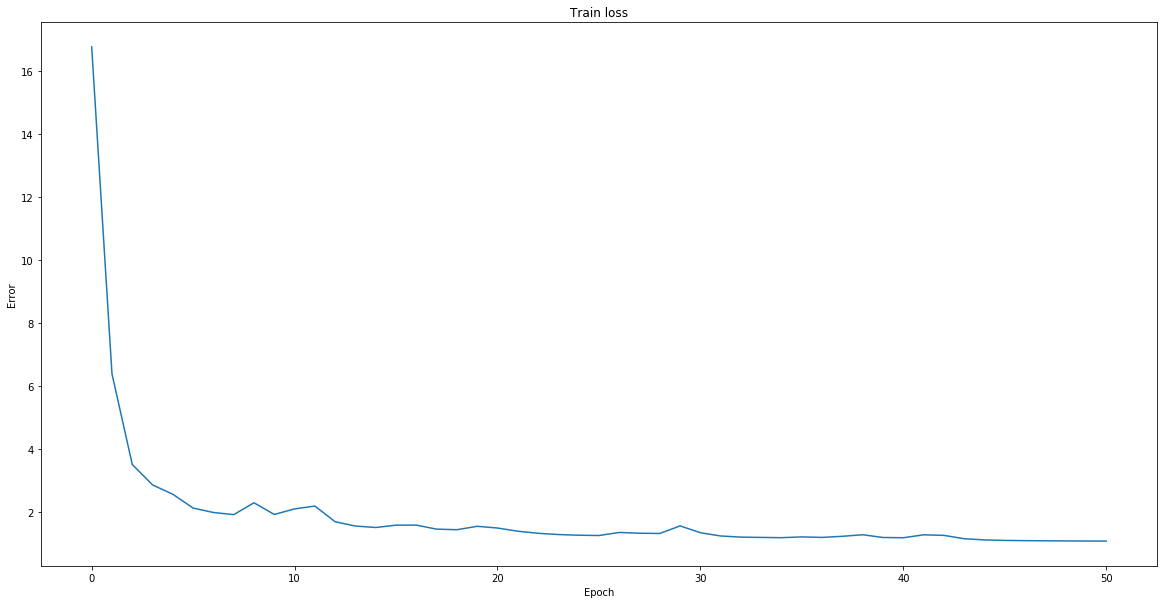

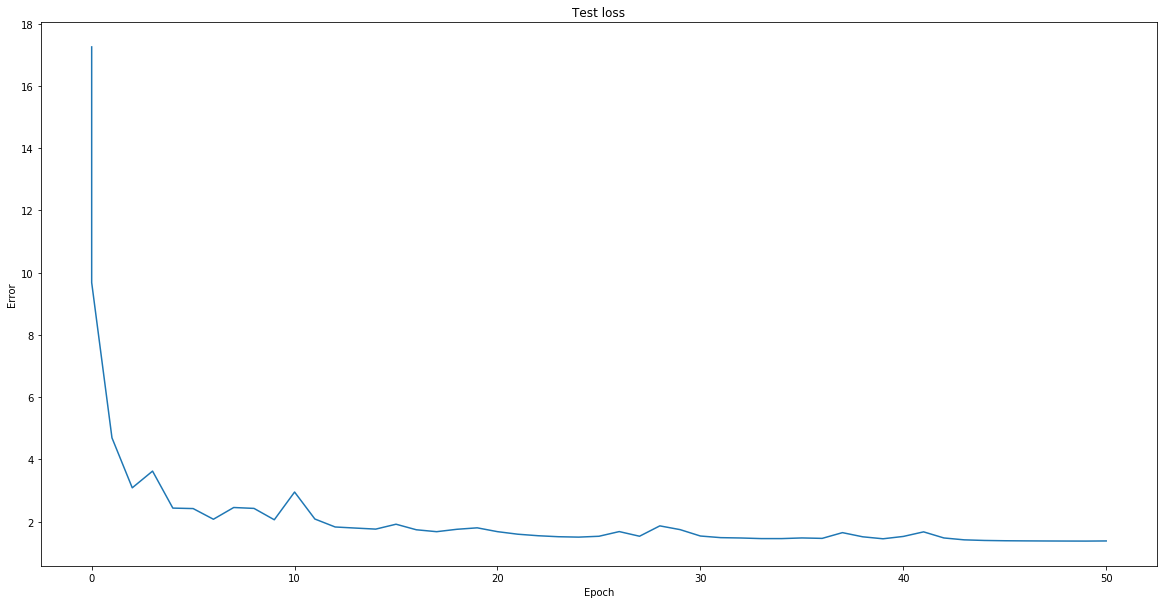

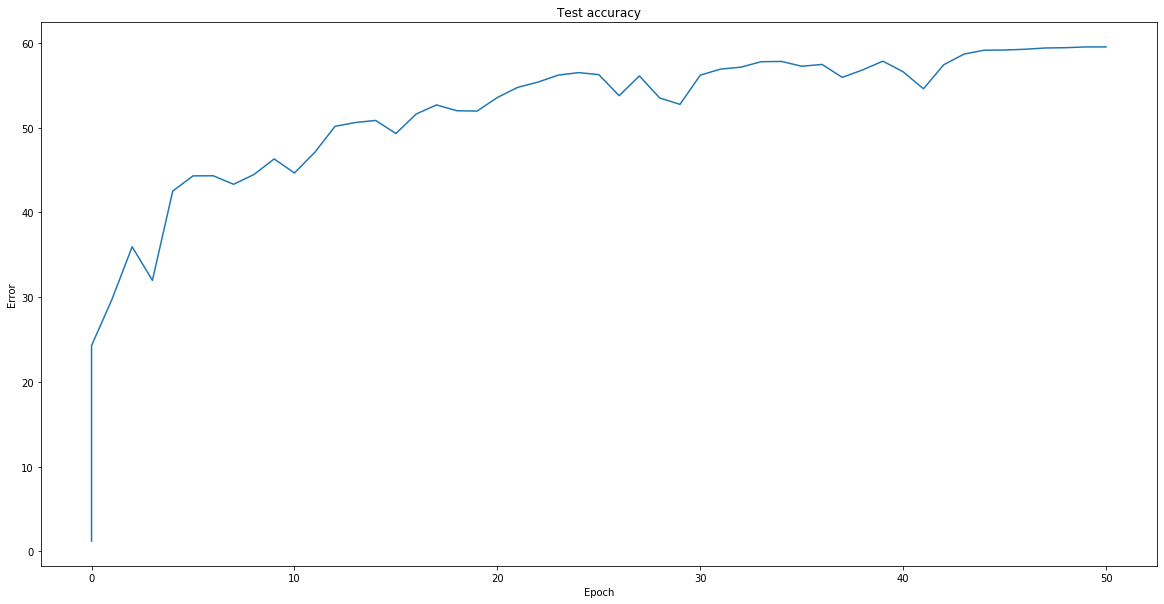

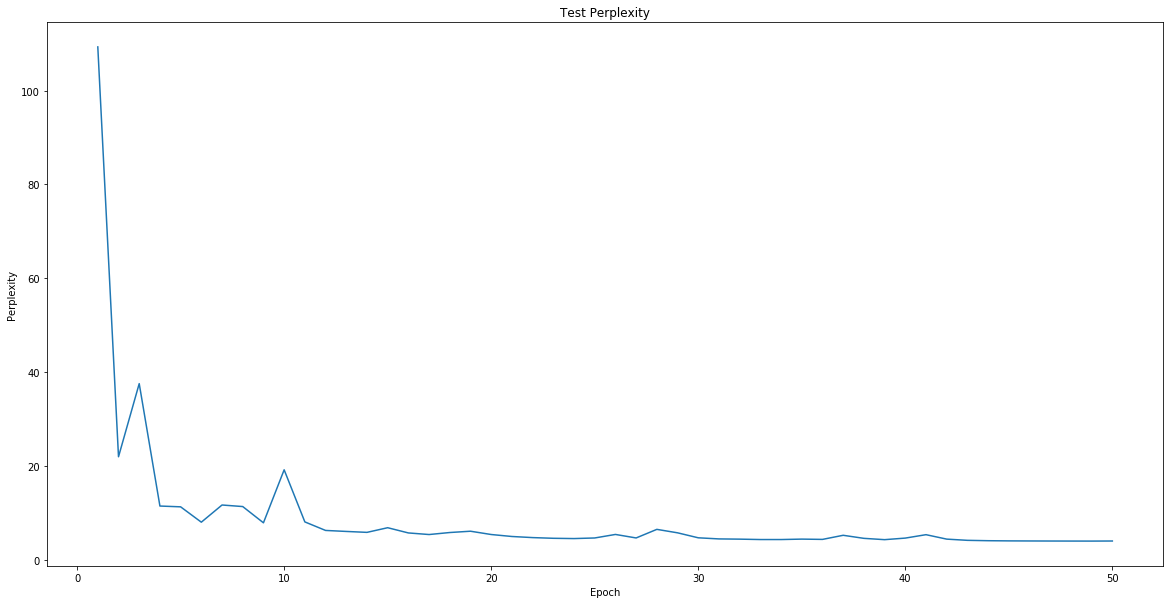

In [32]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 50
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'brief_history/logs/log.pkl'


    data_train = BriefHistoryDataset(DATA_PATH + 'a_brief_history_of_time_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = BriefHistoryDataset(DATA_PATH + 'a_brief_history_of_time_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = BriefHistoryNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'brief_history/checkpoints')

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))
    test_perplexities.append((start_epoch, test_perplexity))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            test_perplexities.append((epoch, test_perplexity))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'brief_history/checkpoints/%03d.pt' % epoch)
            seed_words = 'Black holes are '
            generated_sentence = generate_language(model, device, seed_words, 100, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 100, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 100, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'brief_history/checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep[2:], val[2:], 'Test Perplexity', 'Epoch', 'Perplexity')
        return model, vocab, device

final_model, vocab, device = main()

### LSTM on A Brief History of Time

In [0]:
class BriefHistoryLSTMNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(BriefHistoryLSTMNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_cell_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, (hidden_state, cell_state) = self.lstm(x, hidden_cell_state)
        x = self.decoder(x)
        return x, (hidden_state, cell_state)

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_cell_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_cell_state = self.forward(x, hidden_cell_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_cell_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

    def init_hidden_and_cell_state(self, sequence_length):
        weights = next(self.parameters()).data
        return (weights.new(1, sequence_length, self.feature_size).zero_(),
                weights.new(1, sequence_length, self.feature_size).zero_())
        

In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def repackage_cell(c):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(c, torch.Tensor):
        return c.detach()
    else:
        return tuple(repackage_cell(v) for v in c)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    cell = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        if cell is not None:
            cell = repackage_cell(cell)

        if hidden is None or cell is None:
            hidden, cell = model.init_hidden_and_cell_state(len(data))

        optimizer.zero_grad()
        output, (hidden, cell) = model(data, (hidden, cell))
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    hidden = None
    cell = None
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            if hidden is None  or cell is None:
                hidden, cell = model.init_hidden_and_cell_state(len(data))
            output, (hidden, cell) = model(data, (hidden, cell))
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_perplexity = torch.exp(torch.tensor(test_loss)).item()
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy, test_perplexity

Using device cuda
num workers: 2
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	eePzzoIeoy5PPePP1V Nee,eo,PPPPk  hPoOPPeUPo1CfrpPPBPBPBCfepppePPPCsC,erhz  ,P33Ef1eW65CCeeSePPzeC1ie




  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 8.5196, Accuracy: 2164/76800 (3%)



  8%|▊         | 1/12 [00:00<00:01,  6.14it/s]

Train Epoch: 0 [0/3072 (0%)]	Loss: 8.476341


100%|██████████| 12/12 [00:00<00:00, 14.05it/s]


Train Epoch: 0 [2560/3072 (83%)]	Loss: 5.309239
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	ederenednior eer  c df dnior er nkiohhndrennemrneen  wf dhnendSerearodore ni    dHatoer wS.pherer  d



Test set: Average loss: 4.5607, Accuracy: 20248/76800 (26%)

Saved /content/brief_history_lstm/checkpoints/000.pt

generated max		 Black holes are diniver wenouser warections diser wenouser warections diser wenouser warections diser wenouser warec
generated sample	 Black holes are mouser grenton grectiver winis lawenoser wand diser grecections diser gentonser wouser mouser dinis 
generated sample	 Black holes are diniver wouser winiver grearecety haver recety ser dinal sinis dinin. dand diser gre555LDDD9g disin 
generated sample	 Black holes are disiniver grexter wouser 7rections dinilitser diniver pouser mould diser difer p

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are mouser warections diser wenouser warections diser wenouser warections diser wenouser warections dise



  8%|▊         | 1/12 [00:00<00:01,  6.04it/s]

Train Epoch: 1 [0/3072 (0%)]	Loss: 4.530488


100%|██████████| 12/12 [00:00<00:00, 14.25it/s]


Train Epoch: 1 [2560/3072 (83%)]	Loss: 2.675667
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 iettcetn  rsear  tstfetn  rsylltk,cairiress tit a y of thmesioerha  iitssn  ...Ahavterso90ihotir  o



Test set: Average loss: 2.5509, Accuracy: 26671/76800 (35%)

Saved /content/brief_history_lstm/checkpoints/001.pt

generated max		 Black holes are in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in i
generated sample	 Black holes are the anthe of crre of of ity ars moons comomits not , ars in the to in thers freoreas whavity of the 
generated sample	 Black holes are the free in whand to nereses is itthe cromomin onsing the of the in 19ke in it niverses ittat whaver
generated sample	 Black holes are of the cansionns in ficring ons in of ares in ficre suse the prin all anth whave

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in i



  8%|▊         | 1/12 [00:00<00:01,  6.35it/s]

Train Epoch: 2 [0/3072 (0%)]	Loss: 2.449664


100%|██████████| 12/12 [00:00<00:00, 14.55it/s]

Train Epoch: 2 [2560/3072 (83%)]	Loss: 2.154806


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 teteeetn  rsea yyrttfetn  rsyllrkioat iree  tas a e af thme tt r e  tawk ng    Ihavperst  thote y I



Test set: Average loss: 2.1844, Accuracy: 30399/76800 (40%)

Saved /content/brief_history_lstm/checkpoints/002.pt

generated max		 Black holes are the the a the the the a the the the a the the the a the the the a the the the a the the the a the th
generated sample	 Black holes are in the Eus in a the gravityimple ing the con the the of a by on a inces to a complartion the a conly
generated sample	 Black holes are on sue and be cone the an the is the be a by a be that a not an the whicle it and the roverse univer
generated sample	 Black holes are priey ing be in to a in a in the a sto the and to int the the the som the ver, a that a be beve a so
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are of the the a the the the a the the the a the the the a the the the a the the the a the the the a the



  8%|▊         | 1/12 [00:00<00:01,  6.42it/s]

Train Epoch: 3 [0/3072 (0%)]	Loss: 2.088162


100%|██████████| 12/12 [00:00<00:00, 14.72it/s]


Train Epoch: 3 [2560/3072 (83%)]	Loss: 1.937787
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tettcetn  r ea lytttfetn  r ylarkioltttrees tis     tf thme tterhe  tiwking ...Thapper t9 thoti e T



Test set: Average loss: 2.0270, Accuracy: 32504/76800 (42%)

Saved /content/brief_history_lstm/checkpoints/003.pt

generated max		 Black holes are the the the the the the the the the the the the the the the the the the the the the the the the the 
generated sample	 Black holes are reatted cause the the the the cons a be notter the the state ated the sume same in the the the of th
generated sample	 Black holes are not the se and the space be universe the dicall a that that the startions all the stat the the the u
generated sample	 Black holes are prot the dict the the of the of the speries have on ther St be discor the prelig

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the the the the the the the the the the the the the the the the the the the the the the the the the 



  8%|▊         | 1/12 [00:00<00:01,  6.23it/s]

Train Epoch: 4 [0/3072 (0%)]	Loss: 1.925885


100%|██████████| 12/12 [00:00<00:00, 14.45it/s]


Train Epoch: 4 [2560/3072 (83%)]	Loss: 1.824768
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tectnetn  r ear  titf tn  r ylatkioltttriesftist    tf time tterhe  tawking .  Thavter t9 thoti e T



Test set: Average loss: 1.9331, Accuracy: 33766/76800 (44%)

Saved /content/brief_history_lstm/checkpoints/004.pt

generated max		 Black holes are the the the the the the the the the the the the the the the the the the the the the the the the the 
generated sample	 Black holes are and be unive the se tore the stall the the as the universe of the preartical that the sountere of of
generated sample	 Black holes are not the the the be of the the preaction of the the so the of the ther in the of the sure the in the 
generated sample	 Black holes are that the the a lack holes of the pround moverse the the suniverse of stations a 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the the the the the the the the the the the the the the the the the the the the the the the the the 



  8%|▊         | 1/12 [00:00<00:01,  6.18it/s]

Train Epoch: 5 [0/3072 (0%)]	Loss: 1.823272


100%|██████████| 12/12 [00:00<00:00, 14.60it/s]


Train Epoch: 5 [2560/3072 (83%)]	Loss: 1.741741
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tettnetn  r ear  titf tn  r ylarkioltttries tist r  tf time tterher tawking .  Thapter t9 thoti   A



Test set: Average loss: 1.8586, Accuracy: 34863/76800 (45%)

Saved /content/brief_history_lstm/checkpoints/005.pt

generated max		 Black holes are the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure t
generated sample	 Black holes are for thes some that the sure gas it Time a is an ther of that the galaxies the not that the robse the
generated sample	 Black holes are briection as to so the wer ound the cans of the and or ding to starticle the universe se react of ma
generated sample	 Black holes are universe, the sure the at the the sear the of the starticles of the a fing the l

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure t



  8%|▊         | 1/12 [00:00<00:01,  6.23it/s]

Train Epoch: 6 [0/3072 (0%)]	Loss: 1.742761


100%|██████████| 12/12 [00:00<00:00, 14.69it/s]


Train Epoch: 6 [2560/3072 (83%)]	Loss: 1.675356
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tettnetn  r eadlytitf tn  r ylaxkioattiries tistory of time tterher tawking .. Thapter t9 thoti   T



Test set: Average loss: 1.8034, Accuracy: 35922/76800 (47%)

Saved /content/brief_history_lstm/checkpoints/006.pt

generated max		 Black holes are the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure t
generated sample	 Black holes are Nobser was and be and the rear the in the in a station of the same the can ature in the ener an cle 
generated sample	 Black holes are and be will and the sear the sure to the of the in a come of the reat morde is to not is starticle t
generated sample	 Black holes are and the can are for bries a suniverse the could the the the we evenere in the ca

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure t



  8%|▊         | 1/12 [00:00<00:01,  5.99it/s]

Train Epoch: 7 [0/3072 (0%)]	Loss: 1.682551


100%|██████████| 12/12 [00:00<00:00, 14.15it/s]

Train Epoch: 7 [2560/3072 (83%)]	Loss: 1.620586


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetpnetn  r eadlytitf tn  r ylaxkioattiries tistory of time ttemher tawking... Thapter t9 ihoci   T



Test set: Average loss: 1.7577, Accuracy: 36911/76800 (48%)

Saved /content/brief_history_lstm/checkpoints/007.pt

generated max		 Black holes are the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure t
generated sample	 Black holes are distory of has such to and and the be round the se in the same the sure and the sund the event eary 
generated sample	 Black holes are cone the the expland the the in the the in the would meass of the pround begince of the in the and t
generated sample	 Black holes are of the partic and all from the universe the be and other collosition of the cont in that the stans t
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure t



  8%|▊         | 1/12 [00:00<00:01,  6.15it/s]

Train Epoch: 8 [0/3072 (0%)]	Loss: 1.632715


100%|██████████| 12/12 [00:00<00:00, 14.34it/s]


Train Epoch: 8 [2560/3072 (83%)]	Loss: 1.573592
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetpnetn  r eadlyt tf tn  r ylaxkioattBrief tistory of time ttemher tawking... Chapter t9 ihaci e T



Test set: Average loss: 1.7194, Accuracy: 37832/76800 (49%)

Saved /content/brief_history_lstm/checkpoints/008.pt

generated max		 Black holes are the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure t
generated sample	 Black holes are is speary of gene the stars one Rot the statemperse the of the with was the pacetical that the elson
generated sample	 Black holes are is that the comple the probserverse to big back holes mored the so and the example in the in the sta
generated sample	 Black holes are know to a black hole proporticles the be same the such the and and the preent in

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure t



  8%|▊         | 1/12 [00:00<00:01,  5.90it/s]

Train Epoch: 9 [0/3072 (0%)]	Loss: 1.588237


100%|██████████| 12/12 [00:00<00:00, 14.48it/s]

Train Epoch: 9 [2560/3072 (83%)]	Loss: 1.531975


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tedpnetn  r eadyyt tf tn  r ylaxkioattBrief tistory of time ttemher tawking... Chapter t9 ihaci e T



Test set: Average loss: 1.6844, Accuracy: 38475/76800 (50%)

Saved /content/brief_history_lstm/checkpoints/009.pt

generated max		 Black holes are the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure t
generated sample	 Black holes are have to the singly the black holes the scien the later mally be such the be can form the starticles 
generated sample	 Black holes are observerse more the seence arge the sing the and the universe belfectrons completer in the would con
generated sample	 Black holes are the speent the a of the universe that the universe of the it in the so lects and pastarity the surfa
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure the sure t



  8%|▊         | 1/12 [00:00<00:01,  6.18it/s]

Train Epoch: 10 [0/3072 (0%)]	Loss: 1.548347


100%|██████████| 12/12 [00:00<00:00, 14.56it/s]

Train Epoch: 10 [2560/3072 (83%)]	Loss: 1.494517


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tedpnetn or  adyyt tf tn er ylaxkio ttBrief tistory of time ttepher tawking... Chapter t9 ihace y T



Test set: Average loss: 1.6518, Accuracy: 39245/76800 (51%)

Saved /content/brief_history_lstm/checkpoints/010.pt

generated max		 Black holes are the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder t
generated sample	 Black holes are different were in a such in the sunce the suncery that inter in their and so the universe have the u
generated sample	 Black holes are a starticles thing bout the completed the same to stars in the secont was all have that there of the
generated sample	 Black holes are we was of the at the and pose the the galaxies the seconding to the particle the universe the conly 
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder t



  8%|▊         | 1/12 [00:00<00:01,  6.18it/s]

Train Epoch: 11 [0/3072 (0%)]	Loss: 1.511684


100%|██████████| 12/12 [00:00<00:00, 14.52it/s]

Train Epoch: 11 [2560/3072 (83%)]	Loss: 1.459305


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tedpnetn or  adyyt tf tn er ylaxkio alBrief tistory of time ttephen tawking... Chapter t9 ihace y T



Test set: Average loss: 1.6223, Accuracy: 39784/76800 (52%)

Saved /content/brief_history_lstm/checkpoints/011.pt

generated max		 Black holes are the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder t
generated sample	 Black holes are in the evento fall should be relativity in the are energy or the singularity or the energy and the e
generated sample	 Black holes are and the the space of the the expanding can in a starticles the singularitic and the controm and the 
generated sample	 Black holes are in the different form a commont should have the shat that the speed that the such an the universe th
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder t



  8%|▊         | 1/12 [00:00<00:01,  6.02it/s]

Train Epoch: 12 [0/3072 (0%)]	Loss: 1.478733


100%|██████████| 12/12 [00:00<00:00, 14.50it/s]


Train Epoch: 12 [2560/3072 (83%)]	Loss: 1.427128
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tedpn tn or  adyyt tf tn er ylaxkio alBrief tistory of time ttephen tawking... Chapter t  shace y T



Test set: Average loss: 1.5937, Accuracy: 40276/76800 (52%)

Saved /content/brief_history_lstm/checkpoints/012.pt

generated max		 Black holes are the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder t
generated sample	 Black holes are Time of the seements the to stars and the spacetime a stars and the proton, the universe is that the
generated sample	 Black holes are stately diffected the conting to and in the particles of the universe in the universe and set is the
generated sample	 Black holes are a could below that the the definite collapse, but the same the a stars of a the

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder t



  8%|▊         | 1/12 [00:00<00:01,  6.08it/s]

Train Epoch: 13 [0/3072 (0%)]	Loss: 1.447696


100%|██████████| 12/12 [00:00<00:00, 14.42it/s]

Train Epoch: 13 [2560/3072 (83%)]	Loss: 1.398147


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tedpn tn or  anyyt tf tn or ylaxkio alBrief History of time ttephen tawking... Chapter t  shave y T



Test set: Average loss: 1.5689, Accuracy: 40981/76800 (53%)

Saved /content/brief_history_lstm/checkpoints/013.pt

generated max		 Black holes are the such and the such and the such and the such and the such and the such and the such and the such 
generated sample	 Black holes are and in a conding the supposing the early and the can of one that the star of the corre of the proton
generated sample	 Black holes are the state down the galaxies the been in the well between that the universe that the explane cannot a
generated sample	 Black holes are theory of space of there discover would have be force the would stars and the matter that dear the t
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the such and the such and the such and the such and the such and the such and the such and the such 



  8%|▊         | 1/12 [00:00<00:01,  5.77it/s]

Train Epoch: 14 [0/3072 (0%)]	Loss: 1.419919


100%|██████████| 12/12 [00:00<00:00, 13.95it/s]

Train Epoch: 14 [2560/3072 (83%)]	Loss: 1.370655


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 aetpe tn or   nyyt tf tn or ylaxkio alBrief History of time ttephen tawking... Chapter t  shavele T



Test set: Average loss: 1.5468, Accuracy: 41467/76800 (54%)

Saved /content/brief_history_lstm/checkpoints/014.pt

generated max		 Black holes are the sun the such and the such and the such and the such and the such and the such and the such and t
generated sample	 Black holes are quarks the energy that the proposal be be the particles different if the same the energy of the univ
generated sample	 Black holes are in the form the particles and it would have time new the particles in the star the each other that t
generated sample	 Black holes are different particle from one in the that discover have mageter that the black hole, which its of the 
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the sun the such and the such and the such and the such and the such and the such and the such and t



  8%|▊         | 1/12 [00:00<00:01,  6.13it/s]

Train Epoch: 15 [0/3072 (0%)]	Loss: 1.394492


100%|██████████| 12/12 [00:00<00:00, 14.47it/s]


Train Epoch: 15 [2560/3072 (83%)]	Loss: 1.344737
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 aetpe tn or   nyyt tf tn or ytaxtio alBrief History of time ttephen tawking... Chapter t  shavele T



Test set: Average loss: 1.5256, Accuracy: 41900/76800 (55%)

Saved /content/brief_history_lstm/checkpoints/015.pt

generated max		 Black holes are the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the 
generated sample	 Black holes are and position really the eliver of the universe complet that particles that the universe would be and
generated sample	 Black holes are 8 pricited one not in in the could be sun and field the back hole, the universe any the probable to 
generated sample	 Black holes are not of the universe predicted of the same that radiational formed then with a b

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the sun the 



  8%|▊         | 1/12 [00:00<00:01,  6.31it/s]

Train Epoch: 16 [0/3072 (0%)]	Loss: 1.370628


100%|██████████| 12/12 [00:00<00:00, 14.33it/s]

Train Epoch: 16 [2560/3072 (83%)]	Loss: 1.321334


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 aetpe tn or   nyyt tf tn or ytaxtioaalBrief History of time ttephen tawking... Chapter t  shavele T



Test set: Average loss: 1.5073, Accuracy: 42115/76800 (55%)

Saved /content/brief_history_lstm/checkpoints/016.pt

generated max		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t
generated sample	 Black holes are found to and state beloweven that the universe. It because the the late the same in the early univer
generated sample	 Black holes are speed out was are and the universe the universe. The elimitted the earth in and the come the earthin
generated sample	 Black holes are about the particles in the universe event the creative the universe its make down the the expansion 
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are and the same the same the same the same the same the same the same the same the same the same the sa



  8%|▊         | 1/12 [00:00<00:01,  6.28it/s]

Train Epoch: 17 [0/3072 (0%)]	Loss: 1.349702


100%|██████████| 12/12 [00:00<00:00, 14.51it/s]

Train Epoch: 17 [2560/3072 (83%)]	Loss: 1.300783


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tatin tn or   nyyt tf tn or ytaxtioaalBrief History of time ttephen tawking... Chapter t  shavel  T



Test set: Average loss: 1.4926, Accuracy: 42307/76800 (55%)

Saved /content/brief_history_lstm/checkpoints/017.pt

generated max		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t
generated sample	 Black holes are and up to present of the at the form the be a light the same in a black hole event for the started b
generated sample	 Black holes are A Brief Histrong and the more large at about at and the same in inite direction also idea the at dir
generated sample	 Black holes are expanding the earth to force of the with theory of the universe is a sundame may because the planets
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t



  8%|▊         | 1/12 [00:00<00:01,  6.16it/s]

Train Epoch: 18 [0/3072 (0%)]	Loss: 1.332196


100%|██████████| 12/12 [00:00<00:00, 14.31it/s]

Train Epoch: 18 [2560/3072 (83%)]	Loss: 1.281910


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tatia tn or   nyyt tf tn or ytattivaalBrief History of time Stephen tawking... Chapter t  shavel  T



Test set: Average loss: 1.4790, Accuracy: 42686/76800 (56%)

Saved /content/brief_history_lstm/checkpoints/018.pt

generated max		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t
generated sample	 Black holes are and its a reveloper the way the same the expansion of the seen Hawking... Chapter that a the reality
generated sample	 Black holes are spacetime the eir at the universe a compose the speent on the extements confinite have the state of 
generated sample	 Black holes are in the passed of the universe of the first the particles of the past the particles an the stated a s
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t



  8%|▊         | 1/12 [00:00<00:01,  6.12it/s]

Train Epoch: 19 [0/3072 (0%)]	Loss: 1.315539


100%|██████████| 12/12 [00:00<00:00, 14.70it/s]


Train Epoch: 19 [2560/3072 (83%)]	Loss: 1.262872
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tatin tn or   nyyt tf tn or ytattivaalBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.4636, Accuracy: 43096/76800 (56%)

Saved /content/brief_history_lstm/checkpoints/019.pt

generated max		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t
generated sample	 Black holes are position of the universe with the universe in the pases the event in the universe it would be to be 
generated sample	 Black holes are the on the same that as a have the not be a black hole that the universe. The energy of the sun an n
generated sample	 Black holes are not all the particles the the say the earth is that the first with the earch ot

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t



  8%|▊         | 1/12 [00:00<00:01,  6.12it/s]

Train Epoch: 20 [0/3072 (0%)]	Loss: 1.296647


100%|██████████| 12/12 [00:00<00:00, 14.38it/s]


Train Epoch: 20 [2560/3072 (83%)]	Loss: 1.245918
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetin tn or   nyyt tf tn or ynattivaalBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.4491, Accuracy: 43497/76800 (57%)

Saved /content/brief_history_lstm/checkpoints/020.pt

generated max		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t
generated sample	 Black holes are a laws the position of million of the universe a singularity the seements of the not the was because
generated sample	 Black holes are The really the expent of the particles to be searly and the believed that the same for the Sunce of 
generated sample	 Black holes are could to be are to the principle firse, in a first its not the energy the oles 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t



  8%|▊         | 1/12 [00:00<00:01,  6.26it/s]

Train Epoch: 21 [0/3072 (0%)]	Loss: 1.279182


100%|██████████| 12/12 [00:00<00:00, 14.54it/s]

Train Epoch: 21 [2560/3072 (83%)]	Loss: 1.231197


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetid tn or   nyyt tf tn or ynattivaalBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.4353, Accuracy: 43786/76800 (57%)

Saved /content/brief_history_lstm/checkpoints/021.pt

generated max		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t
generated sample	 Black holes are that with the the energy that the big bang moon that the source the passed by the early universe tha
generated sample	 Black holes are universe have are not be the only in the inside the particle all theory of there is to described the
generated sample	 Black holes are this particles are on the singularity the only we the the universe is like they in the universe that
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t



  8%|▊         | 1/12 [00:00<00:01,  6.40it/s]

Train Epoch: 22 [0/3072 (0%)]	Loss: 1.263190


100%|██████████| 12/12 [00:00<00:00, 14.53it/s]

Train Epoch: 22 [2560/3072 (83%)]	Loss: 1.216750


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetid tn or   nyyt tf tn or ynattivaalBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.4230, Accuracy: 44027/76800 (57%)

Saved /content/brief_history_lstm/checkpoints/022.pt

generated max		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 
generated sample	 Black holes are 2 its and the earth is allowed that the universe is the puth other in the motion of model in the sam
generated sample	 Black holes are complose to be very however, a be speed to be event of the same to according to some the early unive
generated sample	 Black holes are particles are star, a such a same expanding to a condition of the different to the point con is cont
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 



  8%|▊         | 1/12 [00:00<00:01,  6.34it/s]

Train Epoch: 23 [0/3072 (0%)]	Loss: 1.248512


100%|██████████| 12/12 [00:00<00:00, 14.46it/s]

Train Epoch: 23 [2560/3072 (83%)]	Loss: 1.204253


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetid tn or   nyyt tf tn or ynattivaalBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.4130, Accuracy: 44208/76800 (58%)

Saved /content/brief_history_lstm/checkpoints/023.pt

generated max		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t
generated sample	 Black holes are as that the universe we wave there is down at it is proposal at the started the particle to the gala
generated sample	 Black holes are large a made to a made the produce it stars of the the speed of the particles of the the sun our the
generated sample	 Black holes are existent recording the universe would be some in 1960 is are first of there the turn the paths in th
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t



  8%|▊         | 1/12 [00:00<00:01,  6.18it/s]

Train Epoch: 24 [0/3072 (0%)]	Loss: 1.235330


100%|██████████| 12/12 [00:00<00:00, 14.36it/s]

Train Epoch: 24 [2560/3072 (83%)]	Loss: 1.193474


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetid tn ore  nlyt tf tn or ynattivaalBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.4057, Accuracy: 44331/76800 (58%)

Saved /content/brief_history_lstm/checkpoints/024.pt

generated max		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t
generated sample	 Black holes are not however, we the start the specially the particles of the universe in the sun the force the real 
generated sample	 Black holes are before the more the spectrons would that the universe to start the universe that the expansion the f
generated sample	 Black holes are may be the other seemed the energy in the model in the he look atter with the long and a singulariti
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t



  8%|▊         | 1/12 [00:00<00:01,  6.39it/s]

Train Epoch: 25 [0/3072 (0%)]	Loss: 1.224757


100%|██████████| 12/12 [00:00<00:00, 14.42it/s]

Train Epoch: 25 [2560/3072 (83%)]	Loss: 1.181719


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidltn ore  nlyt tf tn oreynattivaalBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.3978, Accuracy: 44486/76800 (58%)

Saved /content/brief_history_lstm/checkpoints/025.pt

generated max		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t
generated sample	 Black holes are the universe the moon like down the into make theory that we the same that it describe of the same i
generated sample	 Black holes are the electron of the more so allowed the there would not be seem to the at the black holes the speed 
generated sample	 Black holes are universe of the same would all the seen decrease the start to such the same that the stars time from
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t



  8%|▊         | 1/12 [00:00<00:01,  6.20it/s]

Train Epoch: 26 [0/3072 (0%)]	Loss: 1.213855


100%|██████████| 12/12 [00:00<00:00, 14.46it/s]

Train Epoch: 26 [2560/3072 (83%)]	Loss: 1.168674


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidltn ore  nlyt tfbtn oreynattivaalBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.3909, Accuracy: 44673/76800 (58%)

Saved /content/brief_history_lstm/checkpoints/026.pt

generated max		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t
generated sample	 Black holes are in space in the same the energy were theory conditions at the surface of the first the move the regi
generated sample	 Black holes are at the same principle, coness that the universe is the hoter the same in the universe is the electro
generated sample	 Black holes are completely get comes that the present to the universe would be clear the started that the universe i
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same the same the same the same the same the same the same the same the same the same the same t



  8%|▊         | 1/12 [00:00<00:01,  6.07it/s]

Train Epoch: 27 [0/3072 (0%)]	Loss: 1.204134


100%|██████████| 12/12 [00:00<00:00, 14.24it/s]

Train Epoch: 27 [2560/3072 (83%)]	Loss: 1.157616


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidltn oretanlyt tfbtn orsynattivaalBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.3856, Accuracy: 44742/76800 (58%)

Saved /content/brief_history_lstm/checkpoints/027.pt

generated max		 Black holes are the same the stars that the same the stars that the same the stars that the same the stars that the 
generated sample	 Black holes are success that the present in the started that the position of the constant large not set the same of 
generated sample	 Black holes are the stars to be so attraction of the universe is the therefore the to success that it the time betwe
generated sample	 Black holes are and the surface space it the same time in the universe to the started that the the slowed that the p
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are not the same the stars that the same the stars that the same the stars that the same the stars that 



  8%|▊         | 1/12 [00:00<00:01,  6.27it/s]

Train Epoch: 28 [0/3072 (0%)]	Loss: 1.195715


100%|██████████| 12/12 [00:00<00:00, 14.55it/s]

Train Epoch: 28 [2560/3072 (83%)]	Loss: 1.147265


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidltn oretanlyt tfbtn oreynattivatlBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.3784, Accuracy: 44872/76800 (58%)

Saved /content/brief_history_lstm/checkpoints/028.pt

generated max		 Black holes are the started the started the started the started the started the started the started the started the 
generated sample	 Black holes are correspond to the matter of the light was a spacetime forces of the space first the sun that there i
generated sample	 Black holes are general relativity with the new of the same stars at a conclusion that the universe describe the the
generated sample	 Black holes are stars and the electron was a finite it does this or expands to the universe were theory of the quest
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the started the started the started the started the started the started the started the started the 



  8%|▊         | 1/12 [00:00<00:01,  6.19it/s]

Train Epoch: 29 [0/3072 (0%)]	Loss: 1.184922


100%|██████████| 12/12 [00:00<00:00, 14.44it/s]

Train Epoch: 29 [2560/3072 (83%)]	Loss: 1.137880


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidltn oretanlyt tfbtn orsynattiv tlBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.3712, Accuracy: 45020/76800 (59%)

Saved /content/brief_history_lstm/checkpoints/029.pt

generated max		 Black holes are the stars that the same to the same to the same to the same to the same to the same to the same to t
generated sample	 Black holes are to expanding to the past the energy theory of the earth as the time the speed of the universe is a c
generated sample	 Black holes are are be seems to the most that the indition of the universe would not the started of the past the exp
generated sample	 Black holes are made theory of the universe to the speed of the first and the earth it is the event to the speed of 
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the stars that the same to the same to the same to the same to the same to the same to the same to t



  8%|▊         | 1/12 [00:00<00:01,  6.16it/s]

Train Epoch: 30 [0/3072 (0%)]	Loss: 1.173927


100%|██████████| 12/12 [00:00<00:00, 14.55it/s]

Train Epoch: 30 [2560/3072 (83%)]	Loss: 1.128590


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidltn orvtinlit tfbtn orvynattiv tlBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.3652, Accuracy: 45193/76800 (59%)

Saved /content/brief_history_lstm/checkpoints/030.pt

generated max		 Black holes are the sun the same to the same to the same to the same to the same to the same to the same to the same
generated sample	 Black holes are the significant of the time was to be the expanding the the expansion of the same position to the en
generated sample	 Black holes are started to the star to the contracted by something the stars that the other that the universe is the
generated sample	 Black holes are Stephen the same theory with solution of the universe were the sun or the surface of the stars suppo
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are not the same to the same to the same to the same to the same to the same to the same to the same to 



  8%|▊         | 1/12 [00:00<00:01,  6.24it/s]

Train Epoch: 31 [0/3072 (0%)]	Loss: 1.164545


100%|██████████| 12/12 [00:00<00:00, 14.59it/s]

Train Epoch: 31 [2560/3072 (83%)]	Loss: 1.120361


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidltn orvtinlit tfbtn orvynattiv tlBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.3606, Accuracy: 45347/76800 (59%)

Saved /content/brief_history_lstm/checkpoints/031.pt

generated max		 Black holes are the sun the same to the same to the same to the same to the same to the same to the same to the same
generated sample	 Black holes are set that it is the space. The continue to the universe is the galaxy in the energy to the the first 
generated sample	 Black holes are the singularity with the direction of the speed of the same with the same from the result the strong
generated sample	 Black holes are such a large to set of the expanding recollapse with the same to the time these that it would be sec
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the sun the same to the same to the same to the same to the same to the same to the same to the same



  8%|▊         | 1/12 [00:00<00:01,  6.26it/s]

Train Epoch: 32 [0/3072 (0%)]	Loss: 1.156790


100%|██████████| 12/12 [00:00<00:00, 14.45it/s]


Train Epoch: 32 [2560/3072 (83%)]	Loss: 1.112769
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidltn orvtinlit tfbtn orvynattiv tlBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.3569, Accuracy: 45453/76800 (59%)

Saved /content/brief_history_lstm/checkpoints/032.pt

generated max		 Black holes are the sun the same to the same to the same to the same to the same to the same to the same to the same
generated sample	 Black holes are theory of Time Stephen Hawking... Chapter of the electron that the such other was region of the star
generated sample	 Black holes are and the universe to be the look in the surface of the next agree theorem, because the same it was th
generated sample	 Black holes are relativity was that the source of the universe contracting of the position of t

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the sun the same to the same to the same to the same to the same to the same to the same to the same



  8%|▊         | 1/12 [00:00<00:01,  6.09it/s]

Train Epoch: 33 [0/3072 (0%)]	Loss: 1.149764


100%|██████████| 12/12 [00:00<00:00, 14.22it/s]

Train Epoch: 33 [2560/3072 (83%)]	Loss: 1.104512


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidltn orftinlit tfbtn orvynattiv tlBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.3531, Accuracy: 45547/76800 (59%)

Saved /content/brief_history_lstm/checkpoints/033.pt

generated max		 Black holes are the sun the same to the same to the same to the same to the same to the same to the same to the same
generated sample	 Black holes are source that the speeds of the spacetime surface of a stars of models the sun to form of time in the 
generated sample	 Black holes are could of the speed of the universe would have stars would not one theory of galaxy, the same of the 
generated sample	 Black holes are stars in the started the time, then the sun on the created that the same from the surface of the lat
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the sun the same to the same to the same to the same to the same to the same to the same to the same



  8%|▊         | 1/12 [00:00<00:01,  6.08it/s]

Train Epoch: 34 [0/3072 (0%)]	Loss: 1.142520


100%|██████████| 12/12 [00:00<00:00, 14.58it/s]


Train Epoch: 34 [2560/3072 (83%)]	Loss: 1.096650
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidltn orftinlit tfbtn orvynattiv tlBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.3501, Accuracy: 45606/76800 (59%)

Saved /content/brief_history_lstm/checkpoints/034.pt

generated max		 Black holes are the sun the same to the same to the same to the same to the same to the same to the same to the same
generated sample	 Black holes are models of the same to settle to the same stars to the set of the sun of the all theory of Time Steph
generated sample	 Black holes are moving there is the fate theories that the past up and in Hubble lesson that there are settle. The p
generated sample	 Black holes are time. They have been a the size of the sun and out the expands with it is the s

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the sun the same to the same to the same to the same to the same to the same to the same to the same



  8%|▊         | 1/12 [00:00<00:01,  6.32it/s]

Train Epoch: 35 [0/3072 (0%)]	Loss: 1.135713


100%|██████████| 12/12 [00:00<00:00, 14.48it/s]

Train Epoch: 35 [2560/3072 (83%)]	Loss: 1.089471


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidltn orftinlit tfbtn orvynattiv tlBrief History of time Stephen Hawking... Chapter t  shavel  T



Test set: Average loss: 1.3477, Accuracy: 45661/76800 (59%)

Saved /content/brief_history_lstm/checkpoints/035.pt

generated max		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 
generated sample	 Black holes are was the to position of a stars that the theory of the universe would set the condition of the univer
generated sample	 Black holes are should the universe that the start the laws of the universe would be configuration of the stars to t
generated sample	 Black holes are because the sun, but the earth of the sun on the universe would fall at the temperature the other th
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 



  8%|▊         | 1/12 [00:00<00:01,  6.08it/s]

Train Epoch: 36 [0/3072 (0%)]	Loss: 1.129726


100%|██████████| 12/12 [00:00<00:00, 14.52it/s]

Train Epoch: 36 [2560/3072 (83%)]	Loss: 1.082545


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidltn orftinlib tfbtn orvynattiv tlBrief History of Time Stephen Hawking... Chapter t  mhavel  T



Test set: Average loss: 1.3448, Accuracy: 45783/76800 (60%)

Saved /content/brief_history_lstm/checkpoints/036.pt

generated max		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 
generated sample	 Black holes are about the sun or the same is spacetime. The region of the sun and in some Stephen Hawking... Chapter
generated sample	 Black holes are moding the sun and the forces of the universe would be the same to the started of the star, but the 
generated sample	 Black holes are dis, the sun on the earth of the universe the position of the surface of the universe that the slow 
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 



  8%|▊         | 1/12 [00:00<00:01,  6.17it/s]

Train Epoch: 37 [0/3072 (0%)]	Loss: 1.123247


100%|██████████| 12/12 [00:00<00:00, 14.21it/s]

Train Epoch: 37 [2560/3072 (83%)]	Loss: 1.074715


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidltn orftinlib tfbtn orvynattiv flBrief History of Time Stephen Hawking... Chapter t  mhavel  T



Test set: Average loss: 1.3406, Accuracy: 45853/76800 (60%)

Saved /content/brief_history_lstm/checkpoints/037.pt

generated max		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 
generated sample	 Black holes are because the speed of these in the universe would be should the early still be the same to people in 
generated sample	 Black holes are A Brief History of Time Stephen Hawking... Chapter 2 you all the same to the stars that the sun, whi
generated sample	 Black holes are a finite with the follation of the boundary of the speeds to complete and the sun and the path of th
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 



  8%|▊         | 1/12 [00:00<00:01,  6.25it/s]

Train Epoch: 38 [0/3072 (0%)]	Loss: 1.115303


100%|██████████| 12/12 [00:00<00:00, 14.51it/s]


Train Epoch: 38 [2560/3072 (83%)]	Loss: 1.067356
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidltn orftinlib tfbtn orvynattiv flBrief History of Time Stephen Hawking... Chapter i  mhavel  T



Test set: Average loss: 1.3371, Accuracy: 45892/76800 (60%)

Saved /content/brief_history_lstm/checkpoints/038.pt

generated max		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 
generated sample	 Black holes are in the same that the same to detected that the universe in the universe them at complete for the con
generated sample	 Black holes are the attraction of the same strong the speeds of the most of the earth of the entropy of the stoody. 
generated sample	 Black holes are componess that the set of light like and the same of the universe had a beginni

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 



  8%|▊         | 1/12 [00:00<00:01,  6.25it/s]

Train Epoch: 39 [0/3072 (0%)]	Loss: 1.108181


100%|██████████| 12/12 [00:00<00:00, 14.49it/s]

Train Epoch: 39 [2560/3072 (83%)]	Loss: 1.062454


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidlon orftinlib tfbtn erferattiv flBrief History of Time Stephen Hawking... Chapter i  mhavel  T



Test set: Average loss: 1.3362, Accuracy: 45947/76800 (60%)

Saved /content/brief_history_lstm/checkpoints/039.pt

generated max		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 
generated sample	 Black holes are that is now path of the surface of the surface of the universe that it made up of the universe that 
generated sample	 Black holes are is not point in the same in the same in a slowed that the same of the expansion of the end of the su
generated sample	 Black holes are or the sun though the universe that it mass of the theory of Time Stephen Hawking... Chapter 2 So th
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 



  8%|▊         | 1/12 [00:00<00:01,  6.05it/s]

Train Epoch: 40 [0/3072 (0%)]	Loss: 1.103347


100%|██████████| 12/12 [00:00<00:00, 14.15it/s]

Train Epoch: 40 [2560/3072 (83%)]	Loss: 1.060274


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidlon orftinlib tfbtn erfer ttiv flBrief History of Time Stephen Hawking... Chapter i  mhavel  T



Test set: Average loss: 1.3393, Accuracy: 45916/76800 (60%)

generated max		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 
generated sample	 Black holes are Sound theory of the forces of the surface of a particle of the spectrum of symmetry between the same
generated sample	 Black holes are Friedmann some that is the same starts of the proton of the sun galaxy. As the same direction that a
generated sample	 Black holes are from the shorter that the speed of the size of a black hole is the time that is our second to a stat
generated sample	 Black holes are is that the same in the other the same in the p

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 



  8%|▊         | 1/12 [00:00<00:01,  6.15it/s]

Train Epoch: 41 [0/3072 (0%)]	Loss: 1.102418


100%|██████████| 12/12 [00:00<00:00, 14.59it/s]

Train Epoch: 41 [2560/3072 (83%)]	Loss: 1.055746


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidlos orftinlit tfbttterfer ttiv flBrief History of Time Stephen Hawking... Chapter i  mhavel  T



Test set: Average loss: 1.3490, Accuracy: 45569/76800 (59%)

generated max		 Black holes are the sun of the sun of the sun of the sun of the sun of the sun of the sun of the sun of the sun of t
generated sample	 Black holes are consequence of the same of the recollapse would measure that the sun that we see that can position i
generated sample	 Black holes are belowed. The be about the thousand million million million million million to one could not be so th
generated sample	 Black holes are nown as the total to the surface of spacetime it would be to be it is enough, they have been the wou
generated sample	 Black holes are is one measure that the rest cones, but the sam

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are so that the sun of the sun of the sun of the sun of the sun of the sun of the sun of the sun of the 



  8%|▊         | 1/12 [00:00<00:01,  6.14it/s]

Train Epoch: 42 [0/3072 (0%)]	Loss: 1.108158


100%|██████████| 12/12 [00:00<00:00, 14.50it/s]

Train Epoch: 42 [2560/3072 (83%)]	Loss: 1.089372


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tedidlts orf inlib tfbts erfelartiv flBrief History of Time Stephen Hawking... Chapter t  thavels T



Test set: Average loss: 1.3901, Accuracy: 45183/76800 (59%)

generated max		 Black holes are the same that the same that the same that the same that the same that the same that the same that th
generated sample	 Black holes are also finite different particles the pass that a particles that is convert that this passes of the sp
generated sample	 Black holes are the surface that the sun, and the sun, the same in the passes that is one consistent that the same t
generated sample	 Black holes are made that the same that the same of the same that the early universe would be the singularity that a
generated sample	 Black holes are of the first for the same that the smaller the 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same that the same that the same that the same that the same that the same that the same that th



  8%|▊         | 1/12 [00:00<00:01,  6.23it/s]

Train Epoch: 43 [0/3072 (0%)]	Loss: 1.144027


100%|██████████| 12/12 [00:00<00:00, 14.49it/s]

Train Epoch: 43 [2560/3072 (83%)]	Loss: 1.093868


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tatidltn orft dlit tb tttrrverattiv tlBrief History of Time Stephen Hawking... Chapter t  thavel  T



Test set: Average loss: 1.3661, Accuracy: 45453/76800 (59%)

generated max		 Black holes are so the same it the same in the same in the same in the same in the same in the same in the same in t
generated sample	 Black holes are become it is the past the forces of the laws that the same it was that the earth was the same and th
generated sample	 Black holes are the black holes with the force the spacetime between the same in the same at the same to anthropic i
generated sample	 Black holes are from the sun. One cannot be have been the same from the surface of the universe we should the same i
generated sample	 Black holes are Lits of the surface of the positions that the s

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are not the same in the same in the same in the same in the same in the same in the same in the same in 



  8%|▊         | 1/12 [00:00<00:01,  6.18it/s]

Train Epoch: 44 [0/3072 (0%)]	Loss: 1.125840


100%|██████████| 12/12 [00:00<00:00, 14.58it/s]

Train Epoch: 44 [2560/3072 (83%)]	Loss: 1.056710


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidlan orft dlib tbbtn orver rtiv alBrief History of Time Stephen Hawking... Chapter o  mhavel  T



Test set: Average loss: 1.3355, Accuracy: 46006/76800 (60%)

Saved /content/brief_history_lstm/checkpoints/044.pt

generated max		 Black holes are so the same to an antiquarks that the same to an antiquarks that the same to an antiquarks that the 
generated sample	 Black holes are seems to anthropic proton of the spresed the particles that were there were so survers of its propos
generated sample	 Black holes are waves and in described an in 1995, and the speed of the same to every direction of the partly and so
generated sample	 Black holes are all our galaxy. As the same of the surface of the universe would be able to the same to see the same
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same to an antiquarks that the same to an antiquarks that the same to an antiquarks that the sam



  8%|▊         | 1/12 [00:00<00:01,  6.01it/s]

Train Epoch: 45 [0/3072 (0%)]	Loss: 1.092980


100%|██████████| 12/12 [00:00<00:00, 14.44it/s]


Train Epoch: 45 [2560/3072 (83%)]	Loss: 1.038942
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidlan orfe dlib tbbtntorverartivialBrief History of Time Stephen Hawking... Chapter o  mhavel  T



Test set: Average loss: 1.3220, Accuracy: 46291/76800 (60%)

Saved /content/brief_history_lstm/checkpoints/045.pt

generated max		 Black holes are so the same in the same in the same in the same in the same in the same in the same in the same in t
generated sample	 Black holes are the speed of the expansion of the position of the source of galaxy will be devided in a complete con
generated sample	 Black holes are moving and cosmological arrow of the earth and the universe expanding the force of a star in the ear
generated sample	 Black holes are region of the universe in the inflationary models that the speed of the speed o

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are so the same in the same in the same in the same in the same in the same in the same in the same in t



  8%|▊         | 1/12 [00:00<00:01,  5.84it/s]

Train Epoch: 46 [0/3072 (0%)]	Loss: 1.073110


100%|██████████| 12/12 [00:00<00:00, 14.24it/s]

Train Epoch: 46 [2560/3072 (83%)]	Loss: 1.032714


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidlan orft dlib tbbtntorver rtivialBrief History of Time Stephen Hawking... Chapter o  mhavel  T



Test set: Average loss: 1.3217, Accuracy: 46342/76800 (60%)

Saved /content/brief_history_lstm/checkpoints/046.pt

generated max		 Black holes are so the same to the same to the same to the same to the same to the same to the same to the same to t
generated sample	 Black holes are the surface of a star could have surface of the universe and in the laws of our complete of the spee
generated sample	 Black holes are histories that the observing position of the universe that the speed of light sure of the universe f
generated sample	 Black holes are all the same in the socalled the same for an and the same in the singularity, one would be speed of 
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are not one of the surface of the surface of the surface of the surface of the surface of the surface of



  8%|▊         | 1/12 [00:00<00:01,  6.30it/s]

Train Epoch: 47 [0/3072 (0%)]	Loss: 1.071179


100%|██████████| 12/12 [00:00<00:00, 14.55it/s]


Train Epoch: 47 [2560/3072 (83%)]	Loss: 1.036028
Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidlan orft dlib tbbtntorver rtivialBrief History of Time Stephen Hawking... Chapter o  thavel  T



Test set: Average loss: 1.3438, Accuracy: 45694/76800 (59%)

generated max		 Black holes are to the sun or the sun or the sun or the sun or the sun or the sun or the sun or the sun or the sun o
generated sample	 Black holes are disorder sources of the universe source of the region of the book could and to the speed of the eart
generated sample	 Black holes are universe would have to say, the force of the universe to the speed of the surface of the book of gam
generated sample	 Black holes are so to the surface of the electromor is to agone of the particle of the solutions of the universe wou
generated sample	 Black holes ar

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are moving and antiparticles of the surface of the surface of the surface of the surface of the surface 



  8%|▊         | 1/12 [00:00<00:01,  6.10it/s]

Train Epoch: 48 [0/3072 (0%)]	Loss: 1.088609


100%|██████████| 12/12 [00:00<00:00, 14.43it/s]

Train Epoch: 48 [2560/3072 (83%)]	Loss: 1.035352


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidlan orftidiib trbtntrrver rtivialBrief History of Time Stephen Hawking... Chapter t  thavel  T



Test set: Average loss: 1.3248, Accuracy: 46356/76800 (60%)

Saved /content/brief_history_lstm/checkpoints/048.pt

generated max		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 
generated sample	 Black holes are there is the surface of the universe that it was see the mass of radio waves or about the same from 
generated sample	 Black holes are not about the sun and the size and the extra models to the surface of the entropy of the universe of
generated sample	 Black holes are like theory that the universe of the universe is entropy of the way theory hand, a particle of the s
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are many more the same to the same to the same to the same to the same to the same to the same to the sa



  8%|▊         | 1/12 [00:00<00:01,  6.18it/s]

Train Epoch: 49 [0/3072 (0%)]	Loss: 1.072177


100%|██████████| 12/12 [00:00<00:00, 14.42it/s]

Train Epoch: 49 [2560/3072 (83%)]	Loss: 1.012910


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidlan orftidlib trbtntorver rtivialBrief History of Time Stephen Hawking... Chapter t  thavel  T



Test set: Average loss: 1.3106, Accuracy: 46470/76800 (61%)

Saved /content/brief_history_lstm/checkpoints/049.pt

generated max		 Black holes are so the surface of the surface of the surface of the surface of the surface of the surface of the sur
generated sample	 Black holes are regions of the entropy of Time Stephen Hawking... Chapter on the force is not in the speed of light.
generated sample	 Black holes are moving away and the singularity with the surface of the histories are moving away to the expect to m
generated sample	 Black holes are seemed to the beginning and who so much it is not remember the speed of light means that and the pos
generated sample	 Black hol

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		 Black holes are the same in the same in the same in the same in the same in the same in the same in the same in the 



  8%|▊         | 1/12 [00:00<00:01,  5.99it/s]

Train Epoch: 50 [0/3072 (0%)]	Loss: 1.053460


100%|██████████| 12/12 [00:00<00:00, 14.39it/s]

Train Epoch: 50 [2560/3072 (83%)]	Loss: 1.006020


Input	s rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. 
GT	 rapid interstellar or intergalactic A Brief History of Time Stephen Hawking... Chapter 10 travel. A
pred	 tetidlan orft dlib tbbtntorver rtivealBrief History of Time Stephen Hawking... Chapter t  thavel  T



Test set: Average loss: 1.3114, Accuracy: 46482/76800 (61%)

Saved /content/brief_history_lstm/checkpoints/050.pt

generated max		 Black holes are the same to the same to the same to the same to the same to the same to the same to the same to the 
generated sample	 Black holes are singularity. It is the same in the same to our collapse to the same from the first to accelerated by
generated sample	 Black holes are and the complicated out of an emitting at a point of the early particles that there were there are e
generated sample	 Black holes are not on the collide. The position of the universe would be seen first or the planets on the two deali
generated sample	 Black hol

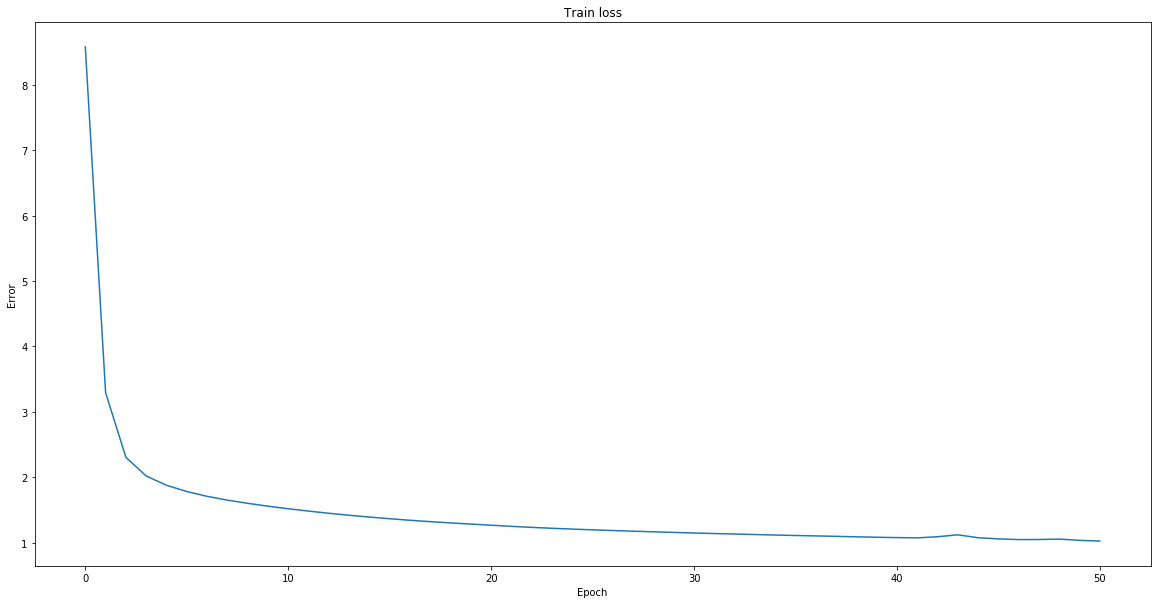

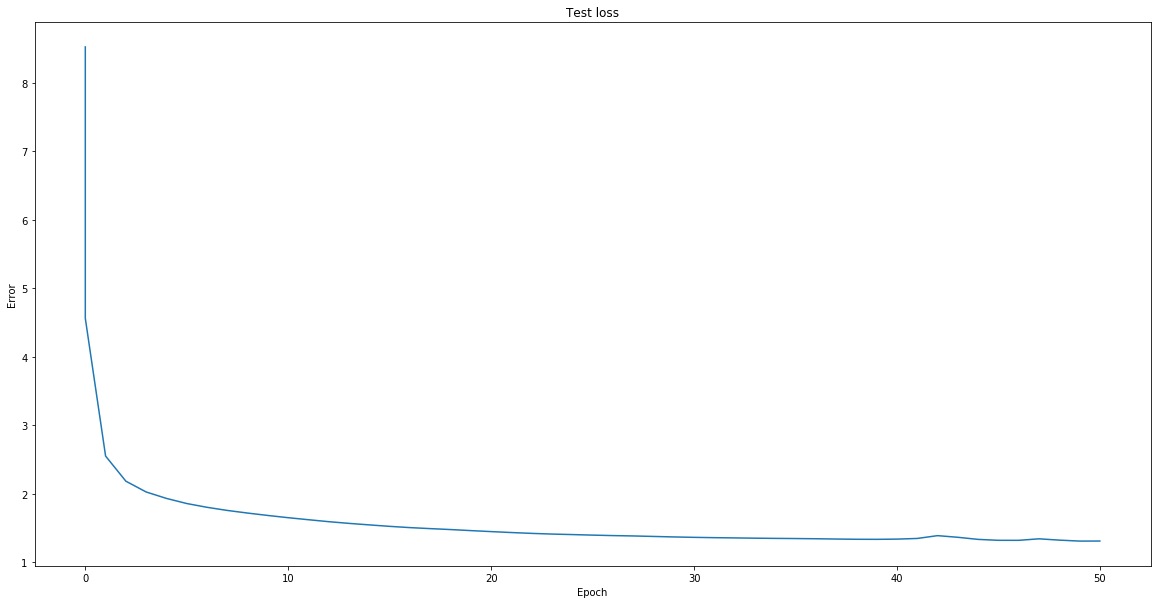

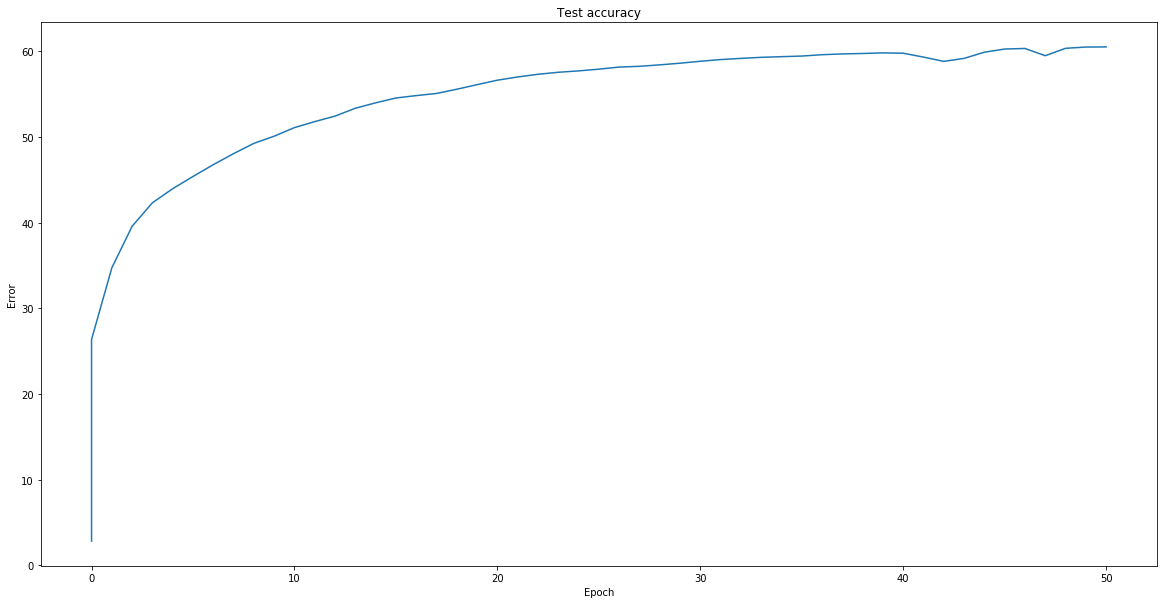

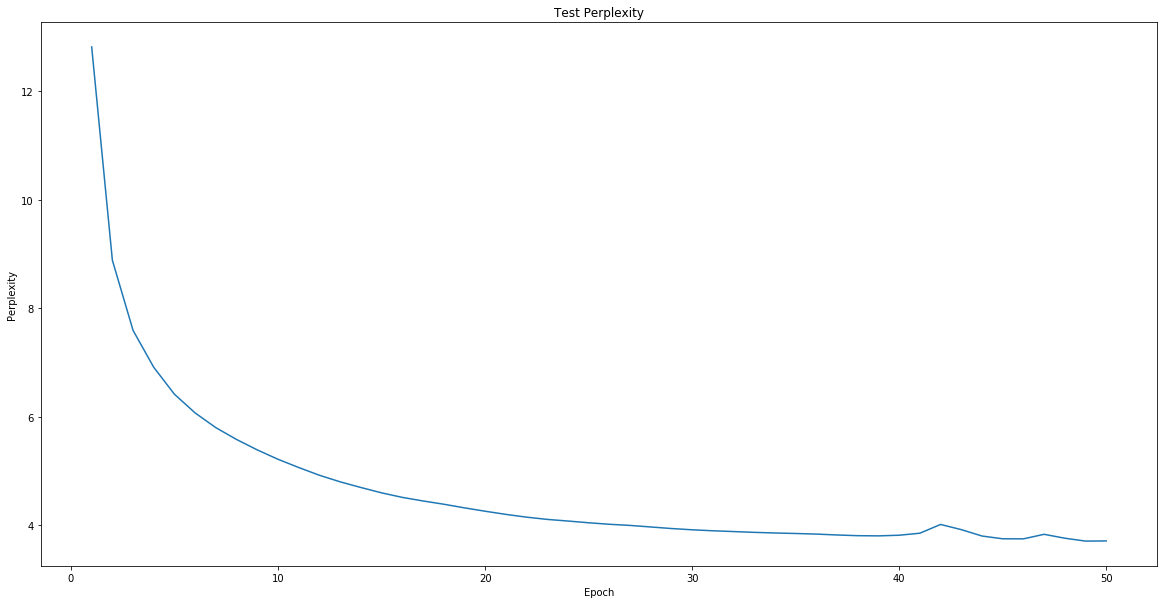

In [35]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 50
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'brief_history_lstm/logs/log.pkl'


    data_train = BriefHistoryDataset(DATA_PATH + 'a_brief_history_of_time_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = BriefHistoryDataset(DATA_PATH + 'a_brief_history_of_time_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = BriefHistoryLSTMNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'brief_history_lstm/checkpoints')

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))
    test_perplexities.append((start_epoch, test_perplexity))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            test_perplexities.append((epoch, test_perplexity))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'brief_history_lstm/checkpoints/%03d.pt' % epoch)
            seed_words = 'Black holes are '
            generated_sentence = generate_language(model, device, seed_words, 100, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 100, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 100, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'brief_history_lstm/checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep[2:], val[2:], 'Test Perplexity', 'Epoch', 'Perplexity')
        return model, vocab, device

final_model, vocab, device = main()

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    